In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.3 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import pathlib 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [3]:
!pip install -q git+https://github.com/tensorflow/docs 

  Preparing metadata (setup.py) ... done


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
df = pd.read_csv('MVP_Candidates.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [6]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-11', '2009-10', '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02','2000-01')
e3 = ('1999-00', '1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '1999-00') | (df['Year'] == '1998-99') | (df['Year'] == '1996-97') | (df['Year'] == '1995-96') | (df['Year'] == '1994-95') | (df['Year'] == '1993-94') | (df['Year'] == '1992-93') | (df['Year'] == '1991-92') | (df['Year'] == '1990-91') | (df['Year'] == '2002-03') | (df['Year'] == '1997-98')]


In [7]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
261,262,262,Tim Duncan,PF,4,26,SAS,81,81,2,...,94,109,151,9,114.7,148.3,1,1,0.808,2002-03
262,263,263,Kevin Garnett,PF,4,26,MIN,82,82,4,...,99,107,112,26,102.4,115.2,0,2,0.732,2002-03
263,264,264,Kobe Bryant,SG,2,24,LAL,82,82,6,...,111,106,123,93,36.5,136.6,0,3,0.417,2002-03
264,265,265,Tracy McGrady,SG,2,23,ORL,75,74,17,...,105,109,132,136,112.7,192.0,0,4,0.359,2002-03
265,266,266,Shaquille O'Neal,C,5,30,LAL,67,66,6,...,82,116,198,0,242.3,251.8,0,5,0.106,2002-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [8]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)
df1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
261,Tim Duncan,PF,4,26,SAS,81,81,2,0.731707,3181,...,94,109,151,9,114.7,148.3,1,1,0.808,2002-03
262,Kevin Garnett,PF,4,26,MIN,82,82,4,0.621951,3321,...,99,107,112,26,102.4,115.2,0,2,0.732,2002-03
263,Kobe Bryant,SG,2,24,LAL,82,82,6,0.609756,3401,...,111,106,123,93,36.5,136.6,0,3,0.417,2002-03
264,Tracy McGrady,SG,2,23,ORL,75,74,17,0.512195,2954,...,105,109,132,136,112.7,192.0,0,4,0.359,2002-03
265,Shaquille O'Neal,C,5,30,LAL,67,66,6,0.609756,2535,...,82,116,198,0,242.3,251.8,0,5,0.106,2002-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Bernard King,SF,3,34,WSB,64,64,20,0.365854,2401,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,Kenny Smith,PG,1,25,HOU,78,78,8,0.634146,2699,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,Hakeem Olajuwon,C,5,28,HOU,56,50,8,0.634146,2062,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,Tim Hardaway,PG,1,24,GSW,82,82,11,0.536585,3215,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [9]:
df1.to_csv('AncientEra.csv', index=False)

In [10]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [11]:

seasons = ['1999-00', '1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91']

In [12]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [13]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [14]:
for season in seasons:
    
    training_data = df1[(df1['Year'] != season)].copy()
    train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    train_labels = training_data['MVP Share']

    train.fillna(0)

    scaler = StandardScaler()
    normed_train_data = scaler.fit_transform(train)


In [15]:
def build_model1_two_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This is a Keras model wiTh multiple hidden layers.
    
    # Input Layer with 10 Neurons
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be mentioned
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(50,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(50, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 50)
    
    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    #Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model = build_model1_two_hidden_layers()
print('summary of this model: ')
model.summary()    

summary of this model: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                800       
                                                                 
 dense_1 (Dense)             (None, 50)                550       
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________


In [16]:
def build_model3_five_hidden_layers():
    # Keras model object created from Sequential class. This will be the container that contains all layers.
    model = Sequential()

    # The model so far is empty. It can be constructed by adding layers and compilation.
    # This Keras model with multiple hidden layers.
    
    # Input Layer with 32 Neurons
    model.add(Dense(32, input_shape = (normed_train_data.shape[1],)))    # Input layer => input_shape must be explicitly designated
#     model.add(Activation('relu')) # relu or sigmoid.
    
    model.add(Dense(64,Activation('relu')))                         # Hidden layer 1 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 2 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 3 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 4 => only output dimension should be designated (output dimension = # of Neurons = 64)
    
    
    model.add(Dense(64, Activation('relu')))                         # Hidden layer 5 => only output dimension should be designated (output dimension = # of Neurons = 64)

    
    model.add(Dense(1))                          # Output layer => output dimension = 1 since it is a regression problem
    
    # Activation: sigmoid, softmax, tanh, relu, LeakyReLU. 
    #Optimizer: SGD, Adam, RMSProp
    learning_rate = 0.01
    optimizer = optimizers.Adam(learning_rate)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'mape']) # for regression problems, mean squared error (MSE) is often employed
    
    return model

model3 = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model3.summary()

Here is a summary of this model: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                2560      
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)   

In [17]:
example_batch = normed_train_data[:10] # take the first 10 data points from the training data.
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 279ms/step


array([[-0.04273827],
       [-0.01362495],
       [-0.03251988],
       [-0.26648024],
       [ 0.1874891 ],
       [ 0.15218633],
       [-0.4895078 ],
       [-1.1731665 ],
       [-0.08230731],
       [-0.51205635]], dtype=float32)

In [18]:
checkpoint_path = r".\models\NBA_Prediction.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

# epoch

In [19]:
for season in seasons:
  testing_data = df1[(df1['Year'] == season)].copy()
  test = testing_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
  test_labels = testing_data['MVP Share']

  test.fillna(0)
  scaler = StandardScaler()
  normed_test_data = scaler.fit_transform(test)

  EPOCHS = 80
  batch_size = 50

  model = build_model3_five_hidden_layers()
  print('Here is a summary of this model: ')
  model.summary()


  with tf.device('/CPU:0'): 
      history = model.fit(
          normed_train_data, 
          train_labels,
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1,
          shuffle=True,
          steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
          callbacks=[tfdocs.modeling.EpochDots(), 
                  ckpt_callback
                    ],
          
      )
  Y_pred = model.predict(normed_test_data)

  rmse, r2 = calc_metrics(test_labels, Y_pred)

  season_metrics[season] += [rmse, r2]
  print(rmse,r2)

  initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
  results = initial_results.copy()
  results['Predicted MVP Share'] = Y_pred
  results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

  print(results)
  all_results = pd.concat([all_results, results])   


Here is a summary of this model: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                2560      
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)   

3/3 [==============================] - 2s 16ms/step - loss: 0.5129 - mae: 0.5003 - mse: 0.5129 - mape: 13029.4854
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0831 - mae: 0.2584 - mse: 0.0831 - mape: 7614.7080.

3/3 [==============================] - 0s 12ms/step - loss: 0.0668 - mae: 0.2249 - mse: 0.0668 - mape: 6836.8496
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - mae: 0.1159 - mse: 0.0274 - mape: 1789.9911.

3/3 [==============================] - 0s 9ms/step - loss: 0.0286 - mae: 0.1081 - mse: 0.0286 - mape: 1114.7001
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - mae: 0.0817 - mse: 0.0180 - mape: 526.5499.

3/3 [==============================] - 0s 12ms/step - loss: 0.0250 - mae: 0.0977 - mse: 0.0250 - mape: 692.9198
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - mae: 0.1094 - mse: 0.0326 - mape: 569.2382.

3/3 [==============================] - 0s 12ms/step - loss: 0.0287 - mae: 0.0953 - mse: 0.0287 - mape: 533.9528
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - mae: 0.0577 - mse: 0.0052 - mape: 1092.0183.

3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - mae: 0.0907 - mse: 0.0190 - mape: 1456.7067
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - mae: 0.0914 - mse: 0.0235 - mape: 1046.3805.

3/3 [==============================] - 0s 11ms/step - loss: 0.0229 - mae: 0.0861 - mse: 0.0229 - mape: 863.6644
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - mae: 0.0604 - mse: 0.0114 - mape: 439.4594.

3/3 [==============================] - 0s 13ms/step - loss: 0.0128 - mae: 0.0672 - mse: 0.0128 - mape: 412.2851
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0238 - mae: 0.0997 - mse: 0.0238 - mape: 752.3508.

3/3 [==============================] - 0s 11ms/step - loss: 0.0216 - mae: 0.0913 - mse: 0.0216 - mape: 1008.2460
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - mae: 0.0946 - mse: 0.0192 - mape: 672.9082.

3/3 [==============================] - 0s 9ms/step - loss: 0.0170 - mae: 0.0788 - mse: 0.0170 - mape: 554.2065
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - mae: 0.0618 - mse: 0.0099 - mape: 447.3240.

3/3 [==============================] - 0s 15ms/step - loss: 0.0141 - mae: 0.0676 - mse: 0.0141 - mape: 606.1385
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - mae: 0.0745 - mse: 0.0123 - mape: 401.6075.

3/3 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.0670 - mse: 0.0108 - mape: 452.1690
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - mae: 0.0720 - mse: 0.0138 - mape: 249.3432.

3/3 [==============================] - 0s 9ms/step - loss: 0.0153 - mae: 0.0760 - mse: 0.0153 - mape: 483.0605
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - mae: 0.0518 - mse: 0.0066 - mape: 643.6615.

3/3 [==============================] - 0s 10ms/step - loss: 0.0103 - mae: 0.0605 - mse: 0.0103 - mape: 475.9623
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - mae: 0.0702 - mse: 0.0121 - mape: 673.2971.

3/3 [==============================] - 0s 11ms/step - loss: 0.0096 - mae: 0.0591 - mse: 0.0096 - mape: 682.4749
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0198 - mae: 0.0835 - mse: 0.0198 - mape: 496.3349.

3/3 [==============================] - 0s 10ms/step - loss: 0.0261 - mae: 0.0985 - mse: 0.0261 - mape: 402.4731
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - mae: 0.0675 - mse: 0.0082 - mape: 1108.3033.

3/3 [==============================] - 0s 11ms/step - loss: 0.0301 - mae: 0.0989 - mse: 0.0301 - mape: 1078.2037
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0338 - mse: 0.0036 - mape: 940.7850.

3/3 [==============================] - 0s 9ms/step - loss: 0.0137 - mae: 0.0673 - mse: 0.0137 - mape: 621.4442
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - mae: 0.0670 - mse: 0.0118 - mape: 555.9666.

3/3 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.0752 - mse: 0.0146 - mape: 741.6808
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - mae: 0.0908 - mse: 0.0196 - mape: 444.6290.

3/3 [==============================] - 0s 13ms/step - loss: 0.0146 - mae: 0.0811 - mse: 0.0146 - mape: 926.3804
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - mae: 0.0879 - mse: 0.0182 - mape: 897.6180.

3/3 [==============================] - 0s 12ms/step - loss: 0.0129 - mae: 0.0715 - mse: 0.0129 - mape: 733.1784
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - mae: 0.0582 - mse: 0.0089 - mape: 438.9135.

3/3 [==============================] - 0s 13ms/step - loss: 0.0078 - mae: 0.0554 - mse: 0.0078 - mape: 781.8285
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - mae: 0.0552 - mse: 0.0089 - mape: 716.6497.

3/3 [==============================] - 0s 10ms/step - loss: 0.0114 - mae: 0.0611 - mse: 0.0114 - mape: 634.1893
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - mae: 0.0651 - mse: 0.0079 - mape: 742.9524.

3/3 [==============================] - 0s 9ms/step - loss: 0.0091 - mae: 0.0624 - mse: 0.0091 - mape: 652.7554
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - mae: 0.0665 - mse: 0.0108 - mape: 785.5376.

3/3 [==============================] - 0s 10ms/step - loss: 0.0077 - mae: 0.0585 - mse: 0.0077 - mape: 641.5283
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0486 - mse: 0.0043 - mape: 730.2913.

3/3 [==============================] - 0s 10ms/step - loss: 0.0042 - mae: 0.0452 - mse: 0.0042 - mape: 490.8322
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - mae: 0.0640 - mse: 0.0108 - mape: 358.4090.

3/3 [==============================] - 0s 11ms/step - loss: 0.0078 - mae: 0.0547 - mse: 0.0078 - mape: 413.9980
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0404 - mse: 0.0044 - mape: 492.8865.

3/3 [==============================] - 0s 11ms/step - loss: 0.0047 - mae: 0.0478 - mse: 0.0047 - mape: 507.4160
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - mae: 0.0631 - mse: 0.0069 - mape: 320.8164.

3/3 [==============================] - 0s 12ms/step - loss: 0.0053 - mae: 0.0458 - mse: 0.0053 - mape: 323.9108
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - mae: 0.0549 - mse: 0.0109 - mape: 333.0002.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0488 - mse: 0.0073 - mape: 262.4422
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - mae: 0.0595 - mse: 0.0076 - mape: 391.4957.

3/3 [==============================] - 0s 11ms/step - loss: 0.0080 - mae: 0.0549 - mse: 0.0080 - mape: 568.4811
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - mae: 0.0747 - mse: 0.0111 - mape: 626.0769.

3/3 [==============================] - 0s 10ms/step - loss: 0.0080 - mae: 0.0611 - mse: 0.0080 - mape: 519.2609
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - mae: 0.0633 - mse: 0.0111 - mape: 305.0248.

3/3 [==============================] - 0s 10ms/step - loss: 0.0083 - mae: 0.0553 - mse: 0.0083 - mape: 522.4129
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - mae: 0.1029 - mse: 0.0256 - mape: 1016.1631.

3/3 [==============================] - 0s 11ms/step - loss: 0.0083 - mae: 0.0568 - mse: 0.0083 - mape: 652.7779
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - mae: 0.0656 - mse: 0.0115 - mape: 311.5110.

3/3 [==============================] - 0s 10ms/step - loss: 0.0083 - mae: 0.0568 - mse: 0.0083 - mape: 305.2040
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0402 - mse: 0.0044 - mape: 382.0275.

3/3 [==============================] - 0s 10ms/step - loss: 0.0084 - mae: 0.0554 - mse: 0.0084 - mape: 568.6915
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - mae: 0.0501 - mse: 0.0056 - mape: 571.8621.

3/3 [==============================] - 0s 10ms/step - loss: 0.0061 - mae: 0.0502 - mse: 0.0061 - mape: 498.0483
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - mae: 0.0541 - mse: 0.0096 - mape: 497.8554.

3/3 [==============================] - 0s 11ms/step - loss: 0.0086 - mae: 0.0557 - mse: 0.0086 - mape: 363.9420
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - mae: 0.0578 - mse: 0.0075 - mape: 555.0086.

3/3 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0457 - mse: 0.0051 - mape: 499.2698
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0406 - mse: 0.0042 - mape: 282.7989.

3/3 [==============================] - 0s 11ms/step - loss: 0.0042 - mae: 0.0421 - mse: 0.0042 - mape: 280.0267
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0392 - mse: 0.0034 - mape: 385.6232.

3/3 [==============================] - 0s 11ms/step - loss: 0.0046 - mae: 0.0442 - mse: 0.0046 - mape: 530.0685
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - mae: 0.0517 - mse: 0.0051 - mape: 607.8336.

3/3 [==============================] - 0s 16ms/step - loss: 0.0039 - mae: 0.0410 - mse: 0.0039 - mape: 549.5188
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0483 - mse: 0.0043 - mape: 528.2042.

3/3 [==============================] - 0s 17ms/step - loss: 0.0027 - mae: 0.0370 - mse: 0.0027 - mape: 604.1633
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0409 - mse: 0.0044 - mape: 631.1415.

3/3 [==============================] - 0s 12ms/step - loss: 0.0045 - mae: 0.0439 - mse: 0.0045 - mape: 728.4617
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0348 - mse: 0.0019 - mape: 650.7916.

3/3 [==============================] - 0s 14ms/step - loss: 0.0026 - mae: 0.0360 - mse: 0.0026 - mape: 627.4561
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0371 - mse: 0.0026 - mape: 577.0247.

3/3 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0328 - mse: 0.0024 - mape: 455.6440
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 7.1386e-04 - mae: 0.0209 - mse: 7.1386e-04 - mape: 404.1857.

3/3 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0267 - mse: 0.0015 - mape: 421.7072   
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0298 - mse: 0.0022 - mape: 270.5132.

3/3 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0289 - mse: 0.0020 - mape: 291.6128
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0228 - mse: 0.0012 - mape: 457.3082.

3/3 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0260 - mse: 0.0015 - mape: 347.1359
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 3.4008e-04 - mae: 0.0137 - mse: 3.4008e-04 - mape: 273.5984.

3/3 [==============================] - 0s 13ms/step - loss: 9.6622e-04 - mae: 0.0208 - mse: 9.6622e-04 - mape: 223.2739
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0240 - mse: 0.0012 - mape: 432.7672.

3/3 [==============================] - 0s 12ms/step - loss: 9.6840e-04 - mae: 0.0212 - mse: 9.6840e-04 - mape: 348.0617
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0255 - mse: 0.0012 - mape: 317.4159.

3/3 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0211 - mse: 0.0011 - mape: 285.9687
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0218 - mse: 0.0010 - mape: 340.1396.

3/3 [==============================] - 0s 13ms/step - loss: 9.3895e-04 - mae: 0.0207 - mse: 9.3895e-04 - mape: 270.0216
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 5.6331e-04 - mae: 0.0184 - mse: 5.6331e-04 - mape: 349.6392.

3/3 [==============================] - 0s 17ms/step - loss: 9.2985e-04 - mae: 0.0214 - mse: 9.2985e-04 - mape: 349.1824
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 3.2823e-04 - mae: 0.0135 - mse: 3.2823e-04 - mape: 196.2819.

3/3 [==============================] - 0s 12ms/step - loss: 6.2069e-04 - mae: 0.0165 - mse: 6.2069e-04 - mape: 203.5774
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 3.2608e-04 - mae: 0.0144 - mse: 3.2608e-04 - mape: 214.2375.

3/3 [==============================] - 0s 12ms/step - loss: 4.6462e-04 - mae: 0.0153 - mse: 4.6462e-04 - mape: 273.5427
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 2.9473e-04 - mae: 0.0117 - mse: 2.9473e-04 - mape: 169.0114.

3/3 [==============================] - 0s 12ms/step - loss: 5.6692e-04 - mae: 0.0155 - mse: 5.6692e-04 - mape: 261.6257
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 7.6159e-04 - mae: 0.0235 - mse: 7.6159e-04 - mape: 288.7513.

3/3 [==============================] - 0s 15ms/step - loss: 5.8373e-04 - mae: 0.0173 - mse: 5.8373e-04 - mape: 308.7140
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7622e-04 - mae: 0.0144 - mse: 3.7622e-04 - mape: 260.7563.

3/3 [==============================] - 0s 14ms/step - loss: 5.7396e-04 - mae: 0.0161 - mse: 5.7396e-04 - mape: 289.1429
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 4.5444e-04 - mae: 0.0158 - mse: 4.5444e-04 - mape: 166.0452.

3/3 [==============================] - 0s 12ms/step - loss: 5.5000e-04 - mae: 0.0158 - mse: 5.5000e-04 - mape: 214.7500
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 6.6611e-04 - mae: 0.0176 - mse: 6.6611e-04 - mape: 191.3534.

3/3 [==============================] - 0s 12ms/step - loss: 7.5245e-04 - mae: 0.0187 - mse: 7.5245e-04 - mape: 263.3212
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 2.8386e-04 - mae: 0.0122 - mse: 2.8386e-04 - mape: 178.3095.

3/3 [==============================] - 0s 14ms/step - loss: 6.5643e-04 - mae: 0.0164 - mse: 6.5643e-04 - mape: 272.0470
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 9.2264e-04 - mae: 0.0200 - mse: 9.2264e-04 - mape: 318.1559.

3/3 [==============================] - 0s 13ms/step - loss: 7.0311e-04 - mae: 0.0174 - mse: 7.0311e-04 - mape: 229.1733
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 3.8140e-04 - mae: 0.0139 - mse: 3.8140e-04 - mape: 216.1802.

3/3 [==============================] - 0s 16ms/step - loss: 5.3680e-04 - mae: 0.0162 - mse: 5.3680e-04 - mape: 245.8550
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 5.8463e-04 - mae: 0.0160 - mse: 5.8463e-04 - mape: 341.6363.

3/3 [==============================] - 0s 15ms/step - loss: 6.3547e-04 - mae: 0.0168 - mse: 6.3547e-04 - mape: 285.2199
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7372e-04 - mae: 0.0156 - mse: 3.7372e-04 - mape: 132.8153.

3/3 [==============================] - 0s 13ms/step - loss: 4.9359e-04 - mae: 0.0161 - mse: 4.9359e-04 - mape: 258.0768
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 7.3722e-04 - mae: 0.0195 - mse: 7.3722e-04 - mape: 282.6295.

3/3 [==============================] - 0s 12ms/step - loss: 5.6146e-04 - mae: 0.0164 - mse: 5.6146e-04 - mape: 253.3354
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0230 - mse: 0.0011 - mape: 188.2079.

3/3 [==============================] - 0s 14ms/step - loss: 7.0792e-04 - mae: 0.0181 - mse: 7.0792e-04 - mape: 215.3742
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0224 - mse: 0.0012 - mape: 166.0568.

3/3 [==============================] - 0s 13ms/step - loss: 6.8521e-04 - mae: 0.0168 - mse: 6.8521e-04 - mape: 223.6644
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 7.3952e-04 - mae: 0.0217 - mse: 7.3952e-04 - mape: 393.4645.

3/3 [==============================] - 0s 15ms/step - loss: 7.3258e-04 - mae: 0.0182 - mse: 7.3258e-04 - mape: 279.4833
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0654e-04 - mae: 0.0181 - mse: 7.0654e-04 - mape: 183.4355.

3/3 [==============================] - 0s 14ms/step - loss: 6.7352e-04 - mae: 0.0180 - mse: 6.7352e-04 - mape: 206.6821
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 3.6499e-04 - mae: 0.0115 - mse: 3.6499e-04 - mape: 162.7165.

3/3 [==============================] - 0s 16ms/step - loss: 6.3038e-04 - mae: 0.0159 - mse: 6.3038e-04 - mape: 199.8116
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7707e-04 - mae: 0.0136 - mse: 3.7707e-04 - mape: 206.0835.

3/3 [==============================] - 0s 17ms/step - loss: 5.0560e-04 - mae: 0.0147 - mse: 5.0560e-04 - mape: 234.0964
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 9.2878e-04 - mae: 0.0201 - mse: 9.2878e-04 - mape: 123.7342.

3/3 [==============================] - 0s 13ms/step - loss: 7.5959e-04 - mae: 0.0173 - mse: 7.5959e-04 - mape: 189.0707
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 1.9495e-04 - mae: 0.0102 - mse: 1.9495e-04 - mape: 216.4111.

3/3 [==============================] - 0s 21ms/step - loss: 3.3203e-04 - mae: 0.0130 - mse: 3.3203e-04 - mape: 198.6558
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 5.8630e-04 - mae: 0.0165 - mse: 5.8630e-04 - mape: 138.7417.

3/3 [==============================] - 0s 14ms/step - loss: 4.2638e-04 - mae: 0.0135 - mse: 4.2638e-04 - mape: 173.0135
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 9.7297e-04 - mae: 0.0199 - mse: 9.7297e-04 - mape: 172.7614.

3/3 [==============================] - 0s 13ms/step - loss: 7.1306e-04 - mae: 0.0171 - mse: 7.1306e-04 - mape: 200.5779
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - mae: 0.0291 - mse: 0.0027 - mape: 121.6927.

3/3 [==============================] - 0s 14ms/step - loss: 0.0016 - mae: 0.0241 - mse: 0.0016 - mape: 210.9310
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0289 - mse: 0.0025 - mape: 322.3673.

3/3 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0231 - mse: 0.0016 - mape: 216.0872
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 7.5606e-04 - mae: 0.0153 - mse: 7.5606e-04 - mape: 219.1963.

1/1 [==============================] - 0s 150ms/step
0.09450742539741766 0.8477541769466392
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1999-00   Shaquille O'Neal      0.998         1             1.103841
1   1999-00        Karl Malone      0.258         4             0.497283
2   1999-00         Tim Duncan      0.205         5             0.239681
3   1999-00        Gary Payton      0.149         6             0.236336
4   1999-00      Kevin Garnett      0.337         2             0.207546
5   1999-00      Allen Iverson      0.109         7             0.140091
6   1999-00    Alonzo Mourning      0.303         3             0.093743
7   1999-00       Chris Webber      0.079         9             0.051953
8   1999-00         Grant Hill      0.093         8             0.042448
9   1999-00       Vince Carter      0.042        10             0.040255
10  1999-00         Jason Kidd      0.021        11             0.038738
11  1999-00        Kobe Bryant  

3/3 [==============================] - 2s 12ms/step - loss: 0.3511 - mae: 0.4342 - mse: 0.3511 - mape: 11385.3096
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - mae: 0.0385 - mse: 0.0052 - mape: 527.4863.

3/3 [==============================] - 0s 12ms/step - loss: 0.0835 - mae: 0.1541 - mse: 0.0835 - mape: 753.4003
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0848 - mae: 0.1673 - mse: 0.0848 - mape: 1488.6167.

3/3 [==============================] - 0s 13ms/step - loss: 0.0546 - mae: 0.1476 - mse: 0.0546 - mape: 2855.1619
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0362 - mae: 0.1543 - mse: 0.0362 - mape: 3625.1365.

3/3 [==============================] - 0s 13ms/step - loss: 0.0406 - mae: 0.1548 - mse: 0.0406 - mape: 2850.4329
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0326 - mae: 0.1152 - mse: 0.0326 - mape: 1952.0303.

3/3 [==============================] - 0s 13ms/step - loss: 0.0327 - mae: 0.1071 - mse: 0.0327 - mape: 1032.8158
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0252 - mae: 0.1198 - mse: 0.0252 - mape: 242.7864.

3/3 [==============================] - 0s 13ms/step - loss: 0.0311 - mae: 0.1062 - mse: 0.0311 - mape: 524.6693
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - mae: 0.1044 - mse: 0.0278 - mape: 804.6910.

3/3 [==============================] - 0s 12ms/step - loss: 0.0290 - mae: 0.1153 - mse: 0.0290 - mape: 1433.7059
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - mae: 0.1091 - mse: 0.0265 - mape: 1836.4326.

3/3 [==============================] - 0s 11ms/step - loss: 0.0258 - mae: 0.1061 - mse: 0.0258 - mape: 1315.5051
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0358 - mae: 0.1134 - mse: 0.0358 - mape: 677.5696.

3/3 [==============================] - 0s 12ms/step - loss: 0.0239 - mae: 0.0953 - mse: 0.0239 - mape: 983.9062
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - mae: 0.0962 - mse: 0.0158 - mape: 1328.5520.

3/3 [==============================] - 0s 11ms/step - loss: 0.0145 - mae: 0.0792 - mse: 0.0145 - mape: 971.1885
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0232 - mae: 0.0908 - mse: 0.0232 - mape: 521.3169.

3/3 [==============================] - 0s 11ms/step - loss: 0.0215 - mae: 0.0809 - mse: 0.0215 - mape: 628.0969
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - mae: 0.0730 - mse: 0.0157 - mape: 834.1055.

3/3 [==============================] - 0s 12ms/step - loss: 0.0176 - mae: 0.0843 - mse: 0.0176 - mape: 675.3501
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0119 - mae: 0.0724 - mse: 0.0119 - mape: 667.8527.

3/3 [==============================] - 0s 11ms/step - loss: 0.0143 - mae: 0.0751 - mse: 0.0143 - mape: 725.1230
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - mae: 0.0449 - mse: 0.0075 - mape: 457.6331.

3/3 [==============================] - 0s 11ms/step - loss: 0.0090 - mae: 0.0534 - mse: 0.0090 - mape: 593.4315
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - mae: 0.0628 - mse: 0.0101 - mape: 489.3866.

3/3 [==============================] - 0s 10ms/step - loss: 0.0156 - mae: 0.0760 - mse: 0.0156 - mape: 623.8154
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - mae: 0.0654 - mse: 0.0092 - mape: 893.8743.

3/3 [==============================] - 0s 11ms/step - loss: 0.0112 - mae: 0.0688 - mse: 0.0112 - mape: 733.7498
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - mae: 0.0466 - mse: 0.0082 - mape: 806.4830.

3/3 [==============================] - 0s 12ms/step - loss: 0.0239 - mae: 0.0883 - mse: 0.0239 - mape: 746.2474
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - mae: 0.0830 - mse: 0.0173 - mape: 220.8555.

3/3 [==============================] - 0s 11ms/step - loss: 0.0235 - mae: 0.0931 - mse: 0.0235 - mape: 1050.9160
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - mae: 0.0749 - mse: 0.0125 - mape: 763.0859.

3/3 [==============================] - 0s 11ms/step - loss: 0.0183 - mae: 0.0842 - mse: 0.0183 - mape: 538.3982
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - mae: 0.0508 - mse: 0.0079 - mape: 584.1255.

3/3 [==============================] - 0s 11ms/step - loss: 0.0153 - mae: 0.0707 - mse: 0.0153 - mape: 433.7760
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - mae: 0.0399 - mse: 0.0047 - mape: 716.8981.

3/3 [==============================] - 0s 11ms/step - loss: 0.0123 - mae: 0.0690 - mse: 0.0123 - mape: 831.8475
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - mae: 0.0722 - mse: 0.0110 - mape: 637.8967.

3/3 [==============================] - 0s 11ms/step - loss: 0.0091 - mae: 0.0563 - mse: 0.0091 - mape: 529.2013
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - mae: 0.0727 - mse: 0.0126 - mape: 312.6758.

3/3 [==============================] - 0s 11ms/step - loss: 0.0090 - mae: 0.0594 - mse: 0.0090 - mape: 372.4873
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - mae: 0.0499 - mse: 0.0074 - mape: 374.1919.

3/3 [==============================] - 0s 12ms/step - loss: 0.0090 - mae: 0.0555 - mse: 0.0090 - mape: 525.8898
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - mae: 0.0401 - mse: 0.0052 - mape: 799.8329.

3/3 [==============================] - 0s 11ms/step - loss: 0.0053 - mae: 0.0418 - mse: 0.0053 - mape: 444.7484
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - mae: 0.0667 - mse: 0.0121 - mape: 162.2131.

3/3 [==============================] - 0s 11ms/step - loss: 0.0055 - mae: 0.0429 - mse: 0.0055 - mape: 374.0350
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - mae: 0.0502 - mse: 0.0068 - mape: 499.4883.

3/3 [==============================] - 0s 11ms/step - loss: 0.0060 - mae: 0.0483 - mse: 0.0060 - mape: 539.6704
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0391 - mse: 0.0044 - mape: 382.9032.

3/3 [==============================] - 0s 14ms/step - loss: 0.0053 - mae: 0.0452 - mse: 0.0053 - mape: 426.5153
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - mae: 0.0368 - mse: 0.0037 - mape: 300.0195.

3/3 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0399 - mse: 0.0043 - mape: 391.3392
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - mae: 0.0484 - mse: 0.0077 - mape: 321.3381.

3/3 [==============================] - 0s 10ms/step - loss: 0.0055 - mae: 0.0461 - mse: 0.0055 - mape: 273.0735
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0279 - mse: 0.0019 - mape: 471.0806.

3/3 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0410 - mse: 0.0046 - mape: 404.1636
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0388 - mse: 0.0041 - mape: 536.1791.

3/3 [==============================] - 0s 10ms/step - loss: 0.0049 - mae: 0.0431 - mse: 0.0049 - mape: 430.9301
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0284 - mse: 0.0019 - mape: 591.1141.

3/3 [==============================] - 0s 14ms/step - loss: 0.0040 - mae: 0.0398 - mse: 0.0040 - mape: 418.0013
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0525 - mse: 0.0072 - mape: 203.8317.

3/3 [==============================] - 0s 11ms/step - loss: 0.0076 - mae: 0.0532 - mse: 0.0076 - mape: 391.0750
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0265 - mse: 0.0018 - mape: 402.6694.

3/3 [==============================] - 0s 10ms/step - loss: 0.0027 - mae: 0.0334 - mse: 0.0027 - mape: 279.6749
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0328 - mse: 0.0028 - mape: 381.3267.

3/3 [==============================] - 0s 10ms/step - loss: 0.0051 - mae: 0.0408 - mse: 0.0051 - mape: 297.9152
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0430 - mse: 0.0048 - mape: 295.6362.

3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - mae: 0.0394 - mse: 0.0040 - mape: 258.2328
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0463 - mse: 0.0039 - mape: 517.7524.

3/3 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0448 - mse: 0.0043 - mape: 269.1544
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0400 - mse: 0.0048 - mape: 364.0536.

3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - mae: 0.0384 - mse: 0.0040 - mape: 430.1326
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - mae: 0.0371 - mse: 0.0040 - mape: 476.5748.

3/3 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0369 - mse: 0.0035 - mape: 472.0561
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - mae: 0.0429 - mse: 0.0050 - mape: 326.3387.

3/3 [==============================] - 0s 12ms/step - loss: 0.0037 - mae: 0.0373 - mse: 0.0037 - mape: 326.3391
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0287 - mse: 0.0020 - mape: 113.2544.

3/3 [==============================] - 0s 12ms/step - loss: 0.0033 - mae: 0.0362 - mse: 0.0033 - mape: 295.6948
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0264 - mse: 0.0020 - mape: 204.1102.

3/3 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0335 - mse: 0.0031 - mape: 247.4773
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - mae: 0.0339 - mse: 0.0032 - mape: 325.4807.

3/3 [==============================] - 0s 11ms/step - loss: 0.0026 - mae: 0.0308 - mse: 0.0026 - mape: 267.0945
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0305 - mse: 0.0023 - mape: 327.8623.

3/3 [==============================] - 0s 12ms/step - loss: 0.0028 - mae: 0.0336 - mse: 0.0028 - mape: 319.1462
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0246 - mse: 0.0020 - mape: 129.4741.

3/3 [==============================] - 0s 11ms/step - loss: 0.0028 - mae: 0.0334 - mse: 0.0028 - mape: 194.0230
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0207 - mse: 0.0011 - mape: 246.0145.

3/3 [==============================] - 0s 10ms/step - loss: 0.0019 - mae: 0.0267 - mse: 0.0019 - mape: 246.3987
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0322 - mse: 0.0021 - mape: 407.1248.

3/3 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0290 - mse: 0.0021 - mape: 313.2331
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - mae: 0.0326 - mse: 0.0031 - mape: 236.6904.

3/3 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0279 - mse: 0.0021 - mape: 248.5114
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0269 - mse: 0.0020 - mape: 289.9779.

3/3 [==============================] - 0s 11ms/step - loss: 8.9663e-04 - mae: 0.0185 - mse: 8.9663e-04 - mape: 213.7043
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 7.2462e-04 - mae: 0.0180 - mse: 7.2462e-04 - mape: 235.8076.

3/3 [==============================] - 0s 11ms/step - loss: 8.3846e-04 - mae: 0.0196 - mse: 8.3846e-04 - mape: 246.5817
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0222 - mse: 0.0013 - mape: 139.5910.

3/3 [==============================] - 0s 12ms/step - loss: 8.0338e-04 - mae: 0.0185 - mse: 8.0338e-04 - mape: 237.8377
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 3.8332e-04 - mae: 0.0144 - mse: 3.8332e-04 - mape: 256.6426.

3/3 [==============================] - 0s 11ms/step - loss: 6.5230e-04 - mae: 0.0159 - mse: 6.5230e-04 - mape: 229.1735
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0657e-04 - mae: 0.0178 - mse: 7.0657e-04 - mape: 194.0324.

3/3 [==============================] - 0s 11ms/step - loss: 5.0179e-04 - mae: 0.0148 - mse: 5.0179e-04 - mape: 187.3011
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 7.1136e-04 - mae: 0.0193 - mse: 7.1136e-04 - mape: 198.1769.

3/3 [==============================] - 0s 11ms/step - loss: 4.4958e-04 - mae: 0.0152 - mse: 4.4958e-04 - mape: 193.9132
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 4.1107e-04 - mae: 0.0136 - mse: 4.1107e-04 - mape: 141.6124.

3/3 [==============================] - 0s 14ms/step - loss: 5.2975e-04 - mae: 0.0148 - mse: 5.2975e-04 - mape: 138.8287
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 7.2852e-04 - mae: 0.0180 - mse: 7.2852e-04 - mape: 244.5797.

3/3 [==============================] - 0s 15ms/step - loss: 4.3487e-04 - mae: 0.0144 - mse: 4.3487e-04 - mape: 239.9528
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 6.7544e-04 - mae: 0.0189 - mse: 6.7544e-04 - mape: 394.6303.

3/3 [==============================] - 0s 13ms/step - loss: 4.5687e-04 - mae: 0.0135 - mse: 4.5687e-04 - mape: 211.0408
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 6.1353e-04 - mae: 0.0162 - mse: 6.1353e-04 - mape: 132.2609.

3/3 [==============================] - 0s 13ms/step - loss: 4.3842e-04 - mae: 0.0138 - mse: 4.3842e-04 - mape: 157.4428
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 5.8843e-04 - mae: 0.0159 - mse: 5.8843e-04 - mape: 121.1450.

3/3 [==============================] - 0s 16ms/step - loss: 4.7401e-04 - mae: 0.0139 - mse: 4.7401e-04 - mape: 127.5107
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 8.9005e-04 - mae: 0.0149 - mse: 8.9005e-04 - mape: 124.8800.

3/3 [==============================] - 0s 12ms/step - loss: 5.7458e-04 - mae: 0.0141 - mse: 5.7458e-04 - mape: 197.2776
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 1.6918e-04 - mae: 0.0093 - mse: 1.6918e-04 - mape: 210.5278.

3/3 [==============================] - 0s 12ms/step - loss: 3.4019e-04 - mae: 0.0115 - mse: 3.4019e-04 - mape: 165.0524
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7523e-04 - mae: 0.0116 - mse: 3.7523e-04 - mape: 97.9294.

3/3 [==============================] - 0s 12ms/step - loss: 4.2231e-04 - mae: 0.0131 - mse: 4.2231e-04 - mape: 105.6114
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 3.5405e-04 - mae: 0.0129 - mse: 3.5405e-04 - mape: 114.5832.

3/3 [==============================] - 0s 16ms/step - loss: 8.6580e-04 - mae: 0.0165 - mse: 8.6580e-04 - mape: 118.6758
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 7.9797e-04 - mae: 0.0165 - mse: 7.9797e-04 - mape: 219.2181.

3/3 [==============================] - 0s 17ms/step - loss: 4.7819e-04 - mae: 0.0135 - mse: 4.7819e-04 - mape: 215.7559
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 2.1509e-04 - mae: 0.0111 - mse: 2.1509e-04 - mape: 225.7497.

3/3 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0183 - mse: 0.0012 - mape: 218.6921   
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0174 - mse: 0.0012 - mape: 111.7477.

3/3 [==============================] - 0s 11ms/step - loss: 0.0010 - mae: 0.0176 - mse: 0.0010 - mape: 144.9328
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 9.5534e-04 - mae: 0.0186 - mse: 9.5534e-04 - mape: 156.4755.

3/3 [==============================] - 0s 11ms/step - loss: 8.1261e-04 - mae: 0.0171 - mse: 8.1261e-04 - mape: 147.1288
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0194 - mse: 0.0012 - mape: 110.6743.

3/3 [==============================] - 0s 11ms/step - loss: 7.3586e-04 - mae: 0.0154 - mse: 7.3586e-04 - mape: 135.6132
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 2.3470e-04 - mae: 0.0123 - mse: 2.3470e-04 - mape: 173.8283.

3/3 [==============================] - 0s 11ms/step - loss: 7.3386e-04 - mae: 0.0178 - mse: 7.3386e-04 - mape: 169.0519
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 3.5033e-04 - mae: 0.0117 - mse: 3.5033e-04 - mape: 140.0675.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0176 - mse: 0.0011 - mape: 112.1764   
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 2.5134e-04 - mae: 0.0104 - mse: 2.5134e-04 - mape: 186.9597.

3/3 [==============================] - 0s 11ms/step - loss: 4.2594e-04 - mae: 0.0126 - mse: 4.2594e-04 - mape: 146.8234
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0243 - mse: 0.0022 - mape: 206.3007.

3/3 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0181 - mse: 0.0012 - mape: 145.8372
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0243 - mse: 0.0013 - mape: 376.8304.

3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0214 - mse: 0.0016 - mape: 183.6895
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0254 - mse: 0.0020 - mape: 117.1253.

3/3 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0191 - mse: 0.0012 - mape: 173.5643
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 1.9488e-04 - mae: 0.0086 - mse: 1.9488e-04 - mape: 130.1578.

3/3 [==============================] - 0s 11ms/step - loss: 9.6869e-04 - mae: 0.0170 - mse: 9.6869e-04 - mape: 119.4258
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 3.3297e-04 - mae: 0.0114 - mse: 3.3297e-04 - mape: 117.1016.

3/3 [==============================] - 0s 13ms/step - loss: 0.0017 - mae: 0.0211 - mse: 0.0017 - mape: 148.3289   
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0203 - mse: 0.0011 - mape: 130.2699.

3/3 [==============================] - 0s 12ms/step - loss: 0.0046 - mae: 0.0334 - mse: 0.0046 - mape: 151.4335
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0207 - mse: 0.0013 - mape: 220.7500.

3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0248 - mse: 0.0024 - mape: 286.7264
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0298 - mse: 0.0030 - mape: 220.2531.

1/1 [==============================] - 0s 95ms/step
0.12612584406862462 0.6940529522426025
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1998-99         Tim Duncan      0.627         3             0.639292
1   1998-99        Karl Malone      0.701         1             0.560409
2   1998-99   Shaquille O'Neal      0.075         6             0.370564
3   1998-99      Allen Iverson      0.270         4             0.297375
4   1998-99    Alonzo Mourning      0.655         2             0.203664
5   1998-99        Gary Payton      0.030         9             0.129138
6   1998-99         Grant Hill      0.033         8             0.103043
7   1998-99         Jason Kidd      0.135         5             0.099156
8   1998-99     David Robinson      0.005        12             0.047052
9   1998-99      Kevin Garnett      0.008        10             0.042625
10  1998-99    Hakeem Olajuwon      0.003        13             0.037729
11  1998-99  Darrell Armstrong   

3/3 [==============================] - 2s 14ms/step - loss: 0.2690 - mae: 0.4034 - mse: 0.2690 - mape: 8663.0918
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - mae: 0.1457 - mse: 0.0315 - mape: 4921.6313.

3/3 [==============================] - 0s 12ms/step - loss: 0.0682 - mae: 0.1612 - mse: 0.0682 - mape: 1728.5089
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0584 - mae: 0.1345 - mse: 0.0584 - mape: 891.5991.

3/3 [==============================] - 0s 15ms/step - loss: 0.0449 - mae: 0.1214 - mse: 0.0449 - mape: 801.6257
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0395 - mae: 0.1246 - mse: 0.0395 - mape: 2039.7651.

3/3 [==============================] - 0s 14ms/step - loss: 0.0318 - mae: 0.1180 - mse: 0.0318 - mape: 1876.3820
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - mae: 0.1270 - mse: 0.0356 - mape: 1598.9144.

3/3 [==============================] - 0s 12ms/step - loss: 0.0359 - mae: 0.1123 - mse: 0.0359 - mape: 1107.0088
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - mae: 0.1140 - mse: 0.0293 - mape: 292.5548.

3/3 [==============================] - 0s 12ms/step - loss: 0.0251 - mae: 0.0979 - mse: 0.0251 - mape: 885.1037
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - mae: 0.1036 - mse: 0.0247 - mape: 1111.9042.

3/3 [==============================] - 0s 12ms/step - loss: 0.0257 - mae: 0.0980 - mse: 0.0257 - mape: 826.6534
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - mae: 0.1135 - mse: 0.0307 - mape: 560.6219.

3/3 [==============================] - 0s 11ms/step - loss: 0.0209 - mae: 0.0863 - mse: 0.0209 - mape: 662.0893
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0236 - mae: 0.0983 - mse: 0.0236 - mape: 610.6460.

3/3 [==============================] - 0s 11ms/step - loss: 0.0157 - mae: 0.0812 - mse: 0.0157 - mape: 829.4114
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - mae: 0.0838 - mse: 0.0221 - mape: 822.3982.

3/3 [==============================] - 0s 11ms/step - loss: 0.0156 - mae: 0.0772 - mse: 0.0156 - mape: 835.2495
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - mae: 0.0644 - mse: 0.0096 - mape: 690.3179.

3/3 [==============================] - 0s 13ms/step - loss: 0.0149 - mae: 0.0770 - mse: 0.0149 - mape: 580.1883
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0406 - mae: 0.1225 - mse: 0.0406 - mape: 889.5045.

3/3 [==============================] - 0s 14ms/step - loss: 0.0235 - mae: 0.0925 - mse: 0.0235 - mape: 889.8304
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - mae: 0.0781 - mse: 0.0172 - mape: 501.4595.

3/3 [==============================] - 0s 12ms/step - loss: 0.0151 - mae: 0.0724 - mse: 0.0151 - mape: 551.9676
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - mae: 0.0781 - mse: 0.0109 - mape: 933.5193.

3/3 [==============================] - 0s 12ms/step - loss: 0.0191 - mae: 0.0931 - mse: 0.0191 - mape: 1026.2112
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - mae: 0.0603 - mse: 0.0091 - mape: 701.4487.

3/3 [==============================] - 0s 11ms/step - loss: 0.0105 - mae: 0.0675 - mse: 0.0105 - mape: 675.5709
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - mae: 0.0710 - mse: 0.0100 - mape: 712.0195.

3/3 [==============================] - 0s 13ms/step - loss: 0.0111 - mae: 0.0649 - mse: 0.0111 - mape: 628.1241
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0424 - mse: 0.0036 - mape: 608.2893.

3/3 [==============================] - 0s 12ms/step - loss: 0.0074 - mae: 0.0566 - mse: 0.0074 - mape: 804.6572
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - mae: 0.0713 - mse: 0.0127 - mape: 561.1300.

3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mae: 0.0680 - mse: 0.0107 - mape: 707.1179
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0595 - mse: 0.0072 - mape: 790.1442.

3/3 [==============================] - 0s 14ms/step - loss: 0.0063 - mae: 0.0505 - mse: 0.0063 - mape: 607.8265
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - mae: 0.0638 - mse: 0.0085 - mape: 548.6530.

3/3 [==============================] - 0s 17ms/step - loss: 0.0067 - mae: 0.0546 - mse: 0.0067 - mape: 464.6703
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mae: 0.0474 - mse: 0.0046 - mape: 339.0144.

3/3 [==============================] - 0s 12ms/step - loss: 0.0054 - mae: 0.0507 - mse: 0.0054 - mape: 580.8013
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0434 - mse: 0.0033 - mape: 1266.0442.

3/3 [==============================] - 0s 11ms/step - loss: 0.0054 - mae: 0.0499 - mse: 0.0054 - mape: 544.6922
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0366 - mse: 0.0035 - mape: 500.1334.

3/3 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0420 - mse: 0.0041 - mape: 446.5503
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0308 - mse: 0.0029 - mape: 268.7133.

3/3 [==============================] - 0s 11ms/step - loss: 0.0035 - mae: 0.0365 - mse: 0.0035 - mape: 297.2665
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0385 - mse: 0.0038 - mape: 525.5256.

3/3 [==============================] - 0s 13ms/step - loss: 0.0032 - mae: 0.0382 - mse: 0.0032 - mape: 500.0455
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0350 - mse: 0.0034 - mape: 265.0637.

3/3 [==============================] - 0s 11ms/step - loss: 0.0027 - mae: 0.0339 - mse: 0.0027 - mape: 362.6852
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0295 - mse: 0.0017 - mape: 242.6200.

3/3 [==============================] - 0s 11ms/step - loss: 0.0034 - mae: 0.0387 - mse: 0.0034 - mape: 363.3189
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0409 - mse: 0.0033 - mape: 171.7411.

3/3 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0345 - mse: 0.0025 - mape: 267.5967
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0448 - mse: 0.0048 - mape: 263.9467.

3/3 [==============================] - 0s 11ms/step - loss: 0.0033 - mae: 0.0387 - mse: 0.0033 - mape: 374.0059
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0205 - mse: 0.0014 - mape: 263.1039.

3/3 [==============================] - 0s 16ms/step - loss: 0.0045 - mae: 0.0387 - mse: 0.0045 - mape: 324.1532
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - mae: 0.0435 - mse: 0.0050 - mape: 281.1638.

3/3 [==============================] - 0s 11ms/step - loss: 0.0070 - mae: 0.0516 - mse: 0.0070 - mape: 256.5058
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0463 - mse: 0.0042 - mape: 497.7980.

3/3 [==============================] - 0s 11ms/step - loss: 0.0058 - mae: 0.0503 - mse: 0.0058 - mape: 631.5851
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0429 - mse: 0.0043 - mape: 306.7865.

3/3 [==============================] - 0s 12ms/step - loss: 0.0072 - mae: 0.0493 - mse: 0.0072 - mape: 328.7983
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - mae: 0.0642 - mse: 0.0098 - mape: 162.3590.

3/3 [==============================] - 0s 11ms/step - loss: 0.0051 - mae: 0.0431 - mse: 0.0051 - mape: 502.6241
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - mae: 0.1005 - mse: 0.0225 - mape: 368.5320.

3/3 [==============================] - 0s 10ms/step - loss: 0.0120 - mae: 0.0661 - mse: 0.0120 - mape: 333.1971
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - mae: 0.0879 - mse: 0.0210 - mape: 388.1056.

3/3 [==============================] - 0s 13ms/step - loss: 0.0118 - mae: 0.0630 - mse: 0.0118 - mape: 390.6755
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0355 - mse: 0.0029 - mape: 526.9719.

3/3 [==============================] - 0s 11ms/step - loss: 0.0058 - mae: 0.0452 - mse: 0.0058 - mape: 534.2998
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0421 - mse: 0.0041 - mape: 313.8164.

3/3 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0492 - mse: 0.0061 - mape: 453.6367
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0505 - mse: 0.0065 - mape: 352.3084.

3/3 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0470 - mse: 0.0061 - mape: 477.5089
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - mae: 0.0639 - mse: 0.0117 - mape: 1241.9331.

3/3 [==============================] - 0s 12ms/step - loss: 0.0118 - mae: 0.0648 - mse: 0.0118 - mape: 1201.7521
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - mae: 0.0733 - mse: 0.0136 - mape: 486.8522.

3/3 [==============================] - 0s 11ms/step - loss: 0.0126 - mae: 0.0670 - mse: 0.0126 - mape: 473.6605
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - mae: 0.0884 - mse: 0.0217 - mape: 398.1294.

3/3 [==============================] - 0s 10ms/step - loss: 0.0123 - mae: 0.0624 - mse: 0.0123 - mape: 418.4670
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - mae: 0.0690 - mse: 0.0134 - mape: 496.9034.

3/3 [==============================] - 0s 10ms/step - loss: 0.0089 - mae: 0.0599 - mse: 0.0089 - mape: 581.6674
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - mae: 0.0452 - mse: 0.0063 - mape: 783.1364.

3/3 [==============================] - 0s 12ms/step - loss: 0.0111 - mae: 0.0618 - mse: 0.0111 - mape: 606.8954
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - mae: 0.0479 - mse: 0.0053 - mape: 430.0020.

3/3 [==============================] - 0s 12ms/step - loss: 0.0086 - mae: 0.0570 - mse: 0.0086 - mape: 482.8002
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - mae: 0.0669 - mse: 0.0110 - mape: 667.1144.

3/3 [==============================] - 0s 11ms/step - loss: 0.0091 - mae: 0.0584 - mse: 0.0091 - mape: 438.3321
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - mae: 0.0527 - mse: 0.0090 - mape: 403.2533.

3/3 [==============================] - 0s 14ms/step - loss: 0.0094 - mae: 0.0590 - mse: 0.0094 - mape: 639.1613
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0172 - mae: 0.0845 - mse: 0.0172 - mape: 913.8624.

3/3 [==============================] - 0s 17ms/step - loss: 0.0114 - mae: 0.0707 - mse: 0.0114 - mape: 826.0457
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0570 - mse: 0.0061 - mape: 421.1695.

3/3 [==============================] - 0s 11ms/step - loss: 0.0059 - mae: 0.0514 - mse: 0.0059 - mape: 366.6430
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - mae: 0.0431 - mse: 0.0055 - mape: 634.2225.

3/3 [==============================] - 0s 11ms/step - loss: 0.0050 - mae: 0.0462 - mse: 0.0050 - mape: 564.5997
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0530 - mse: 0.0061 - mape: 882.6223.

3/3 [==============================] - 0s 11ms/step - loss: 0.0056 - mae: 0.0521 - mse: 0.0056 - mape: 722.7266
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0311 - mse: 0.0016 - mape: 600.2107.

3/3 [==============================] - 0s 11ms/step - loss: 0.0042 - mae: 0.0392 - mse: 0.0042 - mape: 581.6095
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - mae: 0.0581 - mse: 0.0077 - mape: 491.6226.

3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0446 - mse: 0.0049 - mape: 407.6017
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0380 - mse: 0.0025 - mape: 444.9492.

3/3 [==============================] - 0s 10ms/step - loss: 0.0073 - mae: 0.0512 - mse: 0.0073 - mape: 454.5938
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0316 - mse: 0.0022 - mape: 364.6544.

3/3 [==============================] - 0s 10ms/step - loss: 0.0040 - mae: 0.0361 - mse: 0.0040 - mape: 325.8636
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - mae: 0.0696 - mse: 0.0131 - mape: 526.6156.

3/3 [==============================] - 0s 11ms/step - loss: 0.0099 - mae: 0.0601 - mse: 0.0099 - mape: 436.0342
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0323 - mse: 0.0022 - mape: 782.7333.

3/3 [==============================] - 0s 12ms/step - loss: 0.0055 - mae: 0.0492 - mse: 0.0055 - mape: 660.8565
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0288 - mse: 0.0016 - mape: 362.4480.

3/3 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0354 - mse: 0.0030 - mape: 282.7250
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0416 - mse: 0.0039 - mape: 341.9245.

3/3 [==============================] - 0s 11ms/step - loss: 0.0035 - mae: 0.0392 - mse: 0.0035 - mape: 288.7749
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0282 - mse: 0.0016 - mape: 545.0776.

3/3 [==============================] - 0s 11ms/step - loss: 0.0026 - mae: 0.0353 - mse: 0.0026 - mape: 605.9196
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - mae: 0.0458 - mse: 0.0059 - mape: 443.6822.

3/3 [==============================] - 0s 16ms/step - loss: 0.0032 - mae: 0.0348 - mse: 0.0032 - mape: 375.1420
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0321 - mse: 0.0020 - mape: 155.4166.

3/3 [==============================] - 0s 12ms/step - loss: 0.0043 - mae: 0.0410 - mse: 0.0043 - mape: 268.3848
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0351 - mse: 0.0030 - mape: 280.1932.

3/3 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0338 - mse: 0.0024 - mape: 453.0769
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0381 - mse: 0.0029 - mape: 642.2599.

3/3 [==============================] - 0s 13ms/step - loss: 0.0026 - mae: 0.0363 - mse: 0.0026 - mape: 654.2447
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0236 - mse: 0.0010 - mape: 389.4912.

3/3 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0300 - mse: 0.0021 - mape: 336.0742
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0294 - mse: 0.0019 - mape: 450.0896.

3/3 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0227 - mse: 0.0012 - mape: 298.1983
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0250 - mse: 0.0011 - mape: 421.8955.

3/3 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0272 - mse: 0.0014 - mape: 358.2550
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 8.2688e-04 - mae: 0.0175 - mse: 8.2688e-04 - mape: 281.4248.

3/3 [==============================] - 0s 13ms/step - loss: 9.8421e-04 - mae: 0.0197 - mse: 9.8421e-04 - mape: 293.2024
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0242 - mse: 0.0013 - mape: 289.9243.

3/3 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0224 - mse: 0.0012 - mape: 268.9825
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6314e-04 - mae: 0.0187 - mse: 8.6314e-04 - mape: 397.5978.

3/3 [==============================] - 0s 12ms/step - loss: 7.3500e-04 - mae: 0.0177 - mse: 7.3500e-04 - mape: 253.9612
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0278 - mse: 0.0017 - mape: 293.1280.

3/3 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0232 - mse: 0.0012 - mape: 285.7837
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0220 - mse: 0.0010 - mape: 178.6195.

3/3 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0202 - mse: 0.0011 - mape: 180.0608
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 5.2413e-04 - mae: 0.0164 - mse: 5.2413e-04 - mape: 230.9711.

3/3 [==============================] - 0s 11ms/step - loss: 7.1564e-04 - mae: 0.0186 - mse: 7.1564e-04 - mape: 266.4657
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 9.2214e-04 - mae: 0.0245 - mse: 9.2214e-04 - mape: 360.9507.

3/3 [==============================] - 0s 11ms/step - loss: 4.6535e-04 - mae: 0.0154 - mse: 4.6535e-04 - mape: 239.7791
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 9.1396e-04 - mae: 0.0170 - mse: 9.1396e-04 - mape: 293.3564.

3/3 [==============================] - 0s 14ms/step - loss: 7.4274e-04 - mae: 0.0165 - mse: 7.4274e-04 - mape: 266.4223
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 5.5207e-04 - mae: 0.0163 - mse: 5.5207e-04 - mape: 157.5942.

3/3 [==============================] - 0s 14ms/step - loss: 6.2344e-04 - mae: 0.0174 - mse: 6.2344e-04 - mape: 168.0382
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 4.4948e-04 - mae: 0.0139 - mse: 4.4948e-04 - mape: 125.1648.

3/3 [==============================] - 0s 13ms/step - loss: 4.1961e-04 - mae: 0.0133 - mse: 4.1961e-04 - mape: 180.9924
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0231 - mse: 0.0015 - mape: 296.1917.

3/3 [==============================] - 0s 13ms/step - loss: 7.1059e-04 - mae: 0.0186 - mse: 7.1059e-04 - mape: 315.3076
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 6.3442e-04 - mae: 0.0186 - mse: 6.3442e-04 - mape: 450.2829.

3/3 [==============================] - 0s 12ms/step - loss: 9.1210e-04 - mae: 0.0188 - mse: 9.1210e-04 - mape: 326.6145
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 2.8336e-04 - mae: 0.0093 - mse: 2.8336e-04 - mape: 302.8244.

1/1 [==============================] - 0s 163ms/step
0.06769130838097003 0.9317571246937894
       Year            Player  MVP Share  MVP Rank  Predicted MVP Share
0   1997-98    Michael Jordan      0.934         1             0.983855
1   1997-98       Karl Malone      0.726         2             0.743647
2   1997-98       Gary Payton      0.372         3             0.417510
3   1997-98  Shaquille O'Neal      0.268         4             0.321081
4   1997-98        Tim Duncan      0.128         5             0.270837
5   1997-98    David Robinson      0.031         7             0.265466
6   1997-98      Tim Hardaway      0.061         6             0.115528
7   1997-98        Grant Hill      0.020         9             0.039227
8   1997-98         Rik Smits      0.002        16             0.005816
9   1997-98         Vin Baker      0.021         8             0.005163
10  1997-98    Antoine Walker      0.005        12             0.004565
11  1997-98        Jason Kidd      0.004    

3/3 [==============================] - 2s 13ms/step - loss: 0.3790 - mae: 0.4145 - mse: 0.3790 - mape: 8268.6396
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.1748 - mae: 0.3416 - mse: 0.1748 - mape: 2818.8340.

3/3 [==============================] - 0s 13ms/step - loss: 0.1118 - mae: 0.2213 - mse: 0.1118 - mape: 2128.3010
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0707 - mae: 0.1587 - mse: 0.0707 - mape: 1273.5934.

3/3 [==============================] - 0s 11ms/step - loss: 0.0739 - mae: 0.2032 - mse: 0.0739 - mape: 3076.5054
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - mae: 0.1875 - mse: 0.0437 - mape: 4828.5396.

3/3 [==============================] - 0s 11ms/step - loss: 0.0432 - mae: 0.1605 - mse: 0.0432 - mape: 3191.0183
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - mae: 0.1319 - mse: 0.0374 - mape: 912.2081.

3/3 [==============================] - 0s 15ms/step - loss: 0.0268 - mae: 0.1081 - mse: 0.0268 - mape: 1022.2076
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0450 - mae: 0.1222 - mse: 0.0450 - mape: 772.6310.

3/3 [==============================] - 0s 14ms/step - loss: 0.0253 - mae: 0.0946 - mse: 0.0253 - mape: 926.0167
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - mae: 0.0787 - mse: 0.0102 - mape: 1682.5420.

3/3 [==============================] - 0s 12ms/step - loss: 0.0280 - mae: 0.1127 - mse: 0.0280 - mape: 1528.2961
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - mae: 0.0745 - mse: 0.0126 - mape: 1595.1561.

3/3 [==============================] - 0s 11ms/step - loss: 0.0152 - mae: 0.0789 - mse: 0.0152 - mape: 1337.1421
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - mae: 0.0779 - mse: 0.0163 - mape: 1134.1785.

3/3 [==============================] - 0s 11ms/step - loss: 0.0178 - mae: 0.0839 - mse: 0.0178 - mape: 923.7198
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0197 - mae: 0.1081 - mse: 0.0197 - mape: 1572.6106.

3/3 [==============================] - 0s 12ms/step - loss: 0.0160 - mae: 0.0848 - mse: 0.0160 - mape: 1099.8939
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - mae: 0.0792 - mse: 0.0180 - mape: 734.2936.

3/3 [==============================] - 0s 12ms/step - loss: 0.0132 - mae: 0.0718 - mse: 0.0132 - mape: 890.7734
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - mae: 0.0890 - mse: 0.0175 - mape: 928.4331.

3/3 [==============================] - 0s 11ms/step - loss: 0.0195 - mae: 0.0934 - mse: 0.0195 - mape: 1083.9965
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - mae: 0.1228 - mse: 0.0361 - mape: 987.6281.

3/3 [==============================] - 0s 11ms/step - loss: 0.0249 - mae: 0.1079 - mse: 0.0249 - mape: 1479.1302
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - mae: 0.0999 - mse: 0.0148 - mape: 1926.5673.

3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - mae: 0.0945 - mse: 0.0177 - mape: 1445.6715
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - mae: 0.0562 - mse: 0.0070 - mape: 444.0821.

3/3 [==============================] - 0s 11ms/step - loss: 0.0149 - mae: 0.0739 - mse: 0.0149 - mape: 691.7844
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - mae: 0.0455 - mse: 0.0052 - mape: 622.1511.

3/3 [==============================] - 0s 12ms/step - loss: 0.0117 - mae: 0.0641 - mse: 0.0117 - mape: 549.7581
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - mae: 0.0698 - mse: 0.0108 - mape: 1161.2303.

3/3 [==============================] - 0s 12ms/step - loss: 0.0112 - mae: 0.0701 - mse: 0.0112 - mape: 813.6646
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - mae: 0.0706 - mse: 0.0117 - mape: 1263.6421.

3/3 [==============================] - 0s 13ms/step - loss: 0.0129 - mae: 0.0767 - mse: 0.0129 - mape: 666.4697
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - mae: 0.0518 - mse: 0.0071 - mape: 825.5474.

3/3 [==============================] - 0s 12ms/step - loss: 0.0056 - mae: 0.0462 - mse: 0.0056 - mape: 721.1925
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - mae: 0.0730 - mse: 0.0129 - mape: 861.3886.

3/3 [==============================] - 0s 12ms/step - loss: 0.0130 - mae: 0.0728 - mse: 0.0130 - mape: 703.2141
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - mae: 0.0787 - mse: 0.0167 - mape: 607.1661.

3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mae: 0.0657 - mse: 0.0117 - mape: 536.7321
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0289 - mse: 0.0021 - mape: 270.3834.

3/3 [==============================] - 0s 11ms/step - loss: 0.0089 - mae: 0.0570 - mse: 0.0089 - mape: 526.8586
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - mae: 0.0544 - mse: 0.0077 - mape: 855.9002.

3/3 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0486 - mse: 0.0061 - mape: 582.7812
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - mae: 0.0591 - mse: 0.0080 - mape: 394.3657.

3/3 [==============================] - 0s 11ms/step - loss: 0.0065 - mae: 0.0523 - mse: 0.0065 - mape: 474.8606
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0497 - mse: 0.0061 - mape: 514.2490.

3/3 [==============================] - 0s 12ms/step - loss: 0.0048 - mae: 0.0428 - mse: 0.0048 - mape: 436.8795
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0387 - mse: 0.0026 - mape: 198.1126.

3/3 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0357 - mse: 0.0031 - mape: 408.5159
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - mae: 0.0552 - mse: 0.0069 - mape: 548.4699.

3/3 [==============================] - 0s 14ms/step - loss: 0.0048 - mae: 0.0453 - mse: 0.0048 - mape: 405.2260
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0328 - mse: 0.0030 - mape: 459.1102.

3/3 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0372 - mse: 0.0038 - mape: 484.4373
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - mae: 0.0486 - mse: 0.0055 - mape: 603.6456.

3/3 [==============================] - 0s 13ms/step - loss: 0.0036 - mae: 0.0381 - mse: 0.0036 - mape: 453.0284
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0459 - mse: 0.0039 - mape: 331.3649.

3/3 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0391 - mse: 0.0033 - mape: 409.2018
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0321 - mse: 0.0020 - mape: 283.3405.

3/3 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0423 - mse: 0.0050 - mape: 287.1828
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0276 - mse: 0.0021 - mape: 489.5960.

3/3 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0306 - mse: 0.0025 - mape: 462.1727
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0391 - mse: 0.0036 - mape: 297.5948.

3/3 [==============================] - 0s 15ms/step - loss: 0.0031 - mae: 0.0354 - mse: 0.0031 - mape: 381.5049
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0368 - mse: 0.0028 - mape: 243.9792.

3/3 [==============================] - 0s 13ms/step - loss: 0.0032 - mae: 0.0343 - mse: 0.0032 - mape: 289.2508
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0356 - mse: 0.0036 - mape: 342.1183.

3/3 [==============================] - 0s 13ms/step - loss: 0.0034 - mae: 0.0348 - mse: 0.0034 - mape: 327.7258
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0377 - mse: 0.0034 - mape: 325.0582.

3/3 [==============================] - 0s 15ms/step - loss: 0.0028 - mae: 0.0352 - mse: 0.0028 - mape: 373.3151
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0381 - mse: 0.0030 - mape: 537.4684.

3/3 [==============================] - 0s 15ms/step - loss: 0.0027 - mae: 0.0349 - mse: 0.0027 - mape: 445.6404
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0448 - mse: 0.0038 - mape: 391.7508.

3/3 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0302 - mse: 0.0022 - mape: 379.9934
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - mae: 0.0446 - mse: 0.0056 - mape: 400.1088.

3/3 [==============================] - 0s 18ms/step - loss: 0.0047 - mae: 0.0416 - mse: 0.0047 - mape: 310.5582
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - mae: 0.0405 - mse: 0.0051 - mape: 375.7076.

3/3 [==============================] - 0s 16ms/step - loss: 0.0048 - mae: 0.0409 - mse: 0.0048 - mape: 319.9343
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0459 - mse: 0.0043 - mape: 886.5167.

3/3 [==============================] - 0s 17ms/step - loss: 0.0036 - mae: 0.0406 - mse: 0.0036 - mape: 593.8685
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0295 - mse: 0.0019 - mape: 452.6564.

3/3 [==============================] - 0s 16ms/step - loss: 0.0035 - mae: 0.0358 - mse: 0.0035 - mape: 301.2119
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - mae: 0.0374 - mse: 0.0040 - mape: 347.2805.

3/3 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0366 - mse: 0.0036 - mape: 365.3910
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - mae: 0.0440 - mse: 0.0050 - mape: 399.7310.

3/3 [==============================] - 0s 12ms/step - loss: 0.0036 - mae: 0.0376 - mse: 0.0036 - mape: 328.0687
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0394 - mse: 0.0054 - mape: 217.6064.

3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0401 - mse: 0.0049 - mape: 352.6073
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0354 - mse: 0.0029 - mape: 544.7564.

3/3 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0367 - mse: 0.0038 - mape: 443.0815
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0524 - mse: 0.0061 - mape: 296.3693.

3/3 [==============================] - 0s 51ms/step - loss: 0.0053 - mae: 0.0477 - mse: 0.0053 - mape: 303.3349
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0346 - mse: 0.0022 - mape: 299.7255.

3/3 [==============================] - 0s 45ms/step - loss: 0.0025 - mae: 0.0349 - mse: 0.0025 - mape: 350.2095
Epoch 49/80
3/3 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0294 - mse: 0.0019 - mape: 407.7891.

3/3 [==============================] - 0s 70ms/step - loss: 0.0019 - mae: 0.0294 - mse: 0.0019 - mape: 407.7891
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - mae: 0.0621 - mse: 0.0109 - mape: 469.4600.

3/3 [==============================] - 0s 51ms/step - loss: 0.0032 - mae: 0.0319 - mse: 0.0032 - mape: 316.7419
Epoch 51/80
3/3 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0418 - mse: 0.0055 - mape: 312.1304.

3/3 [==============================] - 0s 58ms/step - loss: 0.0055 - mae: 0.0418 - mse: 0.0055 - mape: 312.1304
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - mae: 0.0405 - mse: 0.0051 - mape: 326.9858.

3/3 [==============================] - 0s 25ms/step - loss: 0.0052 - mae: 0.0450 - mse: 0.0052 - mape: 333.4410
Epoch 53/80
3/3 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0413 - mse: 0.0039 - mape: 441.9569.

3/3 [==============================] - 0s 55ms/step - loss: 0.0039 - mae: 0.0413 - mse: 0.0039 - mape: 441.9569
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0276 - mse: 0.0019 - mape: 326.4464.

3/3 [==============================] - 0s 24ms/step - loss: 0.0032 - mae: 0.0360 - mse: 0.0032 - mape: 402.6137
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0314 - mse: 0.0023 - mape: 324.2782.

3/3 [==============================] - 0s 16ms/step - loss: 0.0018 - mae: 0.0282 - mse: 0.0018 - mape: 274.2453
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 9.7094e-04 - mae: 0.0253 - mse: 9.7094e-04 - mape: 457.4279.

3/3 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0254 - mse: 0.0012 - mape: 436.0883   
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0277 - mse: 0.0018 - mape: 346.1903.

3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0220 - mse: 0.0011 - mape: 268.4813
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0289 - mse: 0.0015 - mape: 260.4544.

3/3 [==============================] - 0s 11ms/step - loss: 0.0014 - mae: 0.0248 - mse: 0.0014 - mape: 308.8486
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 5.0389e-04 - mae: 0.0171 - mse: 5.0389e-04 - mape: 308.2145.

3/3 [==============================] - 0s 12ms/step - loss: 7.0687e-04 - mae: 0.0193 - mse: 7.0687e-04 - mape: 360.2360
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 9.4313e-04 - mae: 0.0245 - mse: 9.4313e-04 - mape: 225.2019.

3/3 [==============================] - 0s 12ms/step - loss: 9.6428e-04 - mae: 0.0219 - mse: 9.6428e-04 - mape: 302.3443
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6962e-04 - mae: 0.0217 - mse: 8.6962e-04 - mape: 274.9033.

3/3 [==============================] - 0s 12ms/step - loss: 7.5489e-04 - mae: 0.0193 - mse: 7.5489e-04 - mape: 315.1059
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 6.8944e-04 - mae: 0.0213 - mse: 6.8944e-04 - mape: 222.7751.

3/3 [==============================] - 0s 13ms/step - loss: 7.3912e-04 - mae: 0.0193 - mse: 7.3912e-04 - mape: 233.3241
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 4.1804e-04 - mae: 0.0160 - mse: 4.1804e-04 - mape: 418.2214.

3/3 [==============================] - 0s 14ms/step - loss: 6.2420e-04 - mae: 0.0178 - mse: 6.2420e-04 - mape: 361.9852
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 7.1918e-04 - mae: 0.0205 - mse: 7.1918e-04 - mape: 348.1868.

3/3 [==============================] - 0s 12ms/step - loss: 7.9584e-04 - mae: 0.0195 - mse: 7.9584e-04 - mape: 278.1872
Epoch 65/80
3/3 [==============================] - ETA: 0s - loss: 6.3952e-04 - mae: 0.0176 - mse: 6.3952e-04 - mape: 233.8578.

3/3 [==============================] - 0s 51ms/step - loss: 6.3952e-04 - mae: 0.0176 - mse: 6.3952e-04 - mape: 233.8578
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0209 - mse: 0.0012 - mape: 390.4545.

3/3 [==============================] - 0s 47ms/step - loss: 5.6393e-04 - mae: 0.0154 - mse: 5.6393e-04 - mape: 250.5602
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 5.8906e-04 - mae: 0.0175 - mse: 5.8906e-04 - mape: 184.9320.

3/3 [==============================] - 0s 53ms/step - loss: 6.8816e-04 - mae: 0.0186 - mse: 6.8816e-04 - mape: 210.2996
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 4.1702e-04 - mae: 0.0158 - mse: 4.1702e-04 - mape: 232.3178.

3/3 [==============================] - 0s 49ms/step - loss: 5.0999e-04 - mae: 0.0159 - mse: 5.0999e-04 - mape: 246.4123
Epoch 69/80
3/3 [==============================] - ETA: 0s - loss: 7.8965e-04 - mae: 0.0192 - mse: 7.8965e-04 - mape: 203.4557.

3/3 [==============================] - 0s 67ms/step - loss: 7.8965e-04 - mae: 0.0192 - mse: 7.8965e-04 - mape: 203.4557
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 4.2419e-04 - mae: 0.0140 - mse: 4.2419e-04 - mape: 249.4867.

3/3 [==============================] - 0s 28ms/step - loss: 3.6224e-04 - mae: 0.0133 - mse: 3.6224e-04 - mape: 205.6171
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6453e-04 - mae: 0.0179 - mse: 8.6453e-04 - mape: 73.3857.

3/3 [==============================] - 0s 37ms/step - loss: 6.5964e-04 - mae: 0.0169 - mse: 6.5964e-04 - mape: 117.0157
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 4.4829e-04 - mae: 0.0166 - mse: 4.4829e-04 - mape: 364.1477.

3/3 [==============================] - 0s 26ms/step - loss: 4.1236e-04 - mae: 0.0147 - mse: 4.1236e-04 - mape: 287.2074
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 5.9804e-04 - mae: 0.0160 - mse: 5.9804e-04 - mape: 225.2384.

3/3 [==============================] - 0s 17ms/step - loss: 4.2553e-04 - mae: 0.0137 - mse: 4.2553e-04 - mape: 164.8722
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 2.5591e-04 - mae: 0.0126 - mse: 2.5591e-04 - mape: 221.8823.

3/3 [==============================] - 0s 13ms/step - loss: 4.0299e-04 - mae: 0.0134 - mse: 4.0299e-04 - mape: 192.3685
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 2.3503e-04 - mae: 0.0124 - mse: 2.3503e-04 - mape: 276.7222.

3/3 [==============================] - 0s 17ms/step - loss: 2.8284e-04 - mae: 0.0127 - mse: 2.8284e-04 - mape: 319.2713
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 2.5306e-04 - mae: 0.0108 - mse: 2.5306e-04 - mape: 159.4646.

3/3 [==============================] - 0s 13ms/step - loss: 2.8747e-04 - mae: 0.0122 - mse: 2.8747e-04 - mape: 184.0343
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7171e-04 - mae: 0.0146 - mse: 3.7171e-04 - mape: 167.4666.

3/3 [==============================] - 0s 15ms/step - loss: 2.4325e-04 - mae: 0.0117 - mse: 2.4325e-04 - mape: 234.4465
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 2.3811e-04 - mae: 0.0117 - mse: 2.3811e-04 - mape: 157.7514.

3/3 [==============================] - 0s 12ms/step - loss: 3.3739e-04 - mae: 0.0121 - mse: 3.3739e-04 - mape: 181.3435
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 1.6769e-04 - mae: 0.0095 - mse: 1.6769e-04 - mape: 209.1934.

3/3 [==============================] - 0s 13ms/step - loss: 2.2214e-04 - mae: 0.0117 - mse: 2.2214e-04 - mape: 246.4278
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 2.4209e-04 - mae: 0.0105 - mse: 2.4209e-04 - mape: 167.0008.

3/3 [==============================] - 0s 18ms/step - loss: 2.5958e-04 - mae: 0.0108 - mse: 2.5958e-04 - mape: 142.6349


1/1 [==============================] - 0s 161ms/step
0.041711515037998796 0.9725998735900683
       Year            Player  MVP Share  MVP Rank  Predicted MVP Share
0   1996-97       Karl Malone      0.857         1             0.830351
1   1996-97    Michael Jordan      0.832         2             0.735679
2   1996-97        Grant Hill      0.327         3             0.306517
3   1996-97         Glen Rice      0.117         5             0.130058
4   1996-97   Hakeem Olajuwon      0.083         7             0.119909
5   1996-97     Patrick Ewing      0.050         8             0.098574
6   1996-97      Tim Hardaway      0.207         4             0.077522
7   1996-97       Gary Payton      0.091         6             0.055065
8   1996-97   Alonzo Mourning      0.004        12             0.023234
9   1996-97  Shaquille O'Neal      0.006         9             0.019767
10  1996-97     Kevin Johnson      0.001        17             0.016906
11  1996-97   Dikembe Mutombo      0.003   

3/3 [==============================] - 2s 16ms/step - loss: 0.2215 - mae: 0.3472 - mse: 0.2215 - mape: 7129.7065
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - mae: 0.1191 - mse: 0.0511 - mape: 510.5386.

3/3 [==============================] - 0s 16ms/step - loss: 0.0563 - mae: 0.1580 - mse: 0.0563 - mape: 2265.5425
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0363 - mae: 0.1461 - mse: 0.0363 - mape: 2849.4512.

3/3 [==============================] - 0s 14ms/step - loss: 0.0325 - mae: 0.1214 - mse: 0.0325 - mape: 1730.0326
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - mae: 0.1026 - mse: 0.0292 - mape: 621.1793.

3/3 [==============================] - 0s 12ms/step - loss: 0.0211 - mae: 0.0915 - mse: 0.0211 - mape: 598.5858
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - mae: 0.0871 - mse: 0.0175 - mape: 752.8130.

3/3 [==============================] - 0s 19ms/step - loss: 0.0179 - mae: 0.0811 - mse: 0.0179 - mape: 546.5267
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0327 - mae: 0.1165 - mse: 0.0327 - mape: 800.2311.

3/3 [==============================] - 0s 14ms/step - loss: 0.0168 - mae: 0.0851 - mse: 0.0168 - mape: 1162.6074
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - mae: 0.0566 - mse: 0.0108 - mape: 308.0224.

3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - mae: 0.0783 - mse: 0.0154 - mape: 475.2847
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0283 - mae: 0.0992 - mse: 0.0283 - mape: 703.2269.

3/3 [==============================] - 0s 14ms/step - loss: 0.0188 - mae: 0.0805 - mse: 0.0188 - mape: 700.9523
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0182 - mae: 0.0795 - mse: 0.0182 - mape: 319.2055.

3/3 [==============================] - 0s 13ms/step - loss: 0.0137 - mae: 0.0762 - mse: 0.0137 - mape: 749.7250
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0190 - mae: 0.0874 - mse: 0.0190 - mape: 1094.4015.

3/3 [==============================] - 0s 12ms/step - loss: 0.0091 - mae: 0.0587 - mse: 0.0091 - mape: 571.6581
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - mae: 0.0847 - mse: 0.0208 - mape: 557.8459.

3/3 [==============================] - 0s 11ms/step - loss: 0.0181 - mae: 0.0801 - mse: 0.0181 - mape: 521.4399
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - mae: 0.0569 - mse: 0.0068 - mape: 1008.4105.

3/3 [==============================] - 0s 12ms/step - loss: 0.0082 - mae: 0.0606 - mse: 0.0082 - mape: 978.4684
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - mae: 0.0539 - mse: 0.0057 - mape: 788.6815.

3/3 [==============================] - 0s 11ms/step - loss: 0.0070 - mae: 0.0577 - mse: 0.0070 - mape: 712.4537
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - mae: 0.0812 - mse: 0.0170 - mape: 879.3176.

3/3 [==============================] - 0s 11ms/step - loss: 0.0076 - mae: 0.0569 - mse: 0.0076 - mape: 627.5436
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0563 - mse: 0.0065 - mape: 845.5284.

3/3 [==============================] - 0s 16ms/step - loss: 0.0108 - mae: 0.0606 - mse: 0.0108 - mape: 559.2177
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - mae: 0.0593 - mse: 0.0095 - mape: 510.1732.

3/3 [==============================] - 0s 13ms/step - loss: 0.0090 - mae: 0.0559 - mse: 0.0090 - mape: 663.0032
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - mae: 0.0650 - mse: 0.0140 - mape: 985.0103.

3/3 [==============================] - 0s 11ms/step - loss: 0.0094 - mae: 0.0606 - mse: 0.0094 - mape: 941.0077
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0377 - mse: 0.0029 - mape: 332.2918.

3/3 [==============================] - 0s 11ms/step - loss: 0.0075 - mae: 0.0469 - mse: 0.0075 - mape: 457.4334
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - mae: 0.0493 - mse: 0.0073 - mape: 181.5346.

3/3 [==============================] - 0s 13ms/step - loss: 0.0060 - mae: 0.0464 - mse: 0.0060 - mape: 269.0442
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - mae: 0.0532 - mse: 0.0113 - mape: 367.0689.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0460 - mse: 0.0073 - mape: 440.9446
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - mae: 0.0650 - mse: 0.0133 - mape: 571.0106.

3/3 [==============================] - 0s 11ms/step - loss: 0.0093 - mae: 0.0610 - mse: 0.0093 - mape: 663.4448
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - mae: 0.0599 - mse: 0.0075 - mape: 726.6266.

3/3 [==============================] - 0s 11ms/step - loss: 0.0042 - mae: 0.0434 - mse: 0.0042 - mape: 533.4979
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - mae: 0.0516 - mse: 0.0077 - mape: 301.9023.

3/3 [==============================] - 0s 14ms/step - loss: 0.0081 - mae: 0.0543 - mse: 0.0081 - mape: 417.6993
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - mae: 0.0543 - mse: 0.0086 - mape: 409.9502.

3/3 [==============================] - 0s 14ms/step - loss: 0.0075 - mae: 0.0498 - mse: 0.0075 - mape: 391.1574
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - mae: 0.0563 - mse: 0.0082 - mape: 362.4245.

3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - mae: 0.0466 - mse: 0.0060 - mape: 398.3107
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0417 - mse: 0.0034 - mape: 416.6546.

3/3 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0380 - mse: 0.0031 - mape: 453.6862
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0427 - mse: 0.0049 - mape: 358.9816.

3/3 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0392 - mse: 0.0038 - mape: 356.6028
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0402 - mse: 0.0041 - mape: 286.5108.

3/3 [==============================] - 0s 11ms/step - loss: 0.0028 - mae: 0.0317 - mse: 0.0028 - mape: 285.7197
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0291 - mse: 0.0023 - mape: 518.6574.

3/3 [==============================] - 0s 12ms/step - loss: 0.0026 - mae: 0.0321 - mse: 0.0026 - mape: 512.2690
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0370 - mse: 0.0030 - mape: 620.6713.

3/3 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0331 - mse: 0.0031 - mape: 398.4347
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0349 - mse: 0.0028 - mape: 228.0909.

3/3 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0330 - mse: 0.0029 - mape: 218.8153
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0385 - mse: 0.0041 - mape: 285.4961.

3/3 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0348 - mse: 0.0031 - mape: 259.6483
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - mae: 0.0362 - mse: 0.0027 - mape: 371.8189.

3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0333 - mse: 0.0023 - mape: 522.3546
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0355 - mse: 0.0022 - mape: 453.0243.

3/3 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0308 - mse: 0.0020 - mape: 309.8386
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0283 - mse: 0.0022 - mape: 277.8867.

3/3 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0279 - mse: 0.0020 - mape: 187.0537
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0220 - mse: 0.0015 - mape: 286.8618.

3/3 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0268 - mse: 0.0023 - mape: 399.4994
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0253 - mse: 0.0018 - mape: 376.0663.

3/3 [==============================] - 0s 12ms/step - loss: 0.0018 - mae: 0.0274 - mse: 0.0018 - mape: 361.2945
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0370 - mse: 0.0036 - mape: 414.9798.

3/3 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0316 - mse: 0.0024 - mape: 263.5004
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0298 - mse: 0.0026 - mape: 287.6206.

3/3 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0352 - mse: 0.0032 - mape: 332.0676
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0384 - mse: 0.0039 - mape: 285.0491.

3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0296 - mse: 0.0023 - mape: 247.9579
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0407 - mse: 0.0054 - mape: 220.0017.

3/3 [==============================] - 0s 12ms/step - loss: 0.0049 - mae: 0.0386 - mse: 0.0049 - mape: 247.4789
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0313 - mse: 0.0026 - mape: 218.8712.

3/3 [==============================] - 0s 11ms/step - loss: 0.0034 - mae: 0.0359 - mse: 0.0034 - mape: 473.0103
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0280 - mse: 0.0029 - mape: 303.8449.

3/3 [==============================] - 0s 11ms/step - loss: 0.0046 - mae: 0.0376 - mse: 0.0046 - mape: 287.2970
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mae: 0.0373 - mse: 0.0046 - mape: 349.8700.

3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0382 - mse: 0.0049 - mape: 317.2807
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0294 - mse: 0.0029 - mape: 272.3397.

3/3 [==============================] - 0s 11ms/step - loss: 0.0056 - mae: 0.0413 - mse: 0.0056 - mape: 229.9877
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0372 - mse: 0.0030 - mape: 219.2623.

3/3 [==============================] - 0s 12ms/step - loss: 0.0036 - mae: 0.0400 - mse: 0.0036 - mape: 463.5100
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0418 - mse: 0.0045 - mape: 652.3983.

3/3 [==============================] - 0s 12ms/step - loss: 0.0072 - mae: 0.0473 - mse: 0.0072 - mape: 420.4181
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - mae: 0.0435 - mse: 0.0064 - mape: 330.2445.

3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mae: 0.0375 - mse: 0.0047 - mape: 265.2655
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - mae: 0.0701 - mse: 0.0134 - mape: 465.0753.

3/3 [==============================] - 0s 12ms/step - loss: 0.0059 - mae: 0.0425 - mse: 0.0059 - mape: 331.2181
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - mae: 0.0444 - mse: 0.0059 - mape: 212.1449.

3/3 [==============================] - 0s 12ms/step - loss: 0.0026 - mae: 0.0292 - mse: 0.0026 - mape: 243.4500
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0305 - mse: 0.0025 - mape: 285.6872.

3/3 [==============================] - 0s 18ms/step - loss: 0.0032 - mae: 0.0344 - mse: 0.0032 - mape: 357.6766
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - mae: 0.0397 - mse: 0.0051 - mape: 322.9314.

3/3 [==============================] - 0s 14ms/step - loss: 0.0030 - mae: 0.0296 - mse: 0.0030 - mape: 233.9314
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - mae: 0.0611 - mse: 0.0121 - mape: 313.2075.

3/3 [==============================] - 0s 13ms/step - loss: 0.0073 - mae: 0.0464 - mse: 0.0073 - mape: 280.6954
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - mae: 0.0341 - mse: 0.0027 - mape: 836.2715.

3/3 [==============================] - 0s 13ms/step - loss: 0.0061 - mae: 0.0494 - mse: 0.0061 - mape: 495.9878
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0253 - mse: 0.0013 - mape: 467.2971.

3/3 [==============================] - 0s 12ms/step - loss: 0.0059 - mae: 0.0429 - mse: 0.0059 - mape: 440.0571
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0364 - mse: 0.0045 - mape: 399.6370.

3/3 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0335 - mse: 0.0033 - mape: 411.0687
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - mae: 0.0493 - mse: 0.0056 - mape: 690.3599.

3/3 [==============================] - 0s 12ms/step - loss: 0.0046 - mae: 0.0420 - mse: 0.0046 - mape: 433.7997
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - mae: 0.0489 - mse: 0.0091 - mape: 370.4075.

3/3 [==============================] - 0s 11ms/step - loss: 0.0057 - mae: 0.0395 - mse: 0.0057 - mape: 263.8203
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0257 - mse: 0.0017 - mape: 317.9769.

3/3 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0263 - mse: 0.0015 - mape: 298.2008
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - mae: 0.0524 - mse: 0.0094 - mape: 528.1131.

3/3 [==============================] - 0s 11ms/step - loss: 0.0048 - mae: 0.0364 - mse: 0.0048 - mape: 363.1746
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - mae: 0.0536 - mse: 0.0081 - mape: 272.6882.

3/3 [==============================] - 0s 10ms/step - loss: 0.0060 - mae: 0.0436 - mse: 0.0060 - mape: 345.7911
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0480 - mse: 0.0043 - mape: 626.9788.

3/3 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0427 - mse: 0.0038 - mape: 672.0064
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0424 - mse: 0.0043 - mape: 247.4642.

3/3 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0397 - mse: 0.0038 - mape: 409.2039
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0290 - mse: 0.0015 - mape: 555.5270.

3/3 [==============================] - 0s 10ms/step - loss: 0.0021 - mae: 0.0315 - mse: 0.0021 - mape: 412.6736
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0272 - mse: 0.0012 - mape: 582.2355.

3/3 [==============================] - 0s 11ms/step - loss: 0.0024 - mae: 0.0351 - mse: 0.0024 - mape: 688.8686
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 546.9193.

3/3 [==============================] - 0s 11ms/step - loss: 0.0027 - mae: 0.0330 - mse: 0.0027 - mape: 395.5608
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0290 - mse: 0.0017 - mape: 351.2977.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0222 - mse: 0.0011 - mape: 361.3787
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0308 - mse: 0.0019 - mape: 281.6510.

3/3 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0281 - mse: 0.0015 - mape: 333.3082
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 6.0758e-04 - mae: 0.0176 - mse: 6.0758e-04 - mape: 265.9298.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0216 - mse: 0.0011 - mape: 241.1349   
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0247 - mse: 0.0012 - mape: 304.0397.

3/3 [==============================] - 0s 10ms/step - loss: 8.8593e-04 - mae: 0.0208 - mse: 8.8593e-04 - mape: 246.1729
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0242 - mse: 0.0011 - mape: 330.8022.

3/3 [==============================] - 0s 10ms/step - loss: 6.0817e-04 - mae: 0.0169 - mse: 6.0817e-04 - mape: 312.1562
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 8.1381e-04 - mae: 0.0207 - mse: 8.1381e-04 - mape: 241.1976.

3/3 [==============================] - 0s 11ms/step - loss: 0.0010 - mae: 0.0216 - mse: 0.0010 - mape: 213.0650   
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 5.8011e-04 - mae: 0.0157 - mse: 5.8011e-04 - mape: 255.3557.

3/3 [==============================] - 0s 11ms/step - loss: 6.3273e-04 - mae: 0.0168 - mse: 6.3273e-04 - mape: 236.6952
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 2.0244e-04 - mae: 0.0113 - mse: 2.0244e-04 - mape: 257.8116.

3/3 [==============================] - 0s 11ms/step - loss: 3.4325e-04 - mae: 0.0120 - mse: 3.4325e-04 - mape: 183.6184
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 3.8938e-04 - mae: 0.0150 - mse: 3.8938e-04 - mape: 268.0710.

3/3 [==============================] - 0s 10ms/step - loss: 2.5990e-04 - mae: 0.0124 - mse: 2.5990e-04 - mape: 282.5248
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 2.2620e-04 - mae: 0.0112 - mse: 2.2620e-04 - mape: 134.0411.

3/3 [==============================] - 0s 12ms/step - loss: 2.4062e-04 - mae: 0.0111 - mse: 2.4062e-04 - mape: 172.2310
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 1.5243e-04 - mae: 0.0090 - mse: 1.5243e-04 - mape: 140.2802.

3/3 [==============================] - 0s 11ms/step - loss: 1.9719e-04 - mae: 0.0102 - mse: 1.9719e-04 - mape: 136.5523
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 3.8590e-05 - mae: 0.0052 - mse: 3.8590e-05 - mape: 142.6679.

3/3 [==============================] - 0s 10ms/step - loss: 1.3724e-04 - mae: 0.0081 - mse: 1.3724e-04 - mape: 129.5650
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 1.2689e-04 - mae: 0.0082 - mse: 1.2689e-04 - mape: 139.2009.

3/3 [==============================] - 0s 13ms/step - loss: 1.0072e-04 - mae: 0.0075 - mse: 1.0072e-04 - mape: 148.6931
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 7.5160e-05 - mae: 0.0070 - mse: 7.5160e-05 - mape: 172.1616.

3/3 [==============================] - 0s 18ms/step - loss: 9.0160e-05 - mae: 0.0070 - mse: 9.0160e-05 - mape: 134.2883


1/1 [==============================] - 0s 148ms/step
0.06122502439888038 0.9388408076758895
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1995-96     Michael Jordan      0.986         1             0.800490
1   1995-96     David Robinson      0.508         2             0.404254
2   1995-96    Hakeem Olajuwon      0.211         4             0.209923
3   1995-96  Anfernee Hardaway      0.319         3             0.196131
4   1995-96     Scottie Pippen      0.200         5             0.171370
5   1995-96        Gary Payton      0.087         6             0.070960
6   1995-96   Shaquille O'Neal      0.056         9             0.053542
7   1995-96        Karl Malone      0.075         7             0.048735
8   1995-96         Shawn Kemp      0.065         8             0.044862
9   1995-96         Grant Hill      0.056         9             0.024891
10  1995-96    Alonzo Mourning      0.005        14             0.017030
11  1995-96    Charles Barkley  

3/3 [==============================] - 2s 31ms/step - loss: 0.2449 - mae: 0.3998 - mse: 0.2449 - mape: 10098.0713
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - mae: 0.0893 - mse: 0.0199 - mape: 1575.9988.

3/3 [==============================] - 0s 15ms/step - loss: 0.0447 - mae: 0.1329 - mse: 0.0447 - mape: 1526.2710
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - mae: 0.1237 - mse: 0.0288 - mape: 2551.0449.

3/3 [==============================] - 0s 14ms/step - loss: 0.0296 - mae: 0.1206 - mse: 0.0296 - mape: 1941.4647
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - mae: 0.0978 - mse: 0.0286 - mape: 983.3335.

3/3 [==============================] - 0s 14ms/step - loss: 0.0283 - mae: 0.1029 - mse: 0.0283 - mape: 1119.7650
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0505 - mae: 0.1584 - mse: 0.0505 - mape: 3152.2219.

3/3 [==============================] - 0s 15ms/step - loss: 0.0379 - mae: 0.1262 - mse: 0.0379 - mape: 1923.6112
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - mae: 0.1381 - mse: 0.0416 - mape: 1140.1855.

3/3 [==============================] - 0s 14ms/step - loss: 0.0296 - mae: 0.1066 - mse: 0.0296 - mape: 1093.6801
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - mae: 0.1275 - mse: 0.0273 - mape: 3489.5469.

3/3 [==============================] - 0s 13ms/step - loss: 0.0243 - mae: 0.1153 - mse: 0.0243 - mape: 2305.5378
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0195 - mae: 0.0858 - mse: 0.0195 - mape: 1489.0378.

3/3 [==============================] - 0s 19ms/step - loss: 0.0205 - mae: 0.0936 - mse: 0.0205 - mape: 1286.5657
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - mae: 0.0649 - mse: 0.0103 - mape: 1045.0951.

3/3 [==============================] - 0s 14ms/step - loss: 0.0211 - mae: 0.0906 - mse: 0.0211 - mape: 945.0403
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0283 - mae: 0.0984 - mse: 0.0283 - mape: 1721.6201.

3/3 [==============================] - 0s 15ms/step - loss: 0.0229 - mae: 0.0996 - mse: 0.0229 - mape: 1824.9510
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0190 - mae: 0.0962 - mse: 0.0190 - mape: 1387.4178.

3/3 [==============================] - 0s 13ms/step - loss: 0.0224 - mae: 0.0963 - mse: 0.0224 - mape: 1218.8174
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0237 - mae: 0.0990 - mse: 0.0237 - mape: 944.8040.

3/3 [==============================] - 0s 14ms/step - loss: 0.0183 - mae: 0.0835 - mse: 0.0183 - mape: 847.5636
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - mae: 0.0897 - mse: 0.0199 - mape: 1127.0977.

3/3 [==============================] - 0s 13ms/step - loss: 0.0162 - mae: 0.0792 - mse: 0.0162 - mape: 804.0358
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - mae: 0.0750 - mse: 0.0110 - mape: 1021.1301.

3/3 [==============================] - 0s 15ms/step - loss: 0.0101 - mae: 0.0640 - mse: 0.0101 - mape: 694.3757
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - mae: 0.0707 - mse: 0.0157 - mape: 481.7077.

3/3 [==============================] - 0s 14ms/step - loss: 0.0158 - mae: 0.0757 - mse: 0.0158 - mape: 648.0423
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - mae: 0.0873 - mse: 0.0144 - mape: 911.3091.

3/3 [==============================] - 0s 15ms/step - loss: 0.0105 - mae: 0.0734 - mse: 0.0105 - mape: 1179.3650
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - mae: 0.0707 - mse: 0.0116 - mape: 946.9794.

3/3 [==============================] - 0s 14ms/step - loss: 0.0096 - mae: 0.0582 - mse: 0.0096 - mape: 595.9412
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0612 - mse: 0.0072 - mape: 267.0791.

3/3 [==============================] - 0s 13ms/step - loss: 0.0084 - mae: 0.0579 - mse: 0.0084 - mape: 401.9305
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0456 - mse: 0.0061 - mape: 305.9678.

3/3 [==============================] - 0s 11ms/step - loss: 0.0067 - mae: 0.0481 - mse: 0.0067 - mape: 353.7436
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - mae: 0.0396 - mse: 0.0053 - mape: 722.5692.

3/3 [==============================] - 0s 14ms/step - loss: 0.0073 - mae: 0.0499 - mse: 0.0073 - mape: 489.8239
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - mae: 0.0391 - mse: 0.0057 - mape: 312.8174.

3/3 [==============================] - 0s 15ms/step - loss: 0.0080 - mae: 0.0499 - mse: 0.0080 - mape: 351.8026
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0414 - mse: 0.0045 - mape: 472.0333.

3/3 [==============================] - 0s 13ms/step - loss: 0.0051 - mae: 0.0426 - mse: 0.0051 - mape: 490.8171
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0414 - mse: 0.0045 - mape: 734.6219.

3/3 [==============================] - 0s 12ms/step - loss: 0.0078 - mae: 0.0565 - mse: 0.0078 - mape: 586.0346
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0349 - mse: 0.0029 - mape: 482.2175.

3/3 [==============================] - 0s 13ms/step - loss: 0.0066 - mae: 0.0436 - mse: 0.0066 - mape: 452.9358
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0391 - mse: 0.0035 - mape: 326.9000.

3/3 [==============================] - 0s 12ms/step - loss: 0.0043 - mae: 0.0412 - mse: 0.0043 - mape: 281.0341
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - mae: 0.0346 - mse: 0.0060 - mape: 277.0590.

3/3 [==============================] - 0s 12ms/step - loss: 0.0057 - mae: 0.0392 - mse: 0.0057 - mape: 272.7023
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - mae: 0.0571 - mse: 0.0088 - mape: 433.7350.

3/3 [==============================] - 0s 19ms/step - loss: 0.0065 - mae: 0.0503 - mse: 0.0065 - mape: 571.0079
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - mae: 0.0589 - mse: 0.0102 - mape: 778.4773.

3/3 [==============================] - 0s 14ms/step - loss: 0.0106 - mae: 0.0621 - mse: 0.0106 - mape: 442.4777
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - mae: 0.0582 - mse: 0.0082 - mape: 271.0546.

3/3 [==============================] - 0s 13ms/step - loss: 0.0137 - mae: 0.0663 - mse: 0.0137 - mape: 269.8687
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - mae: 0.0582 - mse: 0.0132 - mape: 263.3756.

3/3 [==============================] - 0s 13ms/step - loss: 0.0175 - mae: 0.0714 - mse: 0.0175 - mape: 500.5700
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - mae: 0.0781 - mse: 0.0183 - mape: 900.4644.

3/3 [==============================] - 0s 13ms/step - loss: 0.0152 - mae: 0.0666 - mse: 0.0152 - mape: 592.9521
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0351 - mae: 0.0926 - mse: 0.0351 - mape: 496.9370.

3/3 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0882 - mse: 0.0317 - mape: 364.3924
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - mae: 0.0656 - mse: 0.0167 - mape: 605.7926.

3/3 [==============================] - 0s 14ms/step - loss: 0.0120 - mae: 0.0650 - mse: 0.0120 - mape: 649.2253
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0187 - mae: 0.0868 - mse: 0.0187 - mape: 722.5342.

3/3 [==============================] - 0s 16ms/step - loss: 0.0121 - mae: 0.0677 - mse: 0.0121 - mape: 668.5703
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - mae: 0.0514 - mse: 0.0080 - mape: 346.4052.

3/3 [==============================] - 0s 14ms/step - loss: 0.0096 - mae: 0.0550 - mse: 0.0096 - mape: 395.6318
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - mae: 0.0712 - mse: 0.0191 - mape: 350.5650.

3/3 [==============================] - 0s 13ms/step - loss: 0.0198 - mae: 0.0786 - mse: 0.0198 - mape: 507.7356
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - mae: 0.0492 - mse: 0.0074 - mape: 990.6614.

3/3 [==============================] - 0s 12ms/step - loss: 0.0087 - mae: 0.0597 - mse: 0.0087 - mape: 943.7024
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - mae: 0.0796 - mse: 0.0150 - mape: 1215.7236.

3/3 [==============================] - 0s 13ms/step - loss: 0.0077 - mae: 0.0536 - mse: 0.0077 - mape: 571.8950
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - mae: 0.0737 - mse: 0.0120 - mape: 637.0541.

3/3 [==============================] - 0s 12ms/step - loss: 0.0119 - mae: 0.0707 - mse: 0.0119 - mape: 568.3809
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - mae: 0.0614 - mse: 0.0090 - mape: 542.0871.

3/3 [==============================] - 0s 13ms/step - loss: 0.0076 - mae: 0.0538 - mse: 0.0076 - mape: 536.1617
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0513 - mse: 0.0062 - mape: 1031.4076.

3/3 [==============================] - 0s 11ms/step - loss: 0.0084 - mae: 0.0605 - mse: 0.0084 - mape: 876.7855
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - mae: 0.0518 - mse: 0.0060 - mape: 302.9876.

3/3 [==============================] - 0s 11ms/step - loss: 0.0072 - mae: 0.0538 - mse: 0.0072 - mape: 341.7694
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0466 - mse: 0.0065 - mape: 565.5747.

3/3 [==============================] - 0s 17ms/step - loss: 0.0058 - mae: 0.0474 - mse: 0.0058 - mape: 449.5135
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0287 - mse: 0.0024 - mape: 375.9782.

3/3 [==============================] - 0s 13ms/step - loss: 0.0046 - mae: 0.0416 - mse: 0.0046 - mape: 413.3214
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0390 - mse: 0.0039 - mape: 274.0115.

3/3 [==============================] - 0s 16ms/step - loss: 0.0059 - mae: 0.0441 - mse: 0.0059 - mape: 365.5654
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0283 - mse: 0.0020 - mape: 360.9830.

3/3 [==============================] - 0s 14ms/step - loss: 0.0038 - mae: 0.0392 - mse: 0.0038 - mape: 323.7736
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - mae: 0.0354 - mse: 0.0032 - mape: 303.1793.

3/3 [==============================] - 0s 13ms/step - loss: 0.0029 - mae: 0.0349 - mse: 0.0029 - mape: 325.5811
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0366 - mse: 0.0033 - mape: 412.9655.

3/3 [==============================] - 0s 15ms/step - loss: 0.0028 - mae: 0.0340 - mse: 0.0028 - mape: 281.9187
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0311 - mse: 0.0024 - mape: 195.5132.

3/3 [==============================] - 0s 18ms/step - loss: 0.0028 - mae: 0.0326 - mse: 0.0028 - mape: 277.7354
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0279 - mse: 0.0017 - mape: 422.2841.

3/3 [==============================] - 0s 15ms/step - loss: 0.0022 - mae: 0.0317 - mse: 0.0022 - mape: 409.7452
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0252 - mse: 0.0017 - mape: 283.4687.

3/3 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0263 - mse: 0.0018 - mape: 254.1918
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0264 - mse: 0.0017 - mape: 216.4872.

3/3 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0251 - mse: 0.0018 - mape: 227.4921
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0215 - mse: 0.0010 - mape: 163.1384.

3/3 [==============================] - 0s 15ms/step - loss: 0.0024 - mae: 0.0302 - mse: 0.0024 - mape: 277.4030
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 5.7419e-04 - mae: 0.0169 - mse: 5.7419e-04 - mape: 243.3712.

3/3 [==============================] - 0s 14ms/step - loss: 0.0015 - mae: 0.0248 - mse: 0.0015 - mape: 387.8402   
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0350 - mse: 0.0030 - mape: 183.5721.

3/3 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0272 - mse: 0.0020 - mape: 160.7457
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0221 - mse: 0.0013 - mape: 221.1772.

3/3 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0257 - mse: 0.0017 - mape: 210.3565
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 4.6999e-04 - mae: 0.0154 - mse: 4.6999e-04 - mape: 215.6593.

3/3 [==============================] - 0s 13ms/step - loss: 0.0017 - mae: 0.0246 - mse: 0.0017 - mape: 283.5761   
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 8.8276e-04 - mae: 0.0207 - mse: 8.8276e-04 - mape: 345.1216.

3/3 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0235 - mse: 0.0013 - mape: 198.8612   
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0241 - mse: 0.0018 - mape: 239.6229.

3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0239 - mse: 0.0016 - mape: 237.3733
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0323 - mse: 0.0024 - mape: 375.6084.

3/3 [==============================] - 0s 14ms/step - loss: 0.0025 - mae: 0.0300 - mse: 0.0025 - mape: 326.5464
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 8.2733e-04 - mae: 0.0171 - mse: 8.2733e-04 - mape: 209.5205.

3/3 [==============================] - 0s 15ms/step - loss: 0.0016 - mae: 0.0249 - mse: 0.0016 - mape: 163.0436   
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 2.9780e-04 - mae: 0.0121 - mse: 2.9780e-04 - mape: 234.3361.

3/3 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0220 - mse: 0.0014 - mape: 241.4064   
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - mape: 345.8933.

3/3 [==============================] - 0s 20ms/step - loss: 7.5042e-04 - mae: 0.0175 - mse: 7.5042e-04 - mape: 334.3834
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 7.1577e-04 - mae: 0.0195 - mse: 7.1577e-04 - mape: 280.2359.

3/3 [==============================] - 0s 13ms/step - loss: 9.3981e-04 - mae: 0.0207 - mse: 9.3981e-04 - mape: 242.6299
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 4.5122e-04 - mae: 0.0118 - mse: 4.5122e-04 - mape: 155.6171.

3/3 [==============================] - 0s 15ms/step - loss: 7.1324e-04 - mae: 0.0170 - mse: 7.1324e-04 - mape: 293.9318
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0184 - mse: 0.0010 - mape: 171.4081.

3/3 [==============================] - 0s 14ms/step - loss: 6.0644e-04 - mae: 0.0163 - mse: 6.0644e-04 - mape: 258.9864
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 5.3158e-04 - mae: 0.0154 - mse: 5.3158e-04 - mape: 129.9624.

3/3 [==============================] - 0s 13ms/step - loss: 6.3577e-04 - mae: 0.0150 - mse: 6.3577e-04 - mape: 156.6776
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 8.9345e-04 - mae: 0.0185 - mse: 8.9345e-04 - mape: 199.2997.

3/3 [==============================] - 0s 14ms/step - loss: 9.6903e-04 - mae: 0.0199 - mse: 9.6903e-04 - mape: 160.8724
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 4.8430e-04 - mae: 0.0152 - mse: 4.8430e-04 - mape: 333.9664.

3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0216 - mse: 0.0011 - mape: 256.4211   
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 2.8681e-04 - mae: 0.0117 - mse: 2.8681e-04 - mape: 157.7307.

3/3 [==============================] - 0s 14ms/step - loss: 5.3093e-04 - mae: 0.0152 - mse: 5.3093e-04 - mape: 182.0509
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0213 - mse: 0.0010 - mape: 109.9142.

3/3 [==============================] - 0s 12ms/step - loss: 7.1132e-04 - mae: 0.0168 - mse: 7.1132e-04 - mape: 148.4158
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 4.6301e-04 - mae: 0.0147 - mse: 4.6301e-04 - mape: 153.5950.

3/3 [==============================] - 0s 17ms/step - loss: 5.3669e-04 - mae: 0.0161 - mse: 5.3669e-04 - mape: 220.5178
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 4.9375e-04 - mae: 0.0140 - mse: 4.9375e-04 - mape: 245.1671.

3/3 [==============================] - 0s 15ms/step - loss: 4.3243e-04 - mae: 0.0147 - mse: 4.3243e-04 - mape: 297.1111
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 2.2875e-04 - mae: 0.0120 - mse: 2.2875e-04 - mape: 191.6002.

3/3 [==============================] - 0s 12ms/step - loss: 2.8703e-04 - mae: 0.0125 - mse: 2.8703e-04 - mape: 234.3616
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 5.7499e-04 - mae: 0.0144 - mse: 5.7499e-04 - mape: 171.3182.

3/3 [==============================] - 0s 13ms/step - loss: 3.7663e-04 - mae: 0.0122 - mse: 3.7663e-04 - mape: 139.8571
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 3.3268e-04 - mae: 0.0102 - mse: 3.3268e-04 - mape: 225.8542.

3/3 [==============================] - 0s 12ms/step - loss: 6.3190e-04 - mae: 0.0155 - mse: 6.3190e-04 - mape: 219.8202
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 4.8534e-04 - mae: 0.0169 - mse: 4.8534e-04 - mape: 405.3068.

3/3 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0220 - mse: 0.0012 - mape: 288.2606   
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 3.2427e-04 - mae: 0.0121 - mse: 3.2427e-04 - mape: 266.2593.

3/3 [==============================] - 0s 13ms/step - loss: 7.3775e-04 - mae: 0.0172 - mse: 7.3775e-04 - mape: 217.0174
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6886e-04 - mae: 0.0188 - mse: 8.6886e-04 - mape: 126.2394.

3/3 [==============================] - 0s 10ms/step - loss: 4.4217e-04 - mae: 0.0130 - mse: 4.4217e-04 - mape: 155.1937
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 7.2316e-04 - mae: 0.0151 - mse: 7.2316e-04 - mape: 146.4425.

1/1 [==============================] - 0s 165ms/step
0.05031408323864532 0.9604534149692043
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1994-95     David Robinson      0.858         1             0.825887
1   1994-95        Karl Malone      0.507         3             0.521340
2   1994-95   Shaquille O'Neal      0.576         2             0.440063
3   1994-95     Scottie Pippen      0.079         7             0.188459
4   1994-95      Patrick Ewing      0.219         4             0.159139
5   1994-95    Hakeem Olajuwon      0.140         5             0.120114
6   1994-95    Charles Barkley      0.091         6             0.072843
7   1994-95  Anfernee Hardaway      0.022        10             0.055489
8   1994-95      John Stockton      0.045         8             0.047180
9   1994-95         Jason Kidd      0.007        13             0.019189
10  1994-95      Dennis Rodman      0.009        12             0.016001
11  1994-95    Cedric Ceballos  

3/3 [==============================] - 2s 14ms/step - loss: 0.1661 - mae: 0.3152 - mse: 0.1661 - mape: 6433.2363
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0685 - mae: 0.1637 - mse: 0.0685 - mape: 685.5502.

3/3 [==============================] - 0s 11ms/step - loss: 0.0649 - mae: 0.1588 - mse: 0.0649 - mape: 2255.4744
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - mae: 0.1860 - mse: 0.0473 - mape: 6268.0308.

3/3 [==============================] - 0s 11ms/step - loss: 0.0387 - mae: 0.1640 - mse: 0.0387 - mape: 4328.4531
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - mae: 0.1105 - mse: 0.0321 - mape: 1321.1630.

3/3 [==============================] - 0s 12ms/step - loss: 0.0276 - mae: 0.0996 - mse: 0.0276 - mape: 959.8637
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0331 - mae: 0.1082 - mse: 0.0331 - mape: 1101.2169.

3/3 [==============================] - 0s 12ms/step - loss: 0.0277 - mae: 0.0964 - mse: 0.0277 - mape: 864.0705
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - mae: 0.1087 - mse: 0.0194 - mape: 2007.3867.

3/3 [==============================] - 0s 12ms/step - loss: 0.0397 - mae: 0.1471 - mse: 0.0397 - mape: 2490.8857
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - mae: 0.0846 - mse: 0.0127 - mape: 1863.7812.

3/3 [==============================] - 0s 12ms/step - loss: 0.0393 - mae: 0.1183 - mse: 0.0393 - mape: 1241.8578
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - mae: 0.0628 - mse: 0.0160 - mape: 698.9066.

3/3 [==============================] - 0s 12ms/step - loss: 0.0167 - mae: 0.0736 - mse: 0.0167 - mape: 726.6540
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - mae: 0.1010 - mse: 0.0336 - mape: 884.3650.

3/3 [==============================] - 0s 13ms/step - loss: 0.0249 - mae: 0.0974 - mse: 0.0249 - mape: 749.8136
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - mae: 0.0713 - mse: 0.0166 - mape: 980.7700.

3/3 [==============================] - 0s 12ms/step - loss: 0.0293 - mae: 0.0956 - mse: 0.0293 - mape: 712.8621
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0200 - mae: 0.0842 - mse: 0.0200 - mape: 493.4491.

3/3 [==============================] - 0s 11ms/step - loss: 0.0166 - mae: 0.0802 - mse: 0.0166 - mape: 722.3281
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - mae: 0.1097 - mse: 0.0260 - mape: 1073.3704.

3/3 [==============================] - 0s 13ms/step - loss: 0.0196 - mae: 0.0897 - mse: 0.0196 - mape: 992.4706
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0122 - mae: 0.0715 - mse: 0.0122 - mape: 578.2657.

3/3 [==============================] - 0s 11ms/step - loss: 0.0130 - mae: 0.0720 - mse: 0.0130 - mape: 608.8452
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - mae: 0.0794 - mse: 0.0274 - mape: 536.4959.

3/3 [==============================] - 0s 12ms/step - loss: 0.0145 - mae: 0.0747 - mse: 0.0145 - mape: 840.1292
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0190 - mae: 0.0874 - mse: 0.0190 - mape: 1708.8929.

3/3 [==============================] - 0s 11ms/step - loss: 0.0152 - mae: 0.0827 - mse: 0.0152 - mape: 1402.2899
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - mae: 0.0689 - mse: 0.0115 - mape: 917.8170.

3/3 [==============================] - 0s 12ms/step - loss: 0.0143 - mae: 0.0738 - mse: 0.0143 - mape: 666.8101
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - mae: 0.0615 - mse: 0.0115 - mape: 493.4656.

3/3 [==============================] - 0s 11ms/step - loss: 0.0135 - mae: 0.0665 - mse: 0.0135 - mape: 557.7300
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - mae: 0.0910 - mse: 0.0199 - mape: 904.6115.

3/3 [==============================] - 0s 12ms/step - loss: 0.0107 - mae: 0.0623 - mse: 0.0107 - mape: 545.5508
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - mae: 0.0581 - mse: 0.0082 - mape: 918.8728.

3/3 [==============================] - 0s 13ms/step - loss: 0.0082 - mae: 0.0602 - mse: 0.0082 - mape: 691.0827
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0462 - mse: 0.0049 - mape: 491.0555.

3/3 [==============================] - 0s 13ms/step - loss: 0.0084 - mae: 0.0592 - mse: 0.0084 - mape: 550.7281
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - mae: 0.0483 - mse: 0.0063 - mape: 701.5746.

3/3 [==============================] - 0s 12ms/step - loss: 0.0070 - mae: 0.0556 - mse: 0.0070 - mape: 756.9031
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0381 - mse: 0.0020 - mape: 522.2351.

3/3 [==============================] - 0s 11ms/step - loss: 0.0060 - mae: 0.0488 - mse: 0.0060 - mape: 477.5177
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - mae: 0.0505 - mse: 0.0064 - mape: 545.2245.

3/3 [==============================] - 0s 11ms/step - loss: 0.0059 - mae: 0.0467 - mse: 0.0059 - mape: 440.3644
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - mae: 0.0603 - mse: 0.0111 - mape: 374.1886.

3/3 [==============================] - 0s 12ms/step - loss: 0.0093 - mae: 0.0584 - mse: 0.0093 - mape: 514.9000
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0441 - mse: 0.0044 - mape: 579.5695.

3/3 [==============================] - 0s 16ms/step - loss: 0.0049 - mae: 0.0446 - mse: 0.0049 - mape: 628.1852
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - mae: 0.0601 - mse: 0.0071 - mape: 316.3959.

3/3 [==============================] - 0s 13ms/step - loss: 0.0051 - mae: 0.0439 - mse: 0.0051 - mape: 317.7172
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0373 - mse: 0.0033 - mape: 241.0266.

3/3 [==============================] - 0s 12ms/step - loss: 0.0042 - mae: 0.0402 - mse: 0.0042 - mape: 355.3701
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0307 - mse: 0.0020 - mape: 252.0062.

3/3 [==============================] - 0s 16ms/step - loss: 0.0033 - mae: 0.0359 - mse: 0.0033 - mape: 284.7974
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0378 - mse: 0.0034 - mape: 603.9359.

3/3 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0380 - mse: 0.0035 - mape: 475.8064
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - mae: 0.0447 - mse: 0.0037 - mape: 330.7090.

3/3 [==============================] - 0s 12ms/step - loss: 0.0043 - mae: 0.0430 - mse: 0.0043 - mape: 368.1822
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0312 - mse: 0.0035 - mape: 209.8076.

3/3 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0370 - mse: 0.0041 - mape: 209.6641
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0312 - mse: 0.0026 - mape: 309.1505.

3/3 [==============================] - 0s 11ms/step - loss: 0.0033 - mae: 0.0334 - mse: 0.0033 - mape: 271.7464
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0335 - mse: 0.0021 - mape: 537.8560.

3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0336 - mse: 0.0023 - mape: 510.8399
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 2.6405e-04 - mae: 0.0140 - mse: 2.6405e-04 - mape: 539.9158.

3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0311 - mse: 0.0024 - mape: 370.4476   
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0236 - mse: 0.0012 - mape: 263.0091.

3/3 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0268 - mse: 0.0015 - mape: 258.2022
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0211 - mse: 0.0012 - mape: 236.6134.

3/3 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0240 - mse: 0.0015 - mape: 336.4734
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 8.2445e-04 - mae: 0.0193 - mse: 8.2445e-04 - mape: 357.1146.

3/3 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0218 - mse: 0.0011 - mape: 331.7670   
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0316 - mse: 0.0026 - mape: 238.7957.

3/3 [==============================] - 0s 12ms/step - loss: 0.0017 - mae: 0.0233 - mse: 0.0017 - mape: 206.5902
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0338 - mse: 0.0024 - mape: 273.4798.

3/3 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0268 - mse: 0.0016 - mape: 411.5226
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0269 - mse: 0.0011 - mape: 536.7039.

3/3 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0333 - mse: 0.0025 - mape: 456.5833
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0339 - mse: 0.0030 - mape: 251.4850.

3/3 [==============================] - 0s 11ms/step - loss: 0.0052 - mae: 0.0445 - mse: 0.0052 - mape: 396.6778
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0234 - mse: 0.0017 - mape: 180.0369.

3/3 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0361 - mse: 0.0038 - mape: 365.8208
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0411 - mse: 0.0036 - mape: 547.7385.

3/3 [==============================] - 0s 12ms/step - loss: 0.0038 - mae: 0.0421 - mse: 0.0038 - mape: 595.6022
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0472 - mse: 0.0062 - mape: 292.7315.

3/3 [==============================] - 0s 11ms/step - loss: 0.0039 - mae: 0.0366 - mse: 0.0039 - mape: 301.6828
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0411 - mse: 0.0049 - mape: 306.2158.

3/3 [==============================] - 0s 17ms/step - loss: 0.0041 - mae: 0.0377 - mse: 0.0041 - mape: 367.8737
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0288 - mse: 0.0022 - mape: 515.1097.

3/3 [==============================] - 0s 16ms/step - loss: 0.0035 - mae: 0.0353 - mse: 0.0035 - mape: 318.3646
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0328 - mse: 0.0033 - mape: 233.3571.

3/3 [==============================] - 0s 11ms/step - loss: 0.0034 - mae: 0.0377 - mse: 0.0034 - mape: 410.7900
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0351 - mse: 0.0030 - mape: 549.8303.

3/3 [==============================] - 0s 18ms/step - loss: 0.0025 - mae: 0.0334 - mse: 0.0025 - mape: 631.7776
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - mae: 0.0295 - mse: 0.0027 - mape: 203.6137.

3/3 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0341 - mse: 0.0031 - mape: 266.6052
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0305 - mse: 0.0016 - mape: 209.3955.

3/3 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0385 - mse: 0.0027 - mape: 546.2664
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0295 - mse: 0.0023 - mape: 601.6801.

3/3 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0257 - mse: 0.0018 - mape: 365.4499
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0313 - mse: 0.0026 - mape: 366.3199.

3/3 [==============================] - 0s 15ms/step - loss: 0.0020 - mae: 0.0290 - mse: 0.0020 - mape: 328.5913
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0285 - mse: 0.0021 - mape: 320.4848.

3/3 [==============================] - 0s 13ms/step - loss: 0.0019 - mae: 0.0287 - mse: 0.0019 - mape: 388.6098
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 8.4908e-04 - mae: 0.0207 - mse: 8.4908e-04 - mape: 411.3264.

3/3 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015 - mape: 284.4417   
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0251 - mse: 0.0016 - mape: 254.5406.

3/3 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0232 - mse: 0.0013 - mape: 287.2134
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0328 - mse: 0.0030 - mape: 240.0765.

3/3 [==============================] - 0s 13ms/step - loss: 0.0018 - mae: 0.0264 - mse: 0.0018 - mape: 284.1158
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0426 - mse: 0.0044 - mape: 150.7504.

3/3 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0279 - mse: 0.0021 - mape: 185.5223
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 3.2663e-04 - mae: 0.0128 - mse: 3.2663e-04 - mape: 282.6633.

3/3 [==============================] - 0s 12ms/step - loss: 0.0014 - mae: 0.0263 - mse: 0.0014 - mape: 401.1501   
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 5.4861e-04 - mae: 0.0187 - mse: 5.4861e-04 - mape: 520.4677.

3/3 [==============================] - 0s 11ms/step - loss: 7.4214e-04 - mae: 0.0191 - mse: 7.4214e-04 - mape: 339.0741
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0216 - mse: 0.0012 - mape: 236.5866.

3/3 [==============================] - 0s 10ms/step - loss: 0.0010 - mae: 0.0212 - mse: 0.0010 - mape: 241.0512
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0225 - mse: 0.0012 - mape: 249.4124.

3/3 [==============================] - 0s 14ms/step - loss: 8.1086e-04 - mae: 0.0193 - mse: 8.1086e-04 - mape: 219.5611
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0160e-04 - mae: 0.0179 - mse: 7.0160e-04 - mape: 267.5780.

3/3 [==============================] - 0s 17ms/step - loss: 5.1047e-04 - mae: 0.0157 - mse: 5.1047e-04 - mape: 278.4305
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0489e-04 - mae: 0.0179 - mse: 7.0489e-04 - mape: 251.0125.

3/3 [==============================] - 0s 13ms/step - loss: 4.8315e-04 - mae: 0.0149 - mse: 4.8315e-04 - mape: 219.7236
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 3.9055e-04 - mae: 0.0125 - mse: 3.9055e-04 - mape: 207.7907.

3/3 [==============================] - 0s 16ms/step - loss: 4.3042e-04 - mae: 0.0142 - mse: 4.3042e-04 - mape: 221.4621
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 3.9991e-04 - mae: 0.0139 - mse: 3.9991e-04 - mape: 209.4583.

3/3 [==============================] - 0s 17ms/step - loss: 4.2127e-04 - mae: 0.0129 - mse: 4.2127e-04 - mape: 221.8661
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 1.0701e-04 - mae: 0.0089 - mse: 1.0701e-04 - mape: 204.9024.

3/3 [==============================] - 0s 13ms/step - loss: 3.5694e-04 - mae: 0.0120 - mse: 3.5694e-04 - mape: 196.5559
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 2.8471e-04 - mae: 0.0133 - mse: 2.8471e-04 - mape: 386.8719.

3/3 [==============================] - 0s 13ms/step - loss: 2.3026e-04 - mae: 0.0114 - mse: 2.3026e-04 - mape: 271.3070
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 2.0274e-04 - mae: 0.0111 - mse: 2.0274e-04 - mape: 256.1053.

3/3 [==============================] - 0s 12ms/step - loss: 3.5456e-04 - mae: 0.0128 - mse: 3.5456e-04 - mape: 202.6766
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 9.1639e-05 - mae: 0.0075 - mse: 9.1639e-05 - mape: 192.0184.

3/3 [==============================] - 0s 16ms/step - loss: 2.1856e-04 - mae: 0.0105 - mse: 2.1856e-04 - mape: 225.9174
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 2.9495e-04 - mae: 0.0127 - mse: 2.9495e-04 - mape: 438.0622.

3/3 [==============================] - 0s 15ms/step - loss: 1.9688e-04 - mae: 0.0098 - mse: 1.9688e-04 - mape: 251.3525
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 3.3275e-04 - mae: 0.0113 - mse: 3.3275e-04 - mape: 131.9783.

3/3 [==============================] - 0s 14ms/step - loss: 2.2718e-04 - mae: 0.0096 - mse: 2.2718e-04 - mape: 132.3202
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 4.0736e-04 - mae: 0.0136 - mse: 4.0736e-04 - mape: 261.5222.

3/3 [==============================] - 0s 17ms/step - loss: 3.5450e-04 - mae: 0.0121 - mse: 3.5450e-04 - mape: 182.6485
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 1.6538e-04 - mae: 0.0102 - mse: 1.6538e-04 - mape: 219.9021.

3/3 [==============================] - 0s 13ms/step - loss: 1.8986e-04 - mae: 0.0100 - mse: 1.8986e-04 - mape: 218.6176
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 3.3349e-04 - mae: 0.0124 - mse: 3.3349e-04 - mape: 134.0526.

3/3 [==============================] - 0s 12ms/step - loss: 3.4038e-04 - mae: 0.0119 - mse: 3.4038e-04 - mape: 141.7693
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 8.0381e-04 - mae: 0.0186 - mse: 8.0381e-04 - mape: 170.8931.

3/3 [==============================] - 0s 13ms/step - loss: 5.0623e-04 - mae: 0.0147 - mse: 5.0623e-04 - mape: 192.4396
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 3.6303e-04 - mae: 0.0140 - mse: 3.6303e-04 - mape: 236.2516.

3/3 [==============================] - 0s 13ms/step - loss: 3.0803e-04 - mae: 0.0138 - mse: 3.0803e-04 - mape: 352.3870
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 1.8969e-04 - mae: 0.0111 - mse: 1.8969e-04 - mape: 139.9988.

3/3 [==============================] - 0s 12ms/step - loss: 3.8528e-04 - mae: 0.0138 - mse: 3.8528e-04 - mape: 209.0790
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 1.6669e-04 - mae: 0.0099 - mse: 1.6669e-04 - mape: 202.0864.

3/3 [==============================] - 0s 11ms/step - loss: 8.3702e-04 - mae: 0.0172 - mse: 8.3702e-04 - mape: 170.3951
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 4.7712e-04 - mae: 0.0165 - mse: 4.7712e-04 - mape: 316.0323.

3/3 [==============================] - 0s 12ms/step - loss: 6.8181e-04 - mae: 0.0194 - mse: 6.8181e-04 - mape: 323.9345
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7394e-04 - mae: 0.0143 - mse: 3.7394e-04 - mape: 397.2770.

1/1 [==============================] - 0s 212ms/step
0.09004728383604933 0.8846330224687189
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1993-94    Hakeem Olajuwon      0.880         1             0.771108
1   1993-94     David Robinson      0.723         2             0.548692
2   1993-94      Patrick Ewing      0.252         5             0.184489
3   1993-94     Scottie Pippen      0.386         3             0.148503
4   1993-94   Shaquille O'Neal      0.286         4             0.102120
5   1993-94        Karl Malone      0.017         7             0.024554
6   1993-94         Shawn Kemp      0.017         7             0.007300
7   1993-94  Dominique Wilkins      0.001        11             0.002075
8   1993-94       Kevin Willis      0.001        11             0.001953
9   1993-94      Dennis Rodman      0.001        11             0.001208
10  1993-94        Gary Payton      0.020         6             0.000986
11  1993-94         Mark Price  

3/3 [==============================] - 2s 32ms/step - loss: 0.3232 - mae: 0.4462 - mse: 0.3232 - mape: 10739.5088
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - mae: 0.1093 - mse: 0.0357 - mape: 1015.7437.

3/3 [==============================] - 0s 16ms/step - loss: 0.0404 - mae: 0.1235 - mse: 0.0404 - mape: 994.5083
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - mae: 0.1146 - mse: 0.0241 - mape: 1365.7401.

3/3 [==============================] - 0s 12ms/step - loss: 0.0457 - mae: 0.1357 - mse: 0.0457 - mape: 1577.5739
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - mae: 0.1626 - mse: 0.0483 - mape: 3024.1699.

3/3 [==============================] - 0s 13ms/step - loss: 0.0406 - mae: 0.1510 - mse: 0.0406 - mape: 2784.8208
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0290 - mae: 0.1293 - mse: 0.0290 - mape: 2307.7871.

3/3 [==============================] - 0s 13ms/step - loss: 0.0288 - mae: 0.1240 - mse: 0.0288 - mape: 2082.9580
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0307 - mae: 0.1443 - mse: 0.0307 - mape: 3098.5344.

3/3 [==============================] - 0s 14ms/step - loss: 0.0200 - mae: 0.1084 - mse: 0.0200 - mape: 2237.0662
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - mae: 0.0779 - mse: 0.0166 - mape: 1377.2610.

3/3 [==============================] - 0s 18ms/step - loss: 0.0192 - mae: 0.0843 - mse: 0.0192 - mape: 996.9745
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - mae: 0.0841 - mse: 0.0124 - mape: 1624.5920.

3/3 [==============================] - 0s 13ms/step - loss: 0.0123 - mae: 0.0799 - mse: 0.0123 - mape: 1313.8916
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0165 - mae: 0.0793 - mse: 0.0165 - mape: 552.0408.

3/3 [==============================] - 0s 13ms/step - loss: 0.0165 - mae: 0.0832 - mse: 0.0165 - mape: 774.1895
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - mae: 0.1011 - mse: 0.0150 - mape: 1674.5842.

3/3 [==============================] - 0s 12ms/step - loss: 0.0164 - mae: 0.0937 - mse: 0.0164 - mape: 1357.1481
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0554 - mse: 0.0062 - mape: 1163.1906.

3/3 [==============================] - 0s 10ms/step - loss: 0.0206 - mae: 0.0876 - mse: 0.0206 - mape: 1097.4055
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - mae: 0.0701 - mse: 0.0147 - mape: 754.1824.

3/3 [==============================] - 0s 9ms/step - loss: 0.0152 - mae: 0.0868 - mse: 0.0152 - mape: 1853.2969
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - mae: 0.0875 - mse: 0.0107 - mape: 2433.5386.

3/3 [==============================] - 0s 11ms/step - loss: 0.0117 - mae: 0.0803 - mse: 0.0117 - mape: 1393.7661
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - mae: 0.0756 - mse: 0.0099 - mape: 2579.8391.

3/3 [==============================] - 0s 12ms/step - loss: 0.0120 - mae: 0.0761 - mse: 0.0120 - mape: 1258.4497
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - mae: 0.0658 - mse: 0.0105 - mape: 625.0595.

3/3 [==============================] - 0s 10ms/step - loss: 0.0082 - mae: 0.0585 - mse: 0.0082 - mape: 767.2611
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - mae: 0.0785 - mse: 0.0125 - mape: 1405.7411.

3/3 [==============================] - 0s 11ms/step - loss: 0.0100 - mae: 0.0727 - mse: 0.0100 - mape: 1330.6505
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - mae: 0.0685 - mse: 0.0098 - mape: 915.2733.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0606 - mse: 0.0073 - mape: 840.4594
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0352 - mse: 0.0054 - mape: 200.3244.

3/3 [==============================] - 0s 12ms/step - loss: 0.0069 - mae: 0.0502 - mse: 0.0069 - mape: 555.4207
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0466 - mse: 0.0048 - mape: 572.0375.

3/3 [==============================] - 0s 15ms/step - loss: 0.0066 - mae: 0.0538 - mse: 0.0066 - mape: 517.2036
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - mae: 0.0549 - mse: 0.0081 - mape: 399.6098.

3/3 [==============================] - 0s 13ms/step - loss: 0.0057 - mae: 0.0470 - mse: 0.0057 - mape: 496.1741
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - mae: 0.0488 - mse: 0.0047 - mape: 812.0226.

3/3 [==============================] - 0s 11ms/step - loss: 0.0053 - mae: 0.0502 - mse: 0.0053 - mape: 704.4778
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - mae: 0.0325 - mse: 0.0037 - mape: 689.8051.

3/3 [==============================] - 0s 13ms/step - loss: 0.0072 - mae: 0.0479 - mse: 0.0072 - mape: 443.1661
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0451 - mse: 0.0048 - mape: 332.6054.

3/3 [==============================] - 0s 15ms/step - loss: 0.0084 - mae: 0.0517 - mse: 0.0084 - mape: 361.5437
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - mae: 0.0486 - mse: 0.0066 - mape: 539.5500.

3/3 [==============================] - 0s 15ms/step - loss: 0.0096 - mae: 0.0557 - mse: 0.0096 - mape: 429.9964
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - mae: 0.0609 - mse: 0.0101 - mape: 607.5414.

3/3 [==============================] - 0s 12ms/step - loss: 0.0078 - mae: 0.0540 - mse: 0.0078 - mape: 481.4472
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0469 - mse: 0.0045 - mape: 918.9263.

3/3 [==============================] - 0s 15ms/step - loss: 0.0066 - mae: 0.0542 - mse: 0.0066 - mape: 686.4398
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0431 - mse: 0.0045 - mape: 425.6862.

3/3 [==============================] - 0s 15ms/step - loss: 0.0061 - mae: 0.0494 - mse: 0.0061 - mape: 480.3008
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - mae: 0.0482 - mse: 0.0058 - mape: 267.7443.

3/3 [==============================] - 0s 12ms/step - loss: 0.0044 - mae: 0.0424 - mse: 0.0044 - mape: 414.5568
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - mae: 0.0590 - mse: 0.0070 - mape: 443.9501.

3/3 [==============================] - 0s 13ms/step - loss: 0.0074 - mae: 0.0541 - mse: 0.0074 - mape: 529.7229
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - mae: 0.0702 - mse: 0.0129 - mape: 775.2927.

3/3 [==============================] - 0s 14ms/step - loss: 0.0087 - mae: 0.0547 - mse: 0.0087 - mape: 530.8787
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - mae: 0.0417 - mse: 0.0051 - mape: 407.8566.

3/3 [==============================] - 0s 14ms/step - loss: 0.0099 - mae: 0.0559 - mse: 0.0099 - mape: 558.5190
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0509 - mse: 0.0065 - mape: 612.5038.

3/3 [==============================] - 0s 12ms/step - loss: 0.0047 - mae: 0.0440 - mse: 0.0047 - mape: 544.7230
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0419 - mse: 0.0044 - mape: 428.6477.

3/3 [==============================] - 0s 13ms/step - loss: 0.0049 - mae: 0.0448 - mse: 0.0049 - mape: 462.5088
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0287 - mse: 0.0018 - mape: 251.8034.

3/3 [==============================] - 0s 11ms/step - loss: 0.0057 - mae: 0.0481 - mse: 0.0057 - mape: 464.9854
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0280 - mse: 0.0019 - mape: 345.1211.

3/3 [==============================] - 0s 12ms/step - loss: 0.0045 - mae: 0.0377 - mse: 0.0045 - mape: 365.9352
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mae: 0.0421 - mse: 0.0046 - mape: 340.4896.

3/3 [==============================] - 0s 13ms/step - loss: 0.0040 - mae: 0.0401 - mse: 0.0040 - mape: 449.1732
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0513 - mse: 0.0065 - mape: 603.4381.

3/3 [==============================] - 0s 15ms/step - loss: 0.0037 - mae: 0.0391 - mse: 0.0037 - mape: 505.5594
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - mae: 0.0478 - mse: 0.0055 - mape: 418.3218.

3/3 [==============================] - 0s 13ms/step - loss: 0.0041 - mae: 0.0415 - mse: 0.0041 - mape: 463.8685
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - mae: 0.0418 - mse: 0.0031 - mape: 647.9232.

3/3 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0406 - mse: 0.0031 - mape: 539.1240
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0378 - mse: 0.0030 - mape: 547.6894.

3/3 [==============================] - 0s 18ms/step - loss: 0.0038 - mae: 0.0402 - mse: 0.0038 - mape: 464.6491
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0302 - mse: 0.0019 - mape: 393.4742.

3/3 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0361 - mse: 0.0030 - mape: 454.0032
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0294 - mse: 0.0023 - mape: 307.5140.

3/3 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0382 - mse: 0.0035 - mape: 507.1480
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0361 - mse: 0.0035 - mape: 702.0781.

3/3 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0352 - mse: 0.0030 - mape: 574.0910
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0420 - mse: 0.0042 - mape: 479.2103.

3/3 [==============================] - 0s 13ms/step - loss: 0.0033 - mae: 0.0378 - mse: 0.0033 - mape: 424.5354
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0362 - mse: 0.0029 - mape: 401.0619.

3/3 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0322 - mse: 0.0022 - mape: 411.8859
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0287 - mse: 0.0013 - mape: 932.5152.

3/3 [==============================] - 0s 13ms/step - loss: 0.0015 - mae: 0.0277 - mse: 0.0015 - mape: 537.6655
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0279 - mse: 0.0019 - mape: 419.4077.

3/3 [==============================] - 0s 15ms/step - loss: 0.0014 - mae: 0.0252 - mse: 0.0014 - mape: 400.3269
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0252 - mse: 0.0019 - mape: 245.6453.

3/3 [==============================] - 0s 13ms/step - loss: 0.0017 - mae: 0.0268 - mse: 0.0017 - mape: 292.6763
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 7.9666e-04 - mae: 0.0203 - mse: 7.9666e-04 - mape: 305.3859.

3/3 [==============================] - 0s 12ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011 - mape: 364.0209   
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0298 - mse: 0.0019 - mape: 303.4485.

3/3 [==============================] - 0s 13ms/step - loss: 0.0016 - mae: 0.0271 - mse: 0.0016 - mape: 366.1499
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 6.6862e-04 - mae: 0.0190 - mse: 6.6862e-04 - mape: 410.9489.

3/3 [==============================] - 0s 14ms/step - loss: 7.6249e-04 - mae: 0.0194 - mse: 7.6249e-04 - mape: 350.0501
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0270 - mse: 0.0023 - mape: 183.3705.

3/3 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0282 - mse: 0.0021 - mape: 311.9915
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6794e-04 - mae: 0.0183 - mse: 8.6794e-04 - mape: 293.6139.

3/3 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014 - mape: 425.8488   
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0452 - mse: 0.0044 - mape: 304.1461.

3/3 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0270 - mse: 0.0016 - mape: 335.9585
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0213 - mse: 0.0011 - mape: 206.3895.

3/3 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0241 - mse: 0.0016 - mape: 267.7420
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0261 - mse: 0.0025 - mape: 176.5336.

3/3 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0256 - mse: 0.0018 - mape: 311.7176
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0227 - mse: 0.0011 - mape: 391.0120.

3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0256 - mse: 0.0016 - mape: 384.7041
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 3.9137e-04 - mae: 0.0137 - mse: 3.9137e-04 - mape: 92.3467.

3/3 [==============================] - 0s 18ms/step - loss: 9.5466e-04 - mae: 0.0207 - mse: 9.5466e-04 - mape: 293.4288
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0296 - mse: 0.0018 - mape: 347.2423.

3/3 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0300 - mse: 0.0019 - mape: 340.5569
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0256 - mse: 0.0013 - mape: 314.4883.

3/3 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0250 - mse: 0.0014 - mape: 393.0711
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0185e-04 - mae: 0.0202 - mse: 7.0185e-04 - mape: 359.9940.

3/3 [==============================] - 0s 13ms/step - loss: 8.3424e-04 - mae: 0.0209 - mse: 8.3424e-04 - mape: 332.9446
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0309 - mse: 0.0025 - mape: 270.0874.

3/3 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0280 - mse: 0.0018 - mape: 276.4476
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 6.7754e-04 - mae: 0.0174 - mse: 6.7754e-04 - mape: 355.6981.

3/3 [==============================] - 0s 13ms/step - loss: 9.2473e-04 - mae: 0.0203 - mse: 9.2473e-04 - mape: 249.0100
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0241 - mse: 0.0011 - mape: 313.6411.

3/3 [==============================] - 0s 13ms/step - loss: 8.9907e-04 - mae: 0.0222 - mse: 8.9907e-04 - mape: 369.4044
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0267 - mse: 0.0016 - mape: 146.9187.

3/3 [==============================] - 0s 12ms/step - loss: 0.0010 - mae: 0.0207 - mse: 0.0010 - mape: 290.7549
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6698e-04 - mae: 0.0182 - mse: 8.6698e-04 - mape: 282.4014.

3/3 [==============================] - 0s 12ms/step - loss: 0.0012 - mae: 0.0230 - mse: 0.0012 - mape: 271.1243   
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 5.1317e-04 - mae: 0.0156 - mse: 5.1317e-04 - mape: 267.7069.

3/3 [==============================] - 0s 11ms/step - loss: 0.0012 - mae: 0.0227 - mse: 0.0012 - mape: 294.7462   
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 5.1429e-04 - mae: 0.0165 - mse: 5.1429e-04 - mape: 314.0292.

3/3 [==============================] - 0s 17ms/step - loss: 9.7842e-04 - mae: 0.0199 - mse: 9.7842e-04 - mape: 272.2792
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0249 - mse: 0.0015 - mape: 225.2414.

3/3 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0219 - mse: 0.0012 - mape: 241.8034
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0241 - mse: 0.0016 - mape: 343.4865.

3/3 [==============================] - 0s 15ms/step - loss: 0.0018 - mae: 0.0263 - mse: 0.0018 - mape: 256.0067
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0246 - mse: 0.0015 - mape: 210.2551.

3/3 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0268 - mse: 0.0019 - mape: 261.1471
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0294 - mse: 0.0026 - mape: 454.3782.

3/3 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0349 - mse: 0.0030 - mape: 602.5130
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0233 - mse: 0.0014 - mape: 209.0802.

3/3 [==============================] - 0s 17ms/step - loss: 0.0024 - mae: 0.0303 - mse: 0.0024 - mape: 374.2110
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0289 - mse: 0.0015 - mape: 362.2784.

3/3 [==============================] - 0s 14ms/step - loss: 0.0016 - mae: 0.0259 - mse: 0.0016 - mape: 338.3802
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0332 - mse: 0.0026 - mape: 333.7387.

3/3 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0243 - mse: 0.0015 - mape: 292.9129
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0430 - mse: 0.0042 - mape: 331.2126.

3/3 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0302 - mse: 0.0022 - mape: 352.5638
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - mape: 562.6281.

3/3 [==============================] - 0s 11ms/step - loss: 9.1429e-04 - mae: 0.0216 - mse: 9.1429e-04 - mape: 354.4545
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 8.1314e-04 - mae: 0.0168 - mse: 8.1314e-04 - mape: 244.2772.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0212 - mse: 0.0011 - mape: 263.0789   
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 9.1365e-04 - mae: 0.0202 - mse: 9.1365e-04 - mape: 251.9317.

3/3 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011 - mape: 324.8300   
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0242 - mse: 0.0014 - mape: 306.7758.

1/1 [==============================] - 0s 187ms/step
0.048311171092657756 0.9716081589908288
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1992-93    Charles Barkley      0.852         1             0.846413
1   1992-93     Michael Jordan      0.577         3             0.630557
2   1992-93    Hakeem Olajuwon      0.660         2             0.572548
3   1992-93      Patrick Ewing      0.366         4             0.227932
4   1992-93        Karl Malone      0.010         8             0.042249
5   1992-93     David Robinson      0.034         6             0.036398
6   1992-93   Shaquille O'Neal      0.031         7             0.035845
7   1992-93  Dominique Wilkins      0.055         5             0.033654
8   1992-93     Brad Daugherty      0.001        10             0.020157
9   1992-93      Clyde Drexler      0.001        10             0.003946
10  1992-93         Joe Dumars      0.001        10            -0.000970
11  1992-93         Shawn Kemp 

3/3 [==============================] - 2s 17ms/step - loss: 0.4428 - mae: 0.4747 - mse: 0.4428 - mape: 9613.4219
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.1034 - mae: 0.2310 - mse: 0.1034 - mape: 4399.4653.

3/3 [==============================] - 0s 16ms/step - loss: 0.0752 - mae: 0.1828 - mse: 0.0752 - mape: 2667.8293
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0576 - mae: 0.1967 - mse: 0.0576 - mape: 6477.7168.

3/3 [==============================] - 0s 14ms/step - loss: 0.0350 - mae: 0.1432 - mse: 0.0350 - mape: 4424.6172
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0462 - mae: 0.1315 - mse: 0.0462 - mape: 794.9219.

3/3 [==============================] - 0s 12ms/step - loss: 0.0374 - mae: 0.1269 - mse: 0.0374 - mape: 1138.3779
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - mae: 0.0932 - mse: 0.0278 - mape: 719.2860.

3/3 [==============================] - 0s 17ms/step - loss: 0.0218 - mae: 0.0898 - mse: 0.0218 - mape: 989.5380
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - mae: 0.0820 - mse: 0.0089 - mape: 1075.4886.

3/3 [==============================] - 0s 11ms/step - loss: 0.0286 - mae: 0.1261 - mse: 0.0286 - mape: 2363.0410
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - mae: 0.0796 - mse: 0.0184 - mape: 1110.7621.

3/3 [==============================] - 0s 12ms/step - loss: 0.0315 - mae: 0.0977 - mse: 0.0315 - mape: 952.0867
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - mae: 0.0684 - mse: 0.0118 - mape: 969.4507.

3/3 [==============================] - 0s 18ms/step - loss: 0.0255 - mae: 0.1111 - mse: 0.0255 - mape: 1822.3331
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - mae: 0.0966 - mse: 0.0173 - mape: 2307.6204.

3/3 [==============================] - 0s 14ms/step - loss: 0.0217 - mae: 0.0943 - mse: 0.0217 - mape: 1441.4353
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - mae: 0.0848 - mse: 0.0250 - mape: 805.4902.

3/3 [==============================] - 0s 11ms/step - loss: 0.0285 - mae: 0.0967 - mse: 0.0285 - mape: 857.6279
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - mae: 0.0675 - mse: 0.0111 - mape: 886.3975.

3/3 [==============================] - 0s 11ms/step - loss: 0.0189 - mae: 0.0897 - mse: 0.0189 - mape: 1299.8625
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - mae: 0.1050 - mse: 0.0317 - mape: 1221.4010.

3/3 [==============================] - 0s 11ms/step - loss: 0.0186 - mae: 0.0835 - mse: 0.0186 - mape: 1113.5511
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - mae: 0.1297 - mse: 0.0315 - mape: 917.0178.

3/3 [==============================] - 0s 11ms/step - loss: 0.0177 - mae: 0.0873 - mse: 0.0177 - mape: 992.3656
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - mae: 0.0973 - mse: 0.0306 - mape: 630.6705.

3/3 [==============================] - 0s 11ms/step - loss: 0.0181 - mae: 0.0813 - mse: 0.0181 - mape: 797.2835
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - mae: 0.0900 - mse: 0.0147 - mape: 2273.9048.

3/3 [==============================] - 0s 14ms/step - loss: 0.0146 - mae: 0.0807 - mse: 0.0146 - mape: 1459.2711
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - mae: 0.0617 - mse: 0.0089 - mape: 1215.5496.

3/3 [==============================] - 0s 15ms/step - loss: 0.0139 - mae: 0.0709 - mse: 0.0139 - mape: 815.3389
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - mae: 0.0831 - mse: 0.0171 - mape: 614.6696.

3/3 [==============================] - 0s 13ms/step - loss: 0.0143 - mae: 0.0778 - mse: 0.0143 - mape: 693.5149
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - mae: 0.0634 - mse: 0.0134 - mape: 935.2546.

3/3 [==============================] - 0s 13ms/step - loss: 0.0159 - mae: 0.0785 - mse: 0.0159 - mape: 936.4165
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0565 - mse: 0.0072 - mape: 500.4935.

3/3 [==============================] - 0s 12ms/step - loss: 0.0103 - mae: 0.0654 - mse: 0.0103 - mape: 653.7645
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - mae: 0.0643 - mse: 0.0130 - mape: 641.0363.

3/3 [==============================] - 0s 13ms/step - loss: 0.0145 - mae: 0.0755 - mse: 0.0145 - mape: 590.6616
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - mae: 0.0539 - mse: 0.0068 - mape: 826.3289.

3/3 [==============================] - 0s 11ms/step - loss: 0.0099 - mae: 0.0660 - mse: 0.0099 - mape: 901.7040
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0466 - mse: 0.0061 - mape: 373.9024.

3/3 [==============================] - 0s 11ms/step - loss: 0.0062 - mae: 0.0532 - mse: 0.0062 - mape: 550.7433
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - mae: 0.0554 - mse: 0.0087 - mape: 407.1366.

3/3 [==============================] - 0s 12ms/step - loss: 0.0089 - mae: 0.0594 - mse: 0.0089 - mape: 496.6671
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - mae: 0.0450 - mse: 0.0057 - mape: 566.9646.

3/3 [==============================] - 0s 15ms/step - loss: 0.0076 - mae: 0.0558 - mse: 0.0076 - mape: 486.5930
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - mae: 0.0496 - mse: 0.0058 - mape: 473.9565.

3/3 [==============================] - 0s 14ms/step - loss: 0.0056 - mae: 0.0474 - mse: 0.0056 - mape: 524.6209
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - mae: 0.0495 - mse: 0.0047 - mape: 665.7336.

3/3 [==============================] - 0s 14ms/step - loss: 0.0055 - mae: 0.0483 - mse: 0.0055 - mape: 441.6902
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - mae: 0.0397 - mse: 0.0044 - mape: 316.4995.

3/3 [==============================] - 0s 13ms/step - loss: 0.0055 - mae: 0.0451 - mse: 0.0055 - mape: 386.9791
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - mae: 0.0467 - mse: 0.0058 - mape: 348.6439.

3/3 [==============================] - 0s 15ms/step - loss: 0.0051 - mae: 0.0413 - mse: 0.0051 - mape: 323.3054
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - mae: 0.0374 - mse: 0.0040 - mape: 330.7753.

3/3 [==============================] - 0s 13ms/step - loss: 0.0042 - mae: 0.0420 - mse: 0.0042 - mape: 431.2614
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - mae: 0.0423 - mse: 0.0029 - mape: 797.5139.

3/3 [==============================] - 0s 11ms/step - loss: 0.0059 - mae: 0.0511 - mse: 0.0059 - mape: 586.8574
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0265 - mse: 0.0022 - mape: 281.1544.

3/3 [==============================] - 0s 13ms/step - loss: 0.0036 - mae: 0.0368 - mse: 0.0036 - mape: 380.6366
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0465 - mse: 0.0062 - mape: 432.8845.

3/3 [==============================] - 0s 15ms/step - loss: 0.0055 - mae: 0.0458 - mse: 0.0055 - mape: 376.3005
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0403 - mse: 0.0038 - mape: 526.1634.

3/3 [==============================] - 0s 13ms/step - loss: 0.0046 - mae: 0.0429 - mse: 0.0046 - mape: 615.3077
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0517 - mse: 0.0054 - mape: 142.9039.

3/3 [==============================] - 0s 16ms/step - loss: 0.0031 - mae: 0.0365 - mse: 0.0031 - mape: 283.2846
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0302 - mse: 0.0028 - mape: 259.1025.

3/3 [==============================] - 0s 16ms/step - loss: 0.0036 - mae: 0.0346 - mse: 0.0036 - mape: 215.3277
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - mae: 0.0348 - mse: 0.0037 - mape: 454.2668.

3/3 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0346 - mse: 0.0032 - mape: 362.3343
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0346 - mse: 0.0030 - mape: 251.3608.

3/3 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0385 - mse: 0.0041 - mape: 263.4363
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0331 - mse: 0.0022 - mape: 1284.4111.

3/3 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0409 - mse: 0.0043 - mape: 562.6717
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0268 - mse: 0.0013 - mape: 275.9860.

3/3 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0346 - mse: 0.0025 - mape: 336.7492
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0391 - mse: 0.0043 - mape: 205.5253.

3/3 [==============================] - 0s 14ms/step - loss: 0.0039 - mae: 0.0401 - mse: 0.0039 - mape: 296.0033
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0415 - mse: 0.0039 - mape: 680.1390.

3/3 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0384 - mse: 0.0031 - mape: 695.1235
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0344 - mse: 0.0038 - mape: 308.9025.

3/3 [==============================] - 0s 14ms/step - loss: 0.0028 - mae: 0.0315 - mse: 0.0028 - mape: 340.1782
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0338 - mse: 0.0030 - mape: 351.1459.

3/3 [==============================] - 0s 13ms/step - loss: 0.0026 - mae: 0.0318 - mse: 0.0026 - mape: 310.9615
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0241 - mse: 0.0015 - mape: 333.2222.

3/3 [==============================] - 0s 16ms/step - loss: 0.0025 - mae: 0.0306 - mse: 0.0025 - mape: 305.7239
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0233 - mse: 0.0012 - mape: 338.1780.

3/3 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0284 - mse: 0.0016 - mape: 551.3972
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - mae: 0.0415 - mse: 0.0034 - mape: 328.1405.

3/3 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0334 - mse: 0.0026 - mape: 287.2331
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - mae: 0.0271 - mse: 0.0017 - mape: 511.9407.

3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0253 - mse: 0.0016 - mape: 411.0605
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 8.1398e-04 - mae: 0.0202 - mse: 8.1398e-04 - mape: 299.6736.

3/3 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0260 - mse: 0.0015 - mape: 237.9211   
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0238 - mse: 0.0011 - mape: 401.5295.

3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011 - mape: 404.8995
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0222 - mse: 0.0014 - mape: 276.4729.

3/3 [==============================] - 0s 11ms/step - loss: 0.0012 - mae: 0.0220 - mse: 0.0012 - mape: 331.6579
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0247 - mse: 0.0016 - mape: 262.6989.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0207 - mse: 0.0011 - mape: 239.2993
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0224 - mse: 0.0013 - mape: 215.5553.

3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - mae: 0.0217 - mse: 0.0011 - mape: 269.3134
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 9.1354e-04 - mae: 0.0206 - mse: 9.1354e-04 - mape: 279.1582.

3/3 [==============================] - 0s 14ms/step - loss: 0.0014 - mae: 0.0246 - mse: 0.0014 - mape: 263.1273   
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0292 - mse: 0.0023 - mape: 188.4605.

3/3 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0284 - mse: 0.0021 - mape: 220.3493
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0271 - mse: 0.0020 - mape: 278.6532.

3/3 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0291 - mse: 0.0025 - mape: 249.2710
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0197 - mse: 0.0010 - mape: 184.2596.

3/3 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0242 - mse: 0.0021 - mape: 226.4429
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 6.0659e-04 - mae: 0.0174 - mse: 6.0659e-04 - mape: 141.7856.

3/3 [==============================] - 0s 14ms/step - loss: 0.0039 - mae: 0.0316 - mse: 0.0039 - mape: 263.3809   
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - mae: 0.0628 - mse: 0.0080 - mape: 302.1504.

3/3 [==============================] - 0s 11ms/step - loss: 0.0083 - mae: 0.0545 - mse: 0.0083 - mape: 326.3085
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - mae: 0.0659 - mse: 0.0171 - mape: 229.1884.

3/3 [==============================] - 0s 11ms/step - loss: 0.0123 - mae: 0.0559 - mse: 0.0123 - mape: 311.3763
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0083 - mae: 0.0603 - mse: 0.0083 - mape: 742.7051.

3/3 [==============================] - 0s 11ms/step - loss: 0.0069 - mae: 0.0576 - mse: 0.0069 - mape: 852.2303
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - mae: 0.0388 - mse: 0.0042 - mape: 288.8435.

3/3 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0463 - mse: 0.0061 - mape: 366.9649
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - mae: 0.0669 - mse: 0.0095 - mape: 623.1722.

3/3 [==============================] - 0s 11ms/step - loss: 0.0047 - mae: 0.0425 - mse: 0.0047 - mape: 332.0997
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - mae: 0.0521 - mse: 0.0071 - mape: 581.2880.

3/3 [==============================] - 0s 11ms/step - loss: 0.0049 - mae: 0.0432 - mse: 0.0049 - mape: 540.5145
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0490 - mse: 0.0054 - mape: 373.2660.

3/3 [==============================] - 0s 10ms/step - loss: 0.0082 - mae: 0.0510 - mse: 0.0082 - mape: 281.2737
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0329 - mse: 0.0023 - mape: 317.9601.

3/3 [==============================] - 0s 11ms/step - loss: 0.0039 - mae: 0.0420 - mse: 0.0039 - mape: 471.3088
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - mae: 0.0435 - mse: 0.0086 - mape: 292.4692.

3/3 [==============================] - 0s 16ms/step - loss: 0.0125 - mae: 0.0565 - mse: 0.0125 - mape: 562.5080
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - mae: 0.0522 - mse: 0.0052 - mape: 618.1271.

3/3 [==============================] - 0s 10ms/step - loss: 0.0088 - mae: 0.0534 - mse: 0.0088 - mape: 575.6705
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - mae: 0.0535 - mse: 0.0115 - mape: 370.9917.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0504 - mse: 0.0073 - mape: 728.9930
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - mae: 0.0598 - mse: 0.0107 - mape: 1053.8439.

3/3 [==============================] - 0s 14ms/step - loss: 0.0059 - mae: 0.0484 - mse: 0.0059 - mape: 868.0709
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - mae: 0.0615 - mse: 0.0218 - mape: 471.2614.

3/3 [==============================] - 0s 16ms/step - loss: 0.0105 - mae: 0.0512 - mse: 0.0105 - mape: 509.8942
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0389 - mse: 0.0039 - mape: 602.0926.

3/3 [==============================] - 0s 11ms/step - loss: 0.0065 - mae: 0.0449 - mse: 0.0065 - mape: 472.4500
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0274 - mse: 0.0018 - mape: 613.0552.

3/3 [==============================] - 0s 10ms/step - loss: 0.0028 - mae: 0.0351 - mse: 0.0028 - mape: 526.0910
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0276 - mse: 0.0014 - mape: 380.8778.

3/3 [==============================] - 0s 11ms/step - loss: 0.0048 - mae: 0.0372 - mse: 0.0048 - mape: 323.2282
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 8.1751e-04 - mae: 0.0223 - mse: 8.1751e-04 - mape: 574.5834.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0471 - mse: 0.0073 - mape: 551.4878   
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0332 - mse: 0.0024 - mape: 503.6118.

3/3 [==============================] - 0s 10ms/step - loss: 0.0064 - mae: 0.0430 - mse: 0.0064 - mape: 495.8697
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - mae: 0.0561 - mse: 0.0068 - mape: 704.0896.

3/3 [==============================] - 0s 20ms/step - loss: 0.0036 - mae: 0.0410 - mse: 0.0036 - mape: 659.4088
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - mae: 0.0534 - mse: 0.0054 - mape: 550.2647.

3/3 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0442 - mse: 0.0052 - mape: 529.0612
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - mae: 0.0338 - mse: 0.0031 - mape: 389.7627.

3/3 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0329 - mse: 0.0038 - mape: 456.6194
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0329 - mse: 0.0025 - mape: 359.1407.

3/3 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0296 - mse: 0.0020 - mape: 433.1564
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0297 - mse: 0.0019 - mape: 420.5919.

1/1 [==============================] - 0s 159ms/step
0.039210592684661184 0.9751380441078595
       Year           Player  MVP Share  MVP Rank  Predicted MVP Share
0   1991-92   Michael Jordan      0.938         1             0.978444
1   1991-92    Clyde Drexler      0.584         2             0.497914
2   1991-92   David Robinson      0.351         3             0.317173
3   1991-92      Karl Malone      0.273         4             0.197512
4   1991-92    Patrick Ewing      0.104         5             0.075045
5   1991-92     Tim Hardaway      0.067         8             0.067403
6   1991-92   Scottie Pippen      0.033         9             0.034651
7   1991-92   Brad Daugherty      0.025        11             0.033958
8   1991-92    Dennis Rodman      0.027        10             0.028965
9   1991-92     Chris Mullin      0.084         6             0.023107
10  1991-92  Charles Barkley      0.019        12             0.018099
11  1991-92    Kevin Johnson      0.002        15      

3/3 [==============================] - 5s 16ms/step - loss: 0.3047 - mae: 0.4341 - mse: 0.3047 - mape: 11852.3262
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - mae: 0.1059 - mse: 0.0361 - mape: 1431.1876.

3/3 [==============================] - 0s 11ms/step - loss: 0.0421 - mae: 0.1093 - mse: 0.0421 - mape: 973.2244
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - mae: 0.1500 - mse: 0.0412 - mape: 1847.6831.

3/3 [==============================] - 0s 11ms/step - loss: 0.0542 - mae: 0.1735 - mse: 0.0542 - mape: 2677.2764
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - mae: 0.1189 - mse: 0.0287 - mape: 1027.8776.

3/3 [==============================] - 0s 12ms/step - loss: 0.0232 - mae: 0.0966 - mse: 0.0232 - mape: 1125.2384
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0717 - mae: 0.1472 - mse: 0.0717 - mape: 1364.1631.

3/3 [==============================] - 0s 12ms/step - loss: 0.0544 - mae: 0.1286 - mse: 0.0544 - mape: 790.6360
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - mae: 0.1718 - mse: 0.0570 - mape: 1682.4617.

3/3 [==============================] - 0s 10ms/step - loss: 0.0386 - mae: 0.1452 - mse: 0.0386 - mape: 2175.4460
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - mae: 0.1125 - mse: 0.0270 - mape: 1767.8309.

3/3 [==============================] - 0s 14ms/step - loss: 0.0233 - mae: 0.1011 - mse: 0.0233 - mape: 1610.8105
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - mae: 0.0735 - mse: 0.0148 - mape: 1063.4366.

3/3 [==============================] - 0s 12ms/step - loss: 0.0273 - mae: 0.1022 - mse: 0.0273 - mape: 926.3071
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0220 - mae: 0.0842 - mse: 0.0220 - mape: 971.7277.

3/3 [==============================] - 0s 12ms/step - loss: 0.0226 - mae: 0.0968 - mse: 0.0226 - mape: 1108.2100
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0257 - mae: 0.1112 - mse: 0.0257 - mape: 545.5278.

3/3 [==============================] - 0s 12ms/step - loss: 0.0189 - mae: 0.0931 - mse: 0.0189 - mape: 889.6474
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0211 - mae: 0.0948 - mse: 0.0211 - mape: 867.2253.

3/3 [==============================] - 0s 11ms/step - loss: 0.0173 - mae: 0.0841 - mse: 0.0173 - mape: 1021.2215
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0261 - mae: 0.0967 - mse: 0.0261 - mape: 847.8275.

3/3 [==============================] - 0s 16ms/step - loss: 0.0218 - mae: 0.0885 - mse: 0.0218 - mape: 694.3913
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - mae: 0.0836 - mse: 0.0174 - mape: 741.3786.

3/3 [==============================] - 0s 12ms/step - loss: 0.0142 - mae: 0.0757 - mse: 0.0142 - mape: 849.5764
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0194 - mae: 0.0768 - mse: 0.0194 - mape: 945.3898.

3/3 [==============================] - 0s 17ms/step - loss: 0.0130 - mae: 0.0689 - mse: 0.0130 - mape: 721.8109
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - mae: 0.0634 - mse: 0.0091 - mape: 639.8452.

3/3 [==============================] - 0s 13ms/step - loss: 0.0110 - mae: 0.0668 - mse: 0.0110 - mape: 616.0460
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - mae: 0.0783 - mse: 0.0149 - mape: 780.3506.

3/3 [==============================] - 0s 12ms/step - loss: 0.0150 - mae: 0.0762 - mse: 0.0150 - mape: 677.5232
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - mae: 0.0589 - mse: 0.0086 - mape: 532.7397.

3/3 [==============================] - 0s 13ms/step - loss: 0.0117 - mae: 0.0684 - mse: 0.0117 - mape: 693.0395
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0343 - mse: 0.0019 - mape: 644.5887.

3/3 [==============================] - 0s 11ms/step - loss: 0.0067 - mae: 0.0525 - mse: 0.0067 - mape: 593.6815
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - mae: 0.0659 - mse: 0.0127 - mape: 595.2962.

3/3 [==============================] - 0s 11ms/step - loss: 0.0099 - mae: 0.0620 - mse: 0.0099 - mape: 940.1516
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - mae: 0.0740 - mse: 0.0105 - mape: 947.7643.

3/3 [==============================] - 0s 13ms/step - loss: 0.0085 - mae: 0.0633 - mse: 0.0085 - mape: 760.5662
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - mae: 0.0528 - mse: 0.0063 - mape: 503.3087.

3/3 [==============================] - 0s 15ms/step - loss: 0.0076 - mae: 0.0555 - mse: 0.0076 - mape: 624.8694
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0636 - mse: 0.0062 - mape: 718.3809.

3/3 [==============================] - 0s 12ms/step - loss: 0.0055 - mae: 0.0467 - mse: 0.0055 - mape: 471.6591
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - mae: 0.0679 - mse: 0.0095 - mape: 1046.7255.

3/3 [==============================] - 0s 14ms/step - loss: 0.0068 - mae: 0.0561 - mse: 0.0068 - mape: 1007.5687
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - mae: 0.0664 - mse: 0.0094 - mape: 602.8535.

3/3 [==============================] - 0s 14ms/step - loss: 0.0076 - mae: 0.0580 - mse: 0.0076 - mape: 581.6626
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0406 - mse: 0.0035 - mape: 511.3826.

3/3 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0478 - mse: 0.0052 - mape: 484.5897
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - mae: 0.0648 - mse: 0.0105 - mape: 485.9926.

3/3 [==============================] - 0s 16ms/step - loss: 0.0062 - mae: 0.0476 - mse: 0.0062 - mape: 490.1715
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - mse: 0.0048 - mape: 540.2262.

3/3 [==============================] - 0s 14ms/step - loss: 0.0065 - mae: 0.0524 - mse: 0.0065 - mape: 692.9229
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mae: 0.0432 - mse: 0.0046 - mape: 447.1587.

3/3 [==============================] - 0s 14ms/step - loss: 0.0049 - mae: 0.0469 - mse: 0.0049 - mape: 531.3867
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0384 - mse: 0.0033 - mape: 334.6698.

3/3 [==============================] - 0s 16ms/step - loss: 0.0048 - mae: 0.0451 - mse: 0.0048 - mape: 368.0385
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0239 - mse: 0.0013 - mape: 600.9148.

3/3 [==============================] - 0s 13ms/step - loss: 0.0037 - mae: 0.0340 - mse: 0.0037 - mape: 379.3240
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - mae: 0.0505 - mse: 0.0074 - mape: 546.8218.

3/3 [==============================] - 0s 12ms/step - loss: 0.0076 - mae: 0.0540 - mse: 0.0076 - mape: 620.7029
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0441 - mse: 0.0049 - mape: 659.5770.

3/3 [==============================] - 0s 14ms/step - loss: 0.0053 - mae: 0.0484 - mse: 0.0053 - mape: 701.5759
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0518 - mse: 0.0049 - mape: 695.2695.

3/3 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0433 - mse: 0.0041 - mape: 549.0246
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - mae: 0.0541 - mse: 0.0061 - mape: 885.2437.

3/3 [==============================] - 0s 10ms/step - loss: 0.0045 - mae: 0.0418 - mse: 0.0045 - mape: 491.6602
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - mae: 0.0424 - mse: 0.0050 - mape: 473.8386.

3/3 [==============================] - 0s 11ms/step - loss: 0.0071 - mae: 0.0536 - mse: 0.0071 - mape: 462.3701
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0280 - mse: 0.0022 - mape: 314.1789.

3/3 [==============================] - 0s 11ms/step - loss: 0.0037 - mae: 0.0378 - mse: 0.0037 - mape: 521.9955
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0297 - mse: 0.0018 - mape: 924.3764.

3/3 [==============================] - 0s 12ms/step - loss: 0.0060 - mae: 0.0509 - mse: 0.0060 - mape: 797.6271
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - mae: 0.0356 - mse: 0.0037 - mape: 297.5634.

3/3 [==============================] - 0s 16ms/step - loss: 0.0046 - mae: 0.0419 - mse: 0.0046 - mape: 328.0514
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0330 - mse: 0.0039 - mape: 415.9247.

3/3 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0334 - mse: 0.0031 - mape: 391.0387
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0244 - mse: 0.0013 - mape: 312.9538.

3/3 [==============================] - 0s 13ms/step - loss: 0.0030 - mae: 0.0336 - mse: 0.0030 - mape: 234.6970
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0292 - mse: 0.0016 - mape: 275.6965.

3/3 [==============================] - 0s 14ms/step - loss: 0.0024 - mae: 0.0330 - mse: 0.0024 - mape: 364.9429
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - mae: 0.0396 - mse: 0.0032 - mape: 665.8816.

3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0327 - mse: 0.0023 - mape: 471.4216
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - mae: 0.0346 - mse: 0.0030 - mape: 326.3896.

3/3 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0316 - mse: 0.0024 - mape: 378.5582
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - mae: 0.0326 - mse: 0.0020 - mape: 425.6419.

3/3 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0326 - mse: 0.0025 - mape: 302.7104
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0271 - mse: 0.0015 - mape: 316.0023.

3/3 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0305 - mse: 0.0023 - mape: 387.2249
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0263 - mse: 0.0018 - mape: 128.3394.

3/3 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0376 - mse: 0.0035 - mape: 290.9500
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0299 - mse: 0.0019 - mape: 459.6772.

3/3 [==============================] - 0s 14ms/step - loss: 0.0039 - mae: 0.0374 - mse: 0.0039 - mape: 447.0536
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0353 - mse: 0.0033 - mape: 380.8143.

3/3 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0315 - mse: 0.0025 - mape: 344.0689
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0323 - mse: 0.0028 - mape: 267.4524.

3/3 [==============================] - 0s 13ms/step - loss: 0.0019 - mae: 0.0284 - mse: 0.0019 - mape: 299.4279
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - mae: 0.0463 - mse: 0.0060 - mape: 669.3244.

3/3 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0269 - mse: 0.0021 - mape: 397.6159
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0343 - mse: 0.0026 - mape: 342.1824.

3/3 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0338 - mse: 0.0025 - mape: 288.5782
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0267 - mse: 0.0013 - mape: 359.7559.

3/3 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0271 - mse: 0.0016 - mape: 387.7400
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 9.1058e-04 - mae: 0.0210 - mse: 9.1058e-04 - mape: 284.4323.

3/3 [==============================] - 0s 14ms/step - loss: 0.0022 - mae: 0.0278 - mse: 0.0022 - mape: 279.5867   
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - mae: 0.0267 - mse: 0.0013 - mape: 98.6939.

3/3 [==============================] - 0s 12ms/step - loss: 0.0013 - mae: 0.0249 - mse: 0.0013 - mape: 275.1656
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0215 - mse: 0.0010 - mape: 256.3166.

3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0215 - mse: 0.0011 - mape: 273.3384
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 5.0447e-04 - mae: 0.0165 - mse: 5.0447e-04 - mape: 390.6078.

3/3 [==============================] - 0s 16ms/step - loss: 0.0014 - mae: 0.0234 - mse: 0.0014 - mape: 311.6351   
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 8.6671e-04 - mae: 0.0197 - mse: 8.6671e-04 - mape: 273.0097.

3/3 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0270 - mse: 0.0021 - mape: 237.0559   
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0284 - mse: 0.0018 - mape: 205.6664.

3/3 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0271 - mse: 0.0020 - mape: 233.5894
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - mae: 0.0286 - mse: 0.0018 - mape: 321.5859.

3/3 [==============================] - 0s 11ms/step - loss: 0.0016 - mae: 0.0255 - mse: 0.0016 - mape: 301.4004
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0233 - mse: 0.0012 - mape: 148.4291.

3/3 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0205 - mse: 0.0012 - mape: 155.1848
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0234 - mse: 0.0014 - mape: 215.2601.

3/3 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0258 - mse: 0.0020 - mape: 177.8054
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0344 - mse: 0.0022 - mape: 299.6942.

3/3 [==============================] - 0s 16ms/step - loss: 0.0020 - mae: 0.0271 - mse: 0.0020 - mape: 339.1197
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - mae: 0.0297 - mse: 0.0021 - mape: 186.7713.

3/3 [==============================] - 0s 15ms/step - loss: 0.0015 - mae: 0.0251 - mse: 0.0015 - mape: 206.1694
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - mae: 0.0309 - mse: 0.0026 - mape: 129.7413.

3/3 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0319 - mse: 0.0031 - mape: 195.9957
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0239 - mse: 0.0012 - mape: 283.6160.

3/3 [==============================] - 0s 16ms/step - loss: 0.0015 - mae: 0.0251 - mse: 0.0015 - mape: 284.6077
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0203 - mse: 0.0010 - mape: 363.5612.

3/3 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0268 - mse: 0.0032 - mape: 249.3014
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0277 - mse: 0.0022 - mape: 268.1049.

3/3 [==============================] - 0s 14ms/step - loss: 0.0017 - mae: 0.0258 - mse: 0.0017 - mape: 248.9195
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0276 - mse: 0.0016 - mape: 357.7140.

3/3 [==============================] - 0s 15ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012 - mape: 294.8094
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 6.7586e-04 - mae: 0.0183 - mse: 6.7586e-04 - mape: 246.3875.

3/3 [==============================] - 0s 12ms/step - loss: 0.0013 - mae: 0.0238 - mse: 0.0013 - mape: 325.2877   
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 5.6612e-04 - mae: 0.0205 - mse: 5.6612e-04 - mape: 383.3485.

3/3 [==============================] - 0s 12ms/step - loss: 0.0017 - mae: 0.0264 - mse: 0.0017 - mape: 310.4457   
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 5.1797e-04 - mae: 0.0170 - mse: 5.1797e-04 - mape: 223.3532.

3/3 [==============================] - 0s 13ms/step - loss: 9.2959e-04 - mae: 0.0197 - mse: 9.2959e-04 - mape: 217.7114
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0218 - mse: 0.0011 - mape: 292.8300.

3/3 [==============================] - 0s 13ms/step - loss: 9.2780e-04 - mae: 0.0198 - mse: 9.2780e-04 - mape: 254.7857
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 8.1381e-04 - mae: 0.0188 - mse: 8.1381e-04 - mape: 144.3406.

3/3 [==============================] - 0s 13ms/step - loss: 0.0011 - mae: 0.0204 - mse: 0.0011 - mape: 246.1618   
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 8.2179e-04 - mae: 0.0193 - mse: 8.2179e-04 - mape: 103.7730.

3/3 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0260 - mse: 0.0017 - mape: 177.5735   
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 7.7958e-04 - mae: 0.0177 - mse: 7.7958e-04 - mape: 268.2808.

3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - mae: 0.0206 - mse: 0.0011 - mape: 244.9919   
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0215 - mse: 0.0010 - mape: 241.5217.

3/3 [==============================] - 0s 18ms/step - loss: 9.3267e-04 - mae: 0.0200 - mse: 9.3267e-04 - mape: 217.6828
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0212 - mse: 0.0010 - mape: 172.8006.

3/3 [==============================] - 0s 17ms/step - loss: 0.0010 - mae: 0.0197 - mse: 0.0010 - mape: 199.9840
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 5.5860e-04 - mae: 0.0192 - mse: 5.5860e-04 - mape: 308.2656.

3/3 [==============================] - 0s 16ms/step - loss: 0.0012 - mae: 0.0213 - mse: 0.0012 - mape: 252.5560   
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 7.7949e-04 - mae: 0.0187 - mse: 7.7949e-04 - mape: 275.5523.

3/3 [==============================] - 0s 18ms/step - loss: 8.3493e-04 - mae: 0.0187 - mse: 8.3493e-04 - mape: 217.9136
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0214 - mse: 0.0015 - mape: 206.6812.

1/1 [==============================] - 0s 292ms/step
0.08628909798232628 0.8674896467064297
       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1990-91     Michael Jordan      0.928         1             0.885146
1   1990-91     David Robinson      0.496         3             0.429949
2   1990-91      Magic Johnson      0.518         2             0.329006
3   1990-91    Hakeem Olajuwon      0.004        18             0.244852
4   1990-91      Clyde Drexler      0.078         6             0.167522
5   1990-91        Karl Malone      0.148         5             0.152058
6   1990-91      Kevin Johnson      0.033         7             0.092212
7   1990-91      Patrick Ewing      0.021        11             0.089639
8   1990-91    Charles Barkley      0.231         4             0.071901
9   1990-91       Bernard King      0.007        16             0.069328
10  1990-91  Dominique Wilkins      0.030         8             0.065501
11  1990-91       Tim Hardaway  

In [20]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

1999-00
RMSE =  0.09450742539741766
R2 =  0.8477541769466392

1998-99
RMSE =  0.12612584406862462
R2 =  0.6940529522426025

1997-98
RMSE =  0.06769130838097003
R2 =  0.9317571246937894

1996-97
RMSE =  0.041711515037998796
R2 =  0.9725998735900683

1995-96
RMSE =  0.06122502439888038
R2 =  0.9388408076758895

1994-95
RMSE =  0.05031408323864532
R2 =  0.9604534149692043

1993-94
RMSE =  0.09004728383604933
R2 =  0.8846330224687189

1992-93
RMSE =  0.048311171092657756
R2 =  0.9716081589908288

1991-92
RMSE =  0.039210592684661184
R2 =  0.9751380441078595

1990-91
RMSE =  0.08628909798232628
R2 =  0.8674896467064297



In [21]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.07709559245979233
R2 =  0.9062716366155352


In [22]:
print(all_results.to_string())

       Year             Player  MVP Share MVP Rank  Predicted MVP Share
0   1999-00   Shaquille O'Neal      0.998        1             1.103841
1   1999-00        Karl Malone      0.258        4             0.497283
2   1999-00         Tim Duncan      0.205        5             0.239681
3   1999-00        Gary Payton      0.149        6             0.236336
4   1999-00      Kevin Garnett      0.337        2             0.207546
5   1999-00      Allen Iverson      0.109        7             0.140091
6   1999-00    Alonzo Mourning      0.303        3             0.093743
7   1999-00       Chris Webber      0.079        9             0.051953
8   1999-00         Grant Hill      0.093        8             0.042448
9   1999-00       Vince Carter      0.042       10             0.040255
10  1999-00         Jason Kidd      0.021       11             0.038738
11  1999-00        Kobe Bryant      0.002       12             0.017654
12  1999-00         Jalen Rose      0.001       13             0

48/48 [==============================] - 0s 4ms/step


Permutation explainer:  15%|█▌        | 3/20 [00:00<?, ?it/s]

48/48 [==============================] - 0s 4ms/step


Permutation explainer:  25%|██▌       | 5/20 [00:12<00:12,  1.18it/s]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  30%|███       | 6/20 [00:14<00:20,  1.46s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  35%|███▌      | 7/20 [00:16<00:19,  1.47s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  40%|████      | 8/20 [00:17<00:17,  1.46s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  45%|████▌     | 9/20 [00:18<00:14,  1.35s/it]

48/48 [==============================] - 0s 1ms/step


Permutation explainer:  50%|█████     | 10/20 [00:20<00:12,  1.27s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  55%|█████▌    | 11/20 [00:21<00:11,  1.27s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  60%|██████    | 12/20 [00:22<00:09,  1.23s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  65%|██████▌   | 13/20 [00:23<00:08,  1.17s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  70%|███████   | 14/20 [00:24<00:07,  1.22s/it]

48/48 [==============================] - 0s 3ms/step


Permutation explainer:  75%|███████▌  | 15/20 [00:26<00:07,  1.41s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  80%|████████  | 16/20 [00:27<00:05,  1.38s/it]

48/48 [==============================] - 0s 1ms/step


Permutation explainer:  85%|████████▌ | 17/20 [00:29<00:03,  1.29s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  90%|█████████ | 18/20 [00:30<00:02,  1.32s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer:  95%|█████████▌| 19/20 [00:31<00:01,  1.25s/it]

48/48 [==============================] - 0s 1ms/step


Permutation explainer: 100%|██████████| 20/20 [00:32<00:00,  1.27s/it]

48/48 [==============================] - 0s 2ms/step


Permutation explainer: 21it [00:33,  1.88s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


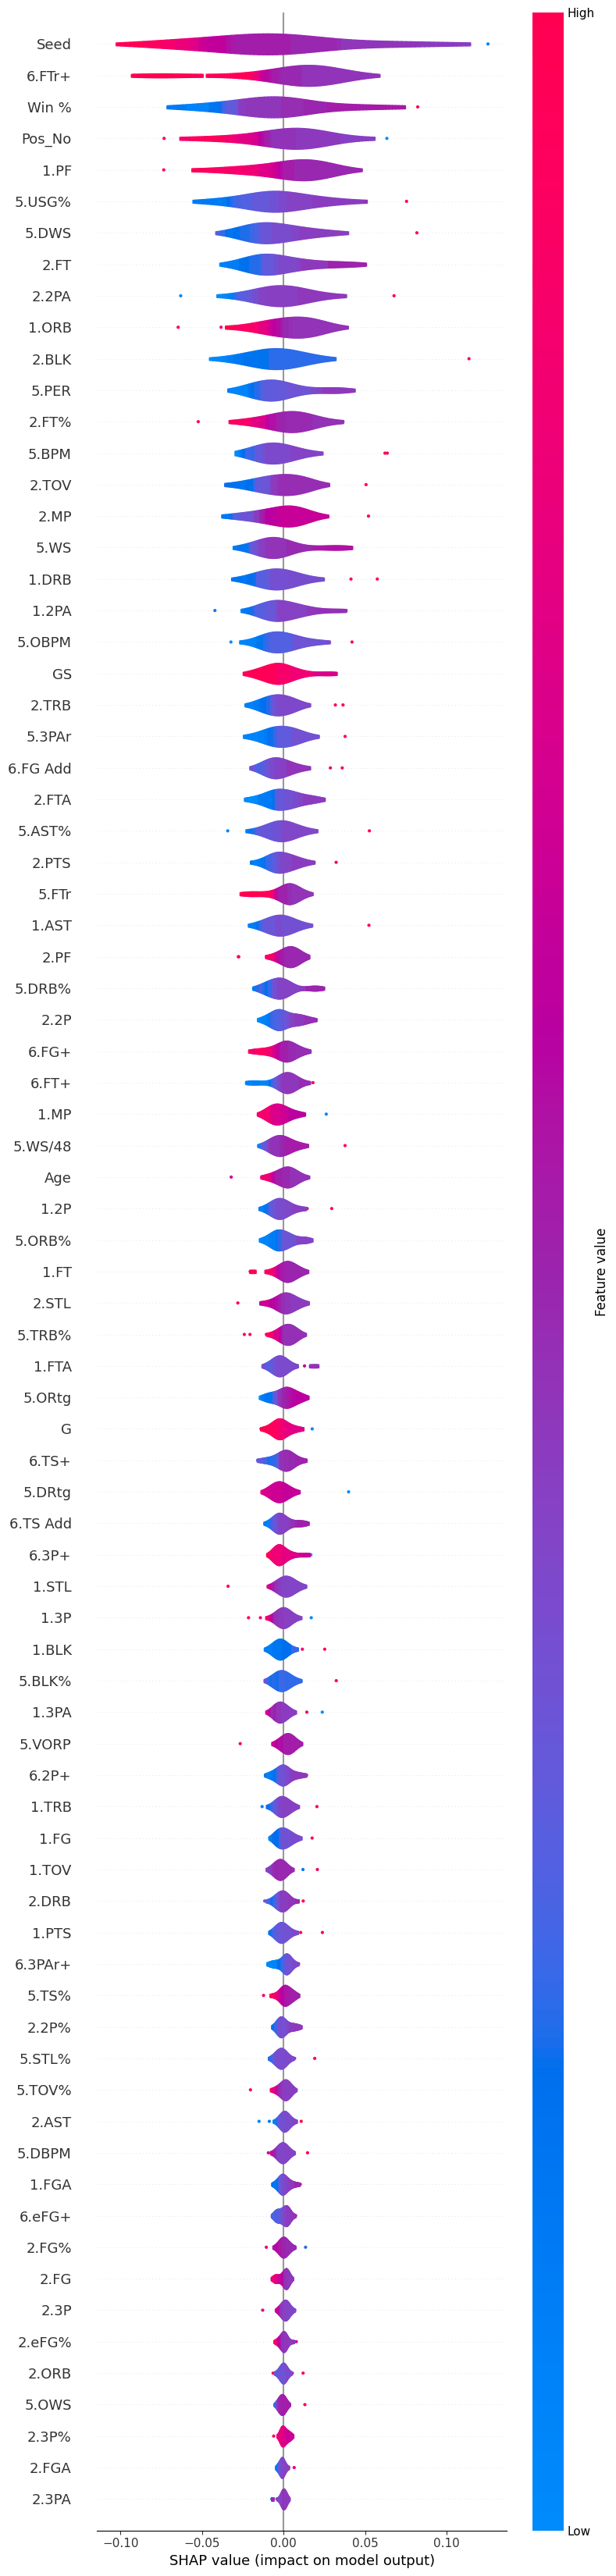

In [23]:
explainer = shap.Explainer(model.predict, normed_test_data)
shap_values = explainer(normed_test_data)
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='violin', max_display=len(test.columns))

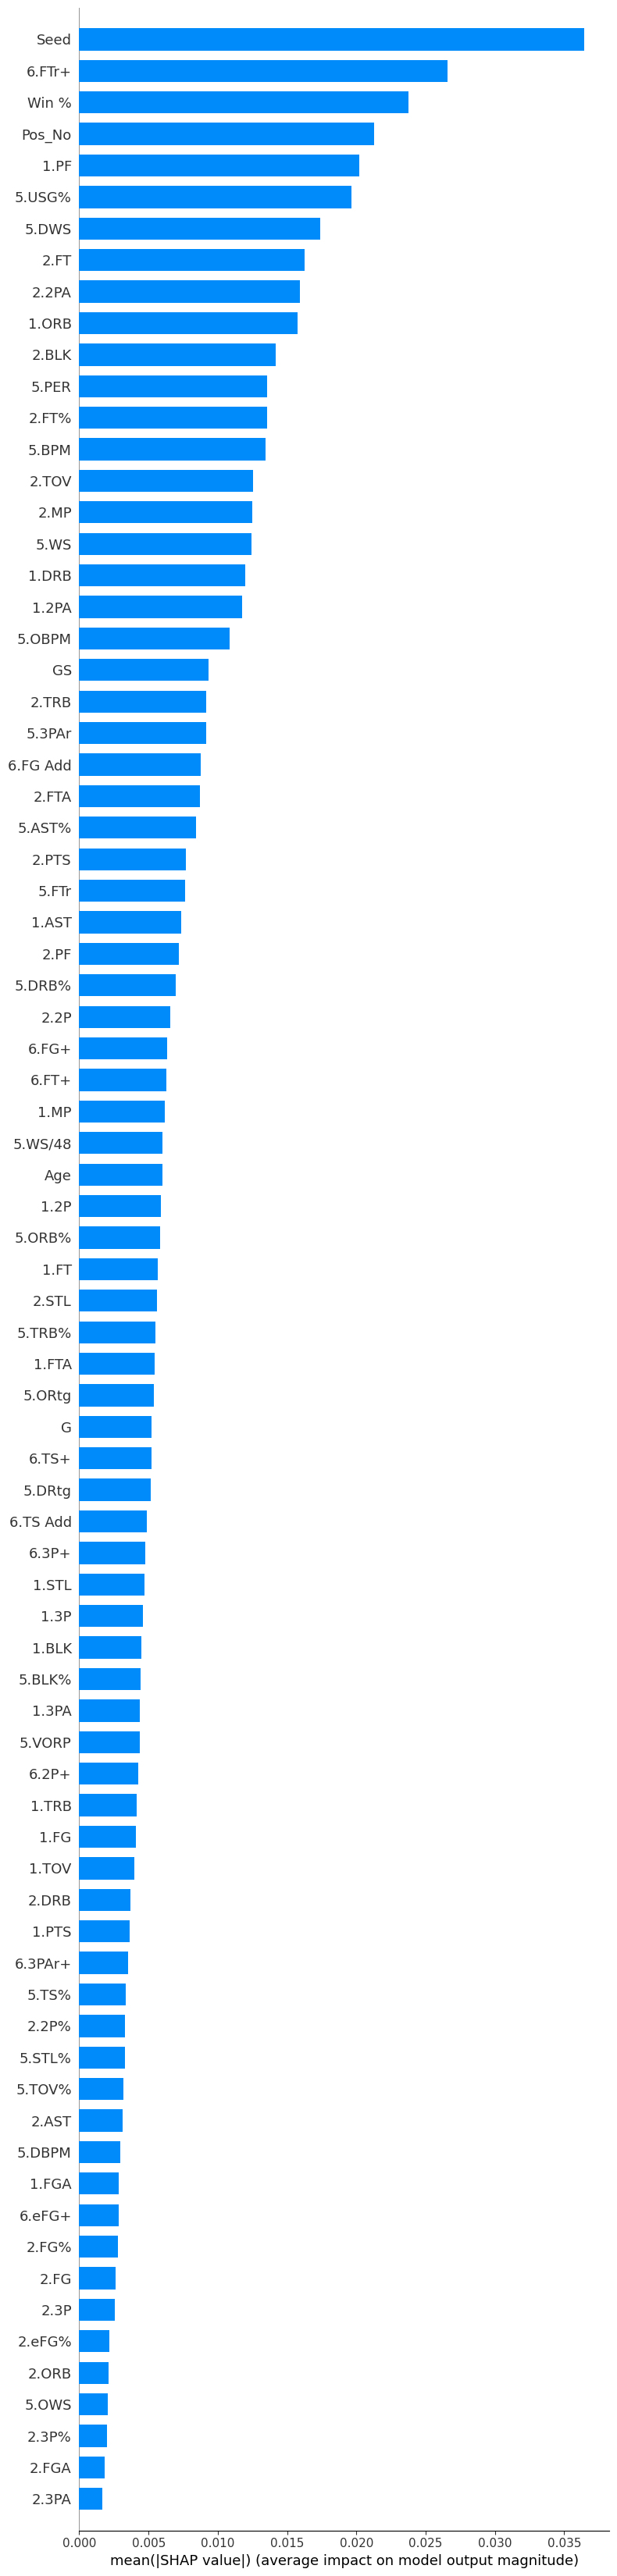

In [24]:
shap.summary_plot(shap_values, test, feature_names=test.columns ,plot_type='bar', max_display=len(test.columns))

#HISTORICAL ANALYSIS

In [45]:
leagueavs = pd.read_csv('LeagueAveragesByYear.csv')

adj_stat = stat_per100 * (no_of_poss / 100) * (MPG / 48)

MPG - 28th column - index = 27

Per Game Stats - 28, 29, 31, 32, 34, 35, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49

Per 100 Stats -  67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83

1990-91 : 97.8 possessions/48

1991-92 : 96.6 possessions/48

1992-93 : 96.8 possessions/48

1995-96 : 91.8 possessions/48

1996-97 : 90.1 possessions/48

1997-98 : 90.3 possessions/48

In [76]:
histo_test = pd.read_csv('HistoTest.csv')

In [77]:
histo_test

,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,0,Michael Jordan,SG,2,27,CHI,82,82,2,0.743902,...,112,111,113,114,62.0,218.6,301.1,1,0.928,1990-91
1,1,LeBron James,SF,3,27,MIA,62,62,4,0.696970,...,114,102,115,156,56.0,156.7,217.8,1,0.888,2011-12
2,2,Stephen Curry,PG,1,30,GSW,69,69,3,0.695122,...,115,120,115,83,168.0,213.1,239.9,0,0.173,2018-19
3,3,Kevin Durant,SF,3,21,OKC,82,82,10,0.609756,...,103,119,112,168,95.0,45.6,259.4,0,0.495,2009-10
4,4,James Harden,SG,2,25,HOU,81,81,3,0.682927,...,103,116,113,205,141.0,44.1,259.2,0,0.720,2014-15
5,5,Giannis Antetokounmpo,PF,4,26,MIL,61,61,7,0.638889,...,111,88,111,214,51.0,135.6,166.7,0,0.345,2020-21
6,6,Nikola Jokić,C,5,24,DEN,73,73,6,0.630137,...,107,106,107,108,62.0,77.3,96.8,0,0.018,2019-20
7,7,Michael Jordan,SG,2,28,CHI,80,80,1,0.817073,...,108,110,109,106,63.0,142.6,196.0,1,0.938,1991-92
8,8,LeBron James,SF,3,25,CLE,76,76,1,0.743902,...,109,101,111,168,114.0,134.8,229.4,1,0.980,2009-10
9,9,Stephen Curry,PG,1,26,GSW,80,80,1,0.817073,...,120,122,119,92,180.0,262.1,308.9,1,0.922,2014-15


In [78]:
df1 = pd.read_csv('AncientEra.csv')

In [79]:
histo_test.drop(histo_test.columns[[0]], axis = 1, inplace=True)

In [80]:
histo_test

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.eFG+,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Share,Year
0,Michael Jordan,SG,2,27,CHI,82,82,2,0.743902,3034,...,112,111,113,114,62.0,218.6,301.1,1,0.928,1990-91
1,LeBron James,SF,3,27,MIA,62,62,4,0.696970,2326,...,114,102,115,156,56.0,156.7,217.8,1,0.888,2011-12
2,Stephen Curry,PG,1,30,GSW,69,69,3,0.695122,2331,...,115,120,115,83,168.0,213.1,239.9,0,0.173,2018-19
3,Kevin Durant,SF,3,21,OKC,82,82,10,0.609756,3239,...,103,119,112,168,95.0,45.6,259.4,0,0.495,2009-10
4,James Harden,SG,2,25,HOU,81,81,3,0.682927,2981,...,103,116,113,205,141.0,44.1,259.2,0,0.720,2014-15
5,Giannis Antetokounmpo,PF,4,26,MIL,61,61,7,0.638889,2013,...,111,88,111,214,51.0,135.6,166.7,0,0.345,2020-21
6,Nikola Jokić,C,5,24,DEN,73,73,6,0.630137,2336,...,107,106,107,108,62.0,77.3,96.8,0,0.018,2019-20
7,Michael Jordan,SG,2,28,CHI,80,80,1,0.817073,3102,...,108,110,109,106,63.0,142.6,196.0,1,0.938,1991-92
8,LeBron James,SF,3,25,CLE,76,76,1,0.743902,2966,...,109,101,111,168,114.0,134.8,229.4,1,0.980,2009-10
9,Stephen Curry,PG,1,26,GSW,80,80,1,0.817073,2613,...,120,122,119,92,180.0,262.1,308.9,1,0.922,2014-15


In [81]:
training_data = df1.copy()
train = training_data.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
train_labels = training_data['MVP Share']

train.fillna(0)

scaler = StandardScaler()
normed_train_data = scaler.fit_transform(train)

In [102]:
test = histo_test.drop(['Player', 'Pos', 'Tm', 'MVP', 'MVP Share', 'Year'] + col_to_drop, axis=1)

test.fillna(0)
scaler = StandardScaler()
normed_test_data = scaler.fit_transform(test)

EPOCHS = 80
batch_size = 50

model = build_model3_five_hidden_layers()
print('Here is a summary of this model: ')
model.summary()


with tf.device('/CPU:0'): 
    history = model.fit(
        normed_train_data, 
        train_labels,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(normed_train_data.shape[0] / batch_size) ,
        callbacks=[tfdocs.modeling.EpochDots(), 
                ckpt_callback
                  ],
        
    )
Y_pred = model.predict(normed_test_data)
initial_results = histo_test[['Year', 'Player', 'Age', 'MVP']]
results = initial_results.copy()
results['Predicted MVP Share'] = Y_pred

print(results)

Here is a summary of this model: 
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 32)                2560      
                                                                 
 dense_117 (Dense)           (None, 64)                2112      
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dense_119 (Dense)           (None, 64)                4160      
                                                                 
 dense_120 (Dense)           (None, 64)                4160      
                                                                 
 dense_121 (Dense)           (None, 64)                4160      
                                                                 
 dense_122 (Dense) 

3/3 [==============================] - 2s 29ms/step - loss: 0.5500 - mae: 0.5104 - mse: 0.5500 - mape: 15936.1055
Epoch 2/80
1/3 [=========>....................] - ETA: 0s - loss: 0.1272 - mae: 0.2222 - mse: 0.1272 - mape: 733.6279.

3/3 [==============================] - 0s 22ms/step - loss: 0.0852 - mae: 0.1718 - mse: 0.0852 - mape: 1048.7241
Epoch 3/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0382 - mae: 0.1345 - mse: 0.0382 - mape: 1284.4489.

3/3 [==============================] - 0s 16ms/step - loss: 0.0366 - mae: 0.1439 - mse: 0.0366 - mape: 2522.7634
Epoch 4/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - mae: 0.1130 - mse: 0.0286 - mape: 2067.4250.

3/3 [==============================] - 0s 15ms/step - loss: 0.0271 - mae: 0.1032 - mse: 0.0271 - mape: 1238.7073
Epoch 5/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0331 - mae: 0.1065 - mse: 0.0331 - mape: 913.2440.

3/3 [==============================] - 0s 22ms/step - loss: 0.0240 - mae: 0.0930 - mse: 0.0240 - mape: 885.3225
Epoch 6/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0322 - mae: 0.1176 - mse: 0.0322 - mape: 719.9229.

3/3 [==============================] - 0s 23ms/step - loss: 0.0206 - mae: 0.0942 - mse: 0.0206 - mape: 912.0771
Epoch 7/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0413 - mae: 0.1199 - mse: 0.0413 - mape: 1044.9968.

3/3 [==============================] - 0s 24ms/step - loss: 0.0307 - mae: 0.0991 - mse: 0.0307 - mape: 804.6779
Epoch 8/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - mae: 0.1000 - mse: 0.0255 - mape: 961.8022.

3/3 [==============================] - 0s 37ms/step - loss: 0.0193 - mae: 0.0882 - mse: 0.0193 - mape: 932.9169
Epoch 9/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - mae: 0.0941 - mse: 0.0212 - mape: 1687.0743.

3/3 [==============================] - 0s 21ms/step - loss: 0.0180 - mae: 0.0842 - mse: 0.0180 - mape: 908.3185
Epoch 10/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - mae: 0.0839 - mse: 0.0143 - mape: 1104.0287.

3/3 [==============================] - 0s 17ms/step - loss: 0.0134 - mae: 0.0788 - mse: 0.0134 - mape: 816.9501
Epoch 11/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - mae: 0.0719 - mse: 0.0149 - mape: 674.2687.

3/3 [==============================] - 0s 18ms/step - loss: 0.0117 - mae: 0.0713 - mse: 0.0117 - mape: 878.0787
Epoch 12/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - mae: 0.0860 - mse: 0.0170 - mape: 1433.9858.

3/3 [==============================] - 0s 32ms/step - loss: 0.0147 - mae: 0.0759 - mse: 0.0147 - mape: 796.6208
Epoch 13/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - mae: 0.0741 - mse: 0.0137 - mape: 461.4622.

3/3 [==============================] - 0s 28ms/step - loss: 0.0108 - mae: 0.0644 - mse: 0.0108 - mape: 531.5663
Epoch 14/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - mae: 0.0717 - mse: 0.0112 - mape: 465.5857.

3/3 [==============================] - 0s 25ms/step - loss: 0.0080 - mae: 0.0593 - mse: 0.0080 - mape: 594.8671
Epoch 15/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - mae: 0.0780 - mse: 0.0152 - mape: 352.7629.

3/3 [==============================] - 0s 30ms/step - loss: 0.0111 - mae: 0.0681 - mse: 0.0111 - mape: 632.2795
Epoch 16/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - mae: 0.0735 - mse: 0.0121 - mape: 508.8632.

3/3 [==============================] - 0s 19ms/step - loss: 0.0113 - mae: 0.0678 - mse: 0.0113 - mape: 496.3564
Epoch 17/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - mae: 0.0663 - mse: 0.0094 - mape: 494.8569.

3/3 [==============================] - 0s 31ms/step - loss: 0.0077 - mae: 0.0604 - mse: 0.0077 - mape: 628.3582
Epoch 18/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0627 - mse: 0.0072 - mape: 1467.2247.

3/3 [==============================] - 0s 31ms/step - loss: 0.0079 - mae: 0.0590 - mse: 0.0079 - mape: 825.4814
Epoch 19/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - mae: 0.0626 - mse: 0.0072 - mape: 1030.6357.

3/3 [==============================] - 0s 17ms/step - loss: 0.0096 - mae: 0.0718 - mse: 0.0096 - mape: 1172.2909
Epoch 20/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - mae: 0.0600 - mse: 0.0068 - mape: 376.6319.

3/3 [==============================] - 0s 14ms/step - loss: 0.0070 - mae: 0.0536 - mse: 0.0070 - mape: 624.4350
Epoch 21/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0452 - mse: 0.0038 - mape: 1095.7343.

3/3 [==============================] - 0s 15ms/step - loss: 0.0069 - mae: 0.0558 - mse: 0.0069 - mape: 879.3150
Epoch 22/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - mae: 0.0516 - mse: 0.0062 - mape: 380.1562.

3/3 [==============================] - 0s 13ms/step - loss: 0.0071 - mae: 0.0554 - mse: 0.0071 - mape: 382.6678
Epoch 23/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - mae: 0.0402 - mse: 0.0040 - mape: 384.3323.

3/3 [==============================] - 0s 15ms/step - loss: 0.0040 - mae: 0.0410 - mse: 0.0040 - mape: 397.5591
Epoch 24/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0383 - mse: 0.0041 - mape: 419.6206.

3/3 [==============================] - 0s 9ms/step - loss: 0.0040 - mae: 0.0416 - mse: 0.0040 - mape: 404.7765
Epoch 25/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - mae: 0.0478 - mse: 0.0047 - mape: 735.5663.

3/3 [==============================] - 0s 11ms/step - loss: 0.0040 - mae: 0.0433 - mse: 0.0040 - mape: 623.9064
Epoch 26/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - mae: 0.0680 - mse: 0.0107 - mape: 531.9423.

3/3 [==============================] - 0s 15ms/step - loss: 0.0054 - mae: 0.0464 - mse: 0.0054 - mape: 537.2521
Epoch 27/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - mae: 0.0483 - mse: 0.0055 - mape: 492.3791.

3/3 [==============================] - 0s 12ms/step - loss: 0.0052 - mae: 0.0472 - mse: 0.0052 - mape: 409.1216
Epoch 28/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - mae: 0.0474 - mse: 0.0046 - mape: 386.0334.

3/3 [==============================] - 0s 16ms/step - loss: 0.0040 - mae: 0.0423 - mse: 0.0040 - mape: 292.9227
Epoch 29/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0313 - mse: 0.0022 - mape: 402.5964.

3/3 [==============================] - 0s 11ms/step - loss: 0.0037 - mae: 0.0360 - mse: 0.0037 - mape: 280.5665
Epoch 30/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - mae: 0.0477 - mse: 0.0043 - mape: 279.7498.

3/3 [==============================] - 0s 11ms/step - loss: 0.0032 - mae: 0.0401 - mse: 0.0032 - mape: 430.2281
Epoch 31/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - mae: 0.0401 - mse: 0.0035 - mape: 437.3639.

3/3 [==============================] - 0s 11ms/step - loss: 0.0047 - mae: 0.0474 - mse: 0.0047 - mape: 555.6176
Epoch 32/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - mae: 0.0355 - mse: 0.0041 - mape: 453.9012.

3/3 [==============================] - 0s 13ms/step - loss: 0.0050 - mae: 0.0418 - mse: 0.0050 - mape: 313.0081
Epoch 33/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - mae: 0.0406 - mse: 0.0055 - mape: 389.0609.

3/3 [==============================] - 0s 16ms/step - loss: 0.0050 - mae: 0.0441 - mse: 0.0050 - mape: 411.4935
Epoch 34/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - mae: 0.0483 - mse: 0.0063 - mape: 599.3138.

3/3 [==============================] - 0s 14ms/step - loss: 0.0042 - mae: 0.0438 - mse: 0.0042 - mape: 662.8596
Epoch 35/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0362 - mse: 0.0028 - mape: 387.1353.

3/3 [==============================] - 0s 18ms/step - loss: 0.0034 - mae: 0.0381 - mse: 0.0034 - mape: 297.9735
Epoch 36/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - mae: 0.0326 - mse: 0.0025 - mape: 417.8247.

3/3 [==============================] - 0s 12ms/step - loss: 0.0044 - mae: 0.0392 - mse: 0.0044 - mape: 307.1524
Epoch 37/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - mae: 0.0357 - mse: 0.0028 - mape: 224.3194.

3/3 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0345 - mse: 0.0027 - mape: 205.0228
Epoch 38/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - mae: 0.0384 - mse: 0.0039 - mape: 347.3247.

3/3 [==============================] - 0s 12ms/step - loss: 0.0029 - mae: 0.0383 - mse: 0.0029 - mape: 500.5433
Epoch 39/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - mae: 0.0347 - mse: 0.0023 - mape: 1116.4027.

3/3 [==============================] - 0s 15ms/step - loss: 0.0046 - mae: 0.0410 - mse: 0.0046 - mape: 605.0510
Epoch 40/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0317 - mse: 0.0036 - mape: 343.1230.

3/3 [==============================] - 0s 13ms/step - loss: 0.0077 - mae: 0.0478 - mse: 0.0077 - mape: 232.9544
Epoch 41/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - mae: 0.0419 - mse: 0.0045 - mape: 329.9644.

3/3 [==============================] - 0s 10ms/step - loss: 0.0081 - mae: 0.0571 - mse: 0.0081 - mape: 427.6483
Epoch 42/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0264 - mse: 0.0016 - mape: 290.0187.

3/3 [==============================] - 0s 11ms/step - loss: 0.0098 - mae: 0.0523 - mse: 0.0098 - mape: 290.3871
Epoch 43/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - mae: 0.0770 - mse: 0.0163 - mape: 142.9734.

3/3 [==============================] - 0s 11ms/step - loss: 0.0096 - mae: 0.0588 - mse: 0.0096 - mape: 533.3322
Epoch 44/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - mae: 0.0949 - mse: 0.0178 - mape: 1215.1260.

3/3 [==============================] - 0s 10ms/step - loss: 0.0117 - mae: 0.0734 - mse: 0.0117 - mape: 881.0500
Epoch 45/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - mae: 0.0467 - mse: 0.0065 - mape: 403.8260.

3/3 [==============================] - 0s 12ms/step - loss: 0.0137 - mae: 0.0721 - mse: 0.0137 - mape: 375.5386
Epoch 46/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - mae: 0.0372 - mse: 0.0038 - mape: 390.5481.

3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - mae: 0.0427 - mse: 0.0040 - mape: 486.9106
Epoch 47/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - mae: 0.0763 - mse: 0.0133 - mape: 1163.6425.

3/3 [==============================] - 0s 11ms/step - loss: 0.0073 - mae: 0.0567 - mse: 0.0073 - mape: 812.9789
Epoch 48/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - mae: 0.0472 - mse: 0.0049 - mape: 267.3895.

3/3 [==============================] - 0s 15ms/step - loss: 0.0047 - mae: 0.0427 - mse: 0.0047 - mape: 317.6727
Epoch 49/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - mae: 0.0439 - mse: 0.0048 - mape: 289.4597.

3/3 [==============================] - 0s 17ms/step - loss: 0.0035 - mae: 0.0389 - mse: 0.0035 - mape: 254.3015
Epoch 50/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - mae: 0.0242 - mse: 0.0014 - mape: 461.0222.

3/3 [==============================] - 0s 13ms/step - loss: 0.0034 - mae: 0.0342 - mse: 0.0034 - mape: 440.2083
Epoch 51/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - mae: 0.0301 - mse: 0.0016 - mape: 459.7652.

3/3 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0395 - mse: 0.0036 - mape: 426.1791
Epoch 52/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - mae: 0.0390 - mse: 0.0033 - mape: 352.1091.

3/3 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0319 - mse: 0.0024 - mape: 345.1812
Epoch 53/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - mae: 0.0402 - mse: 0.0040 - mape: 319.5679.

3/3 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0304 - mse: 0.0024 - mape: 238.3979
Epoch 54/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - mae: 0.0397 - mse: 0.0036 - mape: 263.8035.

3/3 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0311 - mse: 0.0024 - mape: 309.9733
Epoch 55/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0290 - mse: 0.0019 - mape: 213.6478.

3/3 [==============================] - 0s 12ms/step - loss: 0.0018 - mae: 0.0294 - mse: 0.0018 - mape: 381.0684
Epoch 56/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - mae: 0.0343 - mse: 0.0024 - mape: 428.3673.

3/3 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0287 - mse: 0.0020 - mape: 325.7172
Epoch 57/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0264 - mse: 0.0019 - mape: 235.4640.

3/3 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0327 - mse: 0.0031 - mape: 168.5324
Epoch 58/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - mae: 0.0225 - mse: 0.0010 - mape: 440.8870.

3/3 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0345 - mse: 0.0030 - mape: 387.0542
Epoch 59/80
1/3 [=========>....................] - ETA: 0s - loss: 4.5645e-04 - mae: 0.0153 - mse: 4.5645e-04 - mape: 268.6673.

3/3 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0224 - mse: 0.0015 - mape: 268.1520   
Epoch 60/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - mae: 0.0238 - mse: 0.0015 - mape: 188.4047.

3/3 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0296 - mse: 0.0023 - mape: 234.1451
Epoch 61/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - mae: 0.0310 - mse: 0.0019 - mape: 565.7265.

3/3 [==============================] - 0s 16ms/step - loss: 0.0019 - mae: 0.0323 - mse: 0.0019 - mape: 509.3239
Epoch 62/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - mae: 0.0219 - mse: 0.0011 - mape: 284.1677.

3/3 [==============================] - 0s 13ms/step - loss: 0.0014 - mae: 0.0233 - mse: 0.0014 - mape: 246.6782
Epoch 63/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - mae: 0.0289 - mse: 0.0022 - mape: 203.4296.

3/3 [==============================] - 0s 12ms/step - loss: 0.0015 - mae: 0.0246 - mse: 0.0015 - mape: 192.0771
Epoch 64/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - mae: 0.0363 - mse: 0.0031 - mape: 241.7282.

3/3 [==============================] - 0s 13ms/step - loss: 0.0018 - mae: 0.0283 - mse: 0.0018 - mape: 430.5144
Epoch 65/80
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - mae: 0.0218 - mse: 0.0012 - mape: 301.9534.

3/3 [==============================] - 0s 14ms/step - loss: 0.0013 - mae: 0.0242 - mse: 0.0013 - mape: 334.5599
Epoch 66/80
1/3 [=========>....................] - ETA: 0s - loss: 5.0306e-04 - mae: 0.0160 - mse: 5.0306e-04 - mape: 251.2148.

3/3 [==============================] - 0s 13ms/step - loss: 7.4460e-04 - mae: 0.0180 - mse: 7.4460e-04 - mape: 251.1601
Epoch 67/80
1/3 [=========>....................] - ETA: 0s - loss: 4.2191e-04 - mae: 0.0150 - mse: 4.2191e-04 - mape: 194.3322.

3/3 [==============================] - 0s 12ms/step - loss: 4.3645e-04 - mae: 0.0148 - mse: 4.3645e-04 - mape: 165.6653
Epoch 68/80
1/3 [=========>....................] - ETA: 0s - loss: 4.3471e-04 - mae: 0.0141 - mse: 4.3471e-04 - mape: 245.3147.

3/3 [==============================] - 0s 15ms/step - loss: 6.3147e-04 - mae: 0.0174 - mse: 6.3147e-04 - mape: 252.7986
Epoch 69/80
1/3 [=========>....................] - ETA: 0s - loss: 1.9060e-04 - mae: 0.0110 - mse: 1.9060e-04 - mape: 344.5477.

3/3 [==============================] - 0s 15ms/step - loss: 4.1831e-04 - mae: 0.0153 - mse: 4.1831e-04 - mape: 321.5823
Epoch 70/80
1/3 [=========>....................] - ETA: 0s - loss: 7.0634e-04 - mae: 0.0199 - mse: 7.0634e-04 - mape: 342.3255.

3/3 [==============================] - 0s 14ms/step - loss: 4.9575e-04 - mae: 0.0154 - mse: 4.9575e-04 - mape: 220.2192
Epoch 71/80
1/3 [=========>....................] - ETA: 0s - loss: 6.7812e-04 - mae: 0.0197 - mse: 6.7812e-04 - mape: 287.7858.

3/3 [==============================] - 0s 12ms/step - loss: 4.9439e-04 - mae: 0.0167 - mse: 4.9439e-04 - mape: 241.1638
Epoch 72/80
1/3 [=========>....................] - ETA: 0s - loss: 5.1911e-04 - mae: 0.0167 - mse: 5.1911e-04 - mape: 343.6329.

3/3 [==============================] - 0s 13ms/step - loss: 4.9328e-04 - mae: 0.0158 - mse: 4.9328e-04 - mape: 295.5499
Epoch 73/80
1/3 [=========>....................] - ETA: 0s - loss: 1.8001e-04 - mae: 0.0100 - mse: 1.8001e-04 - mape: 148.3623.

3/3 [==============================] - 0s 17ms/step - loss: 5.1580e-04 - mae: 0.0152 - mse: 5.1580e-04 - mape: 168.5120
Epoch 74/80
1/3 [=========>....................] - ETA: 0s - loss: 4.2537e-04 - mae: 0.0125 - mse: 4.2537e-04 - mape: 290.2419.

3/3 [==============================] - 0s 19ms/step - loss: 4.8057e-04 - mae: 0.0142 - mse: 4.8057e-04 - mape: 239.0579
Epoch 75/80
1/3 [=========>....................] - ETA: 0s - loss: 3.7972e-04 - mae: 0.0133 - mse: 3.7972e-04 - mape: 228.5998.

3/3 [==============================] - 0s 12ms/step - loss: 4.1106e-04 - mae: 0.0132 - mse: 4.1106e-04 - mape: 191.8631
Epoch 76/80
1/3 [=========>....................] - ETA: 0s - loss: 3.6024e-04 - mae: 0.0135 - mse: 3.6024e-04 - mape: 175.1991.

3/3 [==============================] - 0s 13ms/step - loss: 3.0779e-04 - mae: 0.0125 - mse: 3.0779e-04 - mape: 199.9162
Epoch 77/80
1/3 [=========>....................] - ETA: 0s - loss: 1.7097e-04 - mae: 0.0097 - mse: 1.7097e-04 - mape: 261.7851.

3/3 [==============================] - 0s 15ms/step - loss: 2.9445e-04 - mae: 0.0122 - mse: 2.9445e-04 - mape: 236.6143
Epoch 78/80
1/3 [=========>....................] - ETA: 0s - loss: 3.9746e-04 - mae: 0.0117 - mse: 3.9746e-04 - mape: 113.1015.

3/3 [==============================] - 0s 17ms/step - loss: 3.7380e-04 - mae: 0.0120 - mse: 3.7380e-04 - mape: 114.4669
Epoch 79/80
1/3 [=========>....................] - ETA: 0s - loss: 3.5468e-04 - mae: 0.0133 - mse: 3.5468e-04 - mape: 282.4106.

3/3 [==============================] - 0s 13ms/step - loss: 2.0565e-04 - mae: 0.0099 - mse: 2.0565e-04 - mape: 229.8753
Epoch 80/80
1/3 [=========>....................] - ETA: 0s - loss: 3.3790e-04 - mae: 0.0123 - mse: 3.3790e-04 - mape: 182.4264.

2/2 [==============================] - 0s 6ms/step
       Year                 Player  Age  MVP  Predicted MVP Share
0   1990-91         Michael Jordan   27    1             0.256279
1   2011-12           LeBron James   27    1             0.400059
2   2018-19          Stephen Curry   30    0             0.015562
3   2009-10           Kevin Durant   21    0             0.023385
4   2014-15           James Harden   25    0             0.068948
5   2020-21  Giannis Antetokounmpo   26    0             0.010425
6   2019-20           Nikola Jokić   24    0            -0.001900
7   1991-92         Michael Jordan   28    1             0.104298
8   2009-10           LeBron James   25    1             1.018691
9   2014-15          Stephen Curry   26    1            -0.001905
10  2011-12           Kevin Durant   23    0             0.149438
11  2018-19           James Harden   29    0             0.291669
12  2018-19  Giannis Antetokounmpo   24    1             0.387737
13  2021-22           Nik

In [103]:
r1 = results.iloc[0:7]
r1 = r1.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r1

,Year,Player,Age,MVP,Predicted MVP Share
0,2011-12,LeBron James,27,1,0.400059
1,1990-91,Michael Jordan,27,1,0.256279
2,2014-15,James Harden,25,0,0.068948
3,2009-10,Kevin Durant,21,0,0.023385
4,2018-19,Stephen Curry,30,0,0.015562
5,2020-21,Giannis Antetokounmpo,26,0,0.010425
6,2019-20,Nikola Jokić,24,0,-0.001900


In [104]:
r2 = results.iloc[7:14]
r2 = r2.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r2

,Year,Player,Age,MVP,Predicted MVP Share
0,2009-10,LeBron James,25,1,1.018691
1,2018-19,Giannis Antetokounmpo,24,1,0.387737
2,2018-19,James Harden,29,0,0.291669
3,2011-12,Kevin Durant,23,0,0.149438
4,2021-22,Nikola Jokić,26,1,0.104923
5,1991-92,Michael Jordan,28,1,0.104298
6,2014-15,Stephen Curry,26,1,-0.001905


In [105]:
r3 = results.iloc[14:20]
r3 = r3.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r3

,Year,Player,Age,MVP,Predicted MVP Share
0,2017-18,LeBron James,33,0,0.069709
1,1992-93,Michael Jordan,29,0,0.027639
2,2015-16,Kevin Durant,27,0,0.016760
3,2013-14,James Harden,24,0,0.001440
4,2016-17,Giannis Antetokounmpo,22,0,-0.004706
5,2016-17,Stephen Curry,28,0,-0.011947


In [106]:
r4 = results.iloc[20:27]
r4 = r4.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r4

,Year,Player,Age,MVP,Predicted MVP Share
0,2012-13,LeBron James,28,1,0.865634
1,1995-96,Michael Jordan,32,1,0.385134
2,2013-14,Kevin Durant,25,1,0.359606
3,2017-18,James Harden,28,1,0.319573
4,2019-20,Giannis Antetokounmpo,25,1,0.092612
5,2015-16,Stephen Curry,27,1,0.059381
6,2020-21,Nikola Jokić,25,1,0.016445


In [107]:
r5 = results.iloc[27:33]
r5 = r5.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r5

,Year,Player,Age,MVP,Predicted MVP Share
0,1996-97,Michael Jordan,33,0,0.363178
1,2019-20,LeBron James,35,0,0.038641
2,2019-20,James Harden,30,0,0.032048
3,2017-18,Giannis Antetokounmpo,23,0,0.019086
4,2010-11,Kevin Durant,22,0,-0.000850
5,2013-14,Stephen Curry,25,0,-0.013438


In [108]:
r6 = results.iloc[33:39]
r6 = r6.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)
r6

,Year,Player,Age,MVP,Predicted MVP Share
0,2008-09,LeBron James,24,1,0.894550
1,2012-13,Kevin Durant,24,0,0.105324
2,2016-17,James Harden,27,0,0.055196
3,2020-21,Stephen Curry,32,0,0.015905
4,1997-98,Michael Jordan,34,1,0.015884
5,2021-22,Giannis Antetokounmpo,27,0,0.013064
